# Read the input dataset :

1. usable_samples_ADNI.json : stores the IID (index) for each row of PRS_feature_matrix.npy
2. PRS_feature_matrix.npy : PR Score for different features
3. Covar_FILE_bigger_dataset : for reading covar such as age, gender
4. Final_Samples.json : contains ID and output for each data

In [1]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn

import pandas as pd
import numpy as np
import json
import random
import math

import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable
import torch
from torch.utils import data

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import shap
from copy import deepcopy

import pickle
from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import tpot

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

In [2]:
# !pip install skfeature-chappers
# !pip install mlxtend
# !pip --version
# !pip install imblearn
# !conda install -c conda-forge imbalanced-learn
# conda install -c conda-forge tqdm
# conda install mlxtend

# conda config --add channels conda-forge
# conda install hyperopt

# conda config --add channels conda-forge
# conda config --set channel_priority strict
# conda install auto-sklearn
# conda install -c conda-forge tpot



Show the installed packages with their versions

In [3]:
!conda list

# packages in environment at /home/bayzid/anaconda3:
#
# Name                    Version                   Build  Channel
_anaconda_depends         2020.07                  py37_0  
_ipyw_jlab_nb_ext_conf    0.1.0                    py37_0  
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                  2_kmp_llvm    conda-forge
absl-py                   1.0.0                    pypi_0    pypi
adjusttext                0.7.3                    pypi_0    pypi
alabaster                 0.7.12                     py_0    conda-forge
anaconda                  custom                   py37_1  
anaconda-client           1.11.0             pyhd8ed1ab_1    conda-forge
anaconda-navigator        2.1.0            py37h06a4308_0  
anaconda-project          0.11.1             pyhd8ed1ab_0    conda-forge
anyio                     3.6.2              pyhd8ed1ab_0    conda-forge
argh                      0.26.2          pyh9f0ad1d_1002    conda-f

In [4]:
Final_Samples_path = 'final_samples_progression_from_mci_4yrs.json'
Final_Samples = json.load(open(Final_Samples_path, 'r')) 
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_orig_feature_matrix = np.load('./PRS_feature_matrix.npy').astype(np.float32)
# normalize feature matrix
PRS_orig_feature_matrix = (PRS_orig_feature_matrix - PRS_orig_feature_matrix.mean(0))/PRS_orig_feature_matrix.std(0)
# PRS_orig_feature_matrix.shape[1], len(usable_samples_ADNI), usable_samples_ADNI
num_features=PRS_orig_feature_matrix.shape[1]
print(len( usable_samples_ADNI ) )
print(num_features)

1816
52


In [5]:
# covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
covar_df = pd.read_csv('./COVAR_FILE_bigger_dataset.txt', ' ') 
print("shape",covar_df.shape)
print( covar_df[['AGE', 'PTGENDER']].shape, covar_df[['AGE', 'PTGENDER']].dropna().shape ) 
# PC - Principal Component

# trying to normalize AGE with having max age of 100
covar_df['AGE'] = covar_df['AGE'] / 100.0
print( covar_df.head() )

shape (1817, 14)
(1817, 2) (1817, 2)
                FID               IID       PC1       PC2       PC3       PC4  \
0  ADNI3_036_S_6231  ADNI3_036_S_6231 -0.006724 -0.010617  0.001596 -0.000460   
1  ADNI3_006_S_6277  ADNI3_006_S_6277 -0.010432 -0.010269  0.012757  0.006921   
2  ADNI3_129_S_6146  ADNI3_129_S_6146 -0.004919 -0.011656 -0.035521  0.064641   
3  ADNI3_033_S_6352  ADNI3_033_S_6352 -0.014069 -0.010279  0.020014  0.053023   
4  ADNI3_027_S_6183  ADNI3_027_S_6183 -0.010766 -0.012370 -0.010960  0.029830   

        PC5       PC6       PC7       PC8       PC9      PC10  PTGENDER    AGE  
0 -0.013131 -0.005855 -0.005142 -0.009063 -0.001739 -0.012863         1  0.691  
1 -0.014958 -0.005860 -0.027775 -0.009632  0.054966  0.087390         1  0.707  
2  0.012094  0.003860  0.035955  0.006561  0.019736 -0.023304         1  0.655  
3  0.023691  0.000247 -0.002273 -0.030627 -0.053461  0.049984         0  0.714  
4 -0.019520 -0.001955  0.023844  0.079138  0.002207  0.008892         0

Covar for ADNI Plink

# Alter parameters :
    1. Number of features
    2. Number of Hidden Layers 
    3. Dimension of Hidden Layers

In [6]:
num_features = 52
hidden = 4
hidden_dimension = 32

In [7]:
# take the first num_features column from PRS_feature_matrix
PRS_feature_matrix = PRS_orig_feature_matrix
PRS_feature_matrix = PRS_feature_matrix[:, :num_features]
print(PRS_feature_matrix.shape)

(1816, 52)


Final Samples has two columns of data :
    1. ID 
    2. output - true / false
    
Get the length of positive and negative samples of test dataset

In [8]:
# positive samples - output true
# negative samples - output false
len_positive_samples = 0
len_negative_samples = 0
for x in Final_Samples:
    if x[1] == 1 :
        len_positive_samples += 1
    else :
        len_negative_samples += 1
        
print(len(Final_Samples))
print(len_positive_samples)
print(len_negative_samples)

559
319
240


# Combining covar data with PRS Feature Matrix

In [9]:
# cnt = number of missing IDs for which covar data doesn't exist
cnt = 0
print("Before adding covar_df columns, shape : ",PRS_feature_matrix.shape)
# adding ( total columns - 2 ) of covar_df , excluding FID, IID
FEATURE_MATRIX = np.concatenate([PRS_feature_matrix, np.zeros([PRS_feature_matrix.shape[0], covar_df.shape[1] - 2 ])], 1).astype(np.float32)
print("Before adding covar_df columns, shape : ",FEATURE_MATRIX.shape)
for sample in usable_samples_ADNI:
    # taking from the PCs, skipping the first two columns of IID, FID
    covar = covar_df[covar_df['IID'] == sample].to_numpy()[:, 2:].astype(np.float32) 
    # shape[0] = 1 means a row is found in covar for the following sample ID
    # if not, that means no covar data exists for the sample in usable_samples_ADNI
    if covar.shape[0] != 1:
#         print(covar.shape)
        print(sample)
        cnt += 1
        continue
    # Adding the covar values to the feature matrix
    FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar


print("Count of missing samples for covar data : ", cnt)
#     FEATURE_MATRIX[usable_samples_ADNI[sample], num_features:] = covar # naeem's modification
# cnt/FEATURE_MATRIX.shape[0], FEATURE_MATRIX[:2], PRS_feature_matrix[:2]

Before adding covar_df columns, shape :  (1816, 52)
Before adding covar_df columns, shape :  (1816, 64)
ADNI3_037_S_6125
ADNI3_024_S_6005
ADNI3_002_S_6066
ADNI3_011_S_6303
ADNI3_053_S_6598
7_098_S_0160
8_027_S_0256
26_052_S_1346
47_072_S_2027
51_016_S_0702
64_027_S_2219
71_027_S_1045
75_068_S_4174
82_007_S_2058
86_100_S_0296
96_041_S_1418
222_141_S_0915
239_153_S_4372
313_068_S_4340
315_129_S_4396
324_129_S_4371
379_037_S_4146
387_130_S_4405
388_126_S_4507
397_022_S_1097
445_021_S_4254
446_137_S_4299
449_006_S_0498
462_098_S_4018
477_082_S_1256
480_098_S_2079
487_002_S_4237
492_041_S_4271
522_068_S_4332
533_127_S_4500
555_099_S_4463
583_141_S_2333
589_099_S_1034
630_022_S_2087
637_033_S_0922
648_137_S_0972
655_021_S_2150
665_027_S_0074
675_014_S_0658
682_099_S_2146
691_037_S_0377
695_057_S_1269
719_023_S_4035
740_137_S_0459
753_016_S_1326
763_100_S_0047
801_123_S_4096
196_037_S_0454
210_036_S_0673
263_072_S_1380
268_141_S_1004
26_128_S_0522
289_023_S_0126
296_029_S_0914
298_021_S_0178


# Create directory for saving shap figures

In [10]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)

# Storing the index with the Age = 0

age is zero for the rows that the covar data was not found

In [11]:
age_zero = 0
age_zero_idx = []
for i in range( len(FEATURE_MATRIX) ):
    if FEATURE_MATRIX[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
        
print(age_zero)

234


# Indices of features to consider

In [12]:


# feature_indices_to_consider = list(range(23))#list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# naeem modified
print(FEATURE_MATRIX.shape[1])
last_idx = FEATURE_MATRIX.shape[1] - 1
feature_indices_to_consider = list( range(num_features - 1 ) )  + [last_idx - 1, last_idx] #list(range(35)) #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 18, 20, 22]
# remove_indices = [1, 2, 3]
# for i in remove_indices:
#     feature_indices_to_consider.remove(i)

# feature_indices_to_consider = list(range(23, 36))

# feature_indices_to_consider = [ 4, 11, 14, 21, 23, 26, 32, 34, 46]

# feature_indices_to_consider = [ 9, 10, 11, 14, 21, 23, 26, 28, 32, 34, 46]
# feature_indices_to_consider = [9, 10, 28, 34, 46]

print(feature_indices_to_consider)
# feature_indices_to_consider = [1, 2, 3, 11, 14, 21, 23, 26, 32, 45]
# feature_indices_to_consider = [2, 26, 32, 45]


64
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 62, 63]


# Functions & Classes

In [13]:
# save_in_file: saves model accuracy in a text file
#     args : model_name : name of model with layers and dimensions
#            accuracy : accuracy  score
def save_in_file(model_name, accuracy):
    model_file = open("model_details.txt","a")
    model_file.write(model_name + " -> accuracy : " + str(accuracy) + "\n" )
    model_file.close() 

**Modifications**
1. Added relu in the hidden layers and sigmoid in the output layer as activation functions
2. Added dropout in the hidden layers

In [14]:
class simple_model(nn.Module):
    def __init__(self, num_features=FEATURE_MATRIX.shape[1], hidden_dim= hidden_dimension, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        num_hidden = hidden
        hidden_dim = hidden_dimension
        self.fc1 = nn.Linear(num_features, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
        for i in range(self.num_hidden):
            features = self.fc_hidden[i](features)
            # added by Mashiat
            features = self.dropout(features, p=self.drop_probab)
            features = self.relu( features )
            ####################
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
#         print(features.shape, features)
        probab = self.sigmoid(logit)
        return probab
    

In [15]:
simple_model(num_features=len(feature_indices_to_consider))

simple_model(
  (fc1): Linear(in_features=53, out_features=32, bias=True)
  (fc_hidden): ModuleList(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (fc2): Linear(in_features=32, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (relu): ReLU()
)

# dataSet class 
combines usable_samples_ADNI, Final_Samples, feature_matrix to one dataset with features and labels

In [16]:
class dataSet(data.Dataset):
    def __init__(self, Final_Samples, feature_matrix, usable_samples_ADNI, feature_indices_to_consider=feature_indices_to_consider):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.feature_indices_to_consider = feature_indices_to_consider
        self.feature_matrix = feature_matrix[:, self.feature_indices_to_consider]
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.feature_matrix = (self.feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.feature_matrix.mean(0)
        std = self.feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

# Converting Pandas Dataframe to Dataset class

overriding the constructor, getitem, len function of the original class

In [17]:
class df_dataSet(data.Dataset):
    def __init__(self, X, y):
        
        self.features = torch.tensor(X.values, dtype=torch.float32)
        self.labels = torch.tensor(y.values, dtype=torch.float32)
        
    def __getitem__(self, index):
        return self.features[index], self.labels[index]
    
        
        
    def __len__(self):
        return len(self.labels)

In [18]:
# random samples : sample test dataset taking equal number of positive & negative outputs
#                 args : 
#                         total_folds : fold number for splitting
#                         random_seed : seed value for randomization
#                 return :
#                         N_splits : test dataset splitted according to fold numbers
                        
def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open(Final_Samples_path, 'r')) 
    positive_samples = Final_Samples[:len_positive_samples]
    negative_samples = Final_Samples[len_positive_samples:]
    min_len = min( len(positive_samples), len(negative_samples))
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(positive_samples)
    random.shuffle(negative_samples)
    print("min length : ", min_len)
    Final_Samples = positive_samples[:min_len] + negative_samples[:min_len]
    random.shuffle(Final_Samples)
    print(len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0]))
    Final_Samples = np.array(Final_Samples)

#   -----------------------------------------------------------------------
#     positive_samples = Final_Samples[:654]
#     negative_samples = Final_Samples[654:]
#     if random_seed is not None: 
#         random.seed(random_seed * 2)
#     random.shuffle(positive_samples)
#     random.shuffle(negative_samples)
#     Final_Samples = positive_samples[:500] + negative_samples[:500]
#     if random_seed is not None: 
#         random.seed(random_seed)
#     random.shuffle(Final_Samples)
#     Final_Samples = np.array(Final_Samples)
# --------------------------------------------------------------------------
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

# generate_datasets : get train, validation & test datasets
#                 args : 
#                         N_splits : data splitted according to folds; output of random samples
#                         fold_num : fold_num for test dataset
#                         random_seed : seed value for randomization
#                 return :
#                         train_set, test_set, val_set : datasets
def generate_datasets(N_splits, fold_num, random_seed):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2]).tolist()
    if random_seed is not None: 
        random.seed(random_seed * 3)
    random.shuffle(train_samples)
    train_samples = np.array(train_samples)
    # take all as training dataset, leaves nothing for validation - multiply shpae by 1
    split_pos = int(train_samples.shape[0] * 1.) 
    #split_pos = int(train_samples.shape[0] * .8) 
#     print(train_samples.shape, split_pos, train_samples.shape[0])
    train_samples, val_samples = train_samples[:split_pos], train_samples[split_pos:]
    train_set = dataSet(Final_Samples=train_samples, 
                        feature_matrix=FEATURE_MATRIX, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=val_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    test_set = dataSet(Final_Samples=test_samples, 
                      feature_matrix=FEATURE_MATRIX, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    # normalize dataset
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    test_set.update_prs_features(mean, std)
#     print(len(train_set))
#     print(len(val_set))
#     print(len(test_set))
    return train_set, val_set, test_set



# generate_loader : get train, validation & test as torch dataset
#                 args : 
#                         train_set, test_set, val_set : datasets
#                 returns :
#                         train, val & test torch datasets
def generate_loader(train_set, val_set, test_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    test_batch_size = test_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set,
                                              batch_size=test_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader, test_loader

# train_set, val_set, test_set = generate_datasets(N_splits=random_samples(total_folds=10, random_seed=0), fold_num=0, random_seed=0)
# val_set.feature_matrix.shape

In [19]:
# epoch function : runs an epoch of a model
#                 args :
#                         model : neural network model
#                         optimizer :
#                         criterion :
#                         is_training : train - true or test - false
#                         loader : torch dataset
#                 returns :
#                         different accuracy score for the dataset of per epoch
def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
#     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
#     return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    print( precision, recall, fscore, support, auroc, auprc)
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    


**epoch function for LOOCV**

Without precision, recall, ROC, AUC 

In [20]:
def loocv_epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
#     print(loader)
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
        label = torch.reshape(label, (label.shape[0], 1))
        probab = model(features)
        if is_training:  
#             print(probab.shape, label.shape)
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
#     precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
#     auroc = roc_auc_score(true, pred)
#     p, r, thresholds = precision_recall_curve(true, pred)
#     auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
#     return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    return None, None, None, None, None, None, acc, total_loss, pred, pred_binary, true
    

# usable_samples_ADNI 

In [21]:
# usable_indices : take indices from usable_samples_ADNI which are in Final_Samples
# usable_features : take the part of feature matrix with usable_indices( rows )
#                   and feature_indices_to_consider ( columns )

print(len(Final_Samples))
usable_indices = [( usable_samples_ADNI[Final_Samples[i][0]] if ( Final_Samples[i][0] in usable_samples_ADNI.keys() ) else None ) for i in range(len(Final_Samples))]
print(len(usable_indices))
# print(usable_indices)
usable_features = FEATURE_MATRIX[usable_indices][:, feature_indices_to_consider]
print("Shape of usable features : ", usable_features.shape)


559
559
Shape of usable features :  (559, 53)


# Removing age values with 0

In [22]:
# removing age with value 0
#--------------------------------------------------------------------------------
age_zero = 0
age_zero_idx = []
for i in range(len(usable_features)):
    if usable_features[i, -1] == 0.00:
        age_zero += 1
        age_zero_idx.append(i)
print(len(age_zero_idx))
print(usable_features.shape, len( Final_Samples ) )
usable_features = np.delete(usable_features, age_zero_idx, axis = 0)
Final_Samples = np.delete(Final_Samples, age_zero_idx, axis = 0)
print(usable_features.shape, len( Final_Samples ) )
print(Final_Samples[0])
#--------------------------------------------------------------------------------

122
(559, 53) 559
(437, 53) 437
['2_031_S_4721' '1']


# usable_labels : output

In [23]:
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
print("Length of usable labels : ", len(usable_labels))

Length of usable labels :  437


# Read all traits from json file 

In [24]:
all_traits = json.load(open('traits_map.json', 'r'))
# print(all_traits)
GWAS_IDS = list(all_traits)
# print(GWAS_IDS)
traits = [all_traits[x] for x in all_traits]
print(traits)

['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression', 'Non-oily fish intake', 'Hearing difficulty/problems with background noise', 'Body mass index (BMI)', 'Oily fish intake', 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzhei

# Get traits corresponding to features

In [25]:
print(PRS_orig_feature_matrix.shape[1])
# print(feature_indices_to_consider)

print(len(traits))
print(feature_indices_to_consider)

# check if age and gender is included
# if they are included, their index will be larger than the original feature matrix
if any(y >PRS_orig_feature_matrix.shape[1] for y in feature_indices_to_consider):
    features = feature_indices_to_consider.copy()
    age_include = False
    gender_include = False
    print(features[-2])
    if(features[-2] == PRS_orig_feature_matrix.shape[1] + 10):
        print("gender_include")
        features.pop(-2)
        gender_include = True
    print(features[-1])
    if(features[-1] == PRS_orig_feature_matrix.shape[1] + 11):
        print("age include")
        features.pop(-1)
        age_include = True
    
    print(features)
    traits = [ traits[i] for i in features]
    if gender_include == True:
        traits.append("gender")
    if age_include == True:
        traits.append("age")
    
#     traits.append("output prediction")
#     traits.append("age")
#     traits.append("gender")
else:
    # not included - age, gender
    traits = [ traits[i] for i in feature_indices_to_consider]
print(traits)


52
52
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 62, 63]
62
gender_include
63
age include
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
['Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 'triglycerides', 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure', 'Hearing difficulty/p

# Panda dataframe conversion

In [26]:
total_features = np.c_[ usable_features, usable_labels ]
# print(total_features.shape)
# print(num_features)
# column_list = list(range(num_features)) + [last_idx - 1, last_idx - 2, num_features ] 
column_list = feature_indices_to_consider + [num_features]
# print( column_list )

df = pd.DataFrame(total_features, columns = column_list )

# turn column names to strings
# df.columns = df.columns.astype(str)

# assign traits as column names
column_names = traits.copy()
column_names.append('output')
df.columns = column_names
# print( df.columns )

# dropping last / output column in df
df_X = df.iloc[: , :-1]
# taking the output column of df
df_Y = df.iloc[: , -1]

print( df.head() )
# print( df_X.head() )
# print( df_Y.head() )



   Non-cancer illness code, self-reported: type 2 diabetes  \
0                                           0.447544         
1                                          -0.466565         
2                                          -1.559131         
3                                           2.084054         
4                                          -0.099489         

   Ever had known person concerned about, or recommend reduction of, alcohol consumption: No  \
0                                           3.666843                                           
1                                           0.988509                                           
2                                          -1.100129                                           
3                                          -0.620004                                           
4                                           0.210733                                           

   Ever had known person concerned about, or recom

# Get equal amount of positive & negative data

In [27]:
print( df['output'].value_counts() )

# ones = df[df['output'] == 1]
# zeros = df[df['output'] == 0]
# min_len = min( len(ones), len(zeros) ) 

# ones = ones.iloc[:min_len, :]
# zeros = zeros.iloc[:min_len, :]

# df = ones.append(zeros, ignore_index=True)
# print(df.shape)

1.0    260
0.0    177
Name: output, dtype: int64


# SMOTE Analysis to oversample data

https://towardsdatascience.com/smote-synthetic-data-augmentation-for-tabular-data-1ce28090debc#:~:text=SMOTE%20is%20an%20over%2Dsampling,its%20%E2%80%9Ck%E2%80%9D%20nearest%20neighbors.

In [28]:

def smote(x, y):
    # Synthetic Minority Over-samping Technique
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
      
    smote = SMOTE(sampling_strategy=1, 
                  k_neighbors=k_neighbors)
    x, y = smote.fit_resample(x, y)
    
    return x, y
    
def bordersmote(x, y):
    # Borderline-SMOTE
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # k_neighbors : number of neighbors to be considered for each sample
    # m_neighbors : number of neighbors to consider to determine if a sample is danger
    
    # For this example, only 1% of minoirty samples are considered
    k_neighbors = math.ceil(sum(y) * 0.01)
    m_neighbors = math.ceil(sum(y) * 0.01)
    
    bordersmote = BorderlineSMOTE(sampling_strategy=1, 
                                  k_neighbors=k_neighbors, 
                                  m_neighbors=m_neighbors)
    
    x, y = bordersmote.fit_resample(x, y)
    
    return x, y
    
def adasyn(x, y):
    # Adaptive Synthetic
    # 
    # sampling_strategy: determines the portion of samples to 
    #                    generate with respect to the majority class
    # n_neighbors : number of neighbors to be considered for each sample
    
    # For this example, only 1% of minoirty samples are considered
    n_neighbors = math.ceil(sum(y) * 0.01)
    
    adasyn = ADASYN(sampling_strategy=1,
                   n_neighbors=n_neighbors)
    x, y = adasyn.fit_resample(x, y)

    return x, y

In [29]:
# # dropping last / output column in df
# shuffled_X = shuffled.iloc[: , :-1]
# # taking the output column of df
# shuffled_Y = shuffled.iloc[: , -1]
# print(df.shape)
# df_X_new, df_Y_new = bordersmote(df_X, df_Y)
# print( df_X_new.shape, df_Y_new.shape )

# df = df_X_new
# df['output'] = df_Y_new
# print(df.shape)


In [30]:
print( df['output'].value_counts() )
print(df.head())

# ones = df[df['output'] == 1]
# zeros = df[df['output'] == 0]
# min_len = min( len(ones), len(zeros) ) 

# ones = ones.iloc[:min_len, :]
# zeros = zeros.iloc[:min_len, :]

# df = ones.append(zeros, ignore_index=True)
# print(df.shape)

1.0    260
0.0    177
Name: output, dtype: int64
   Non-cancer illness code, self-reported: type 2 diabetes  \
0                                           0.447544         
1                                          -0.466565         
2                                          -1.559131         
3                                           2.084054         
4                                          -0.099489         

   Ever had known person concerned about, or recommend reduction of, alcohol consumption: No  \
0                                           3.666843                                           
1                                           0.988509                                           
2                                          -1.100129                                           
3                                          -0.620004                                           
4                                           0.210733                                           

 

# Shuffling dataframe

**Dropping alcohol recommended columns**

In [31]:
# # keep the index same
# shuffled = df.sample(frac=1)
# print( shuffled.head() )

# reset the index
shuffled = df.sample(frac=1, random_state = 1).reset_index()
# print(shuffled.columns)
shuffled = shuffled.drop( ['index'], axis = 1 )


# #  dropping alcohol recommended columns
# shuffled = shuffled.drop(['Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year'], axis = 1)
# shuffled = shuffled.drop(['Non-cancer illness code, self-reported: anxiety/panic attacks', 'Sleeplessness / insomnia', 'Non-cancer illness code, self-reported: type 2 diabetes', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", "Alcohol intake frequency", 'Other meat intake' ], axis = 1)

print( shuffled.head() )



   Non-cancer illness code, self-reported: type 2 diabetes  \
0                                           0.457074         
1                                           0.728453         
2                                          -0.745490         
3                                          -0.050425         
4                                          -1.351766         

   Ever had known person concerned about, or recommend reduction of, alcohol consumption: No  \
0                                           3.766689                                           
1                                          -0.724981                                           
2                                           0.170949                                           
3                                          -0.424350                                           
4                                          -1.431471                                           

   Ever had known person concerned about, or recom

In [32]:
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

print("Usable Features : ", usable_features[:2])

print(usable_features.shape)

Usable Features :  tensor([[ 0.4475,  3.6668,  0.6430,  3.1530,  0.4714,  1.0120, -0.1859,  2.2470,
         -1.0774, -1.7718, -0.9434,  3.5870,  1.9818, -2.1500,  2.6327, -1.3332,
          0.9904, -1.6774, -0.8929,  1.2416, -0.8208,  3.0820,  0.6589,  2.4135,
          0.5176,  0.1807,  3.3354,  2.0786,  1.8893, -1.1199,  1.7609,  0.6274,
          3.1970,  1.4101,  3.1302,  2.2965,  2.1687,  3.6708,  3.2633,  2.8456,
          2.8440,  2.7906,  3.3088,  2.8856, -0.8065,  0.4675,  3.1570,  1.0876,
          1.8498, -0.0986,  1.4057,  0.0000,  0.8540],
        [-0.4666,  0.9885, -0.0473,  0.7177,  0.8307, -1.1832,  0.6414,  1.7141,
         -1.0513,  0.2873,  0.5806,  0.4849, -1.0593,  0.5611,  0.5955,  1.8292,
         -0.7003, -0.1989,  0.3225,  0.6537,  0.8223,  0.5338,  0.4135,  0.7483,
          1.3641,  1.6556,  0.4432,  0.5544, -0.3191,  0.2873, -0.4426,  1.0544,
          0.4823, -0.6851,  0.7535, -0.2619, -0.9251,  0.4745,  0.7898, -1.4467,
          0.3521,  0.6032,  0.4245,

# Combining Illness of Father & Mother having Alzheimer

Previously data showed a negative correlation with both of these factors, which shouldn't be. We will now try to combine both risk scores by averaging it and use is as a new feature, descarding the previous two. This new feature will represent the risk score of a parent having Alzheimer.

In [33]:
# shuffled['Parent having Alzheimer'] = shuffled[["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia"]].max(axis=1)
# shuffled[["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", "Parent having Alzheimer"]].head()

In [34]:
# shuffled = shuffled.drop(['Illnesses of mother: Alzheimer\'s disease/dementia', 'Illnesses of father: Alzheimer\'s disease/dementia'], axis = 1 )
# print( shuffled.head() )

In [35]:
# index=shuffled.columns.get_loc("output")
# temp_cols = shuffled.columns.tolist()
# print(index)
# new_cols= temp_cols[0 : index] + temp_cols[index+1 : ] + temp_cols[index : index + 1 ]
# shuffled = shuffled[new_cols]
# print( shuffled.head() )

# X, Y differentiate

In [36]:
# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]
# taking the output column of df
shuffled_Y = shuffled.iloc[: , -1]

# Feature Analysis

Non-cancer illness code, self-reported: type 2 diabetes


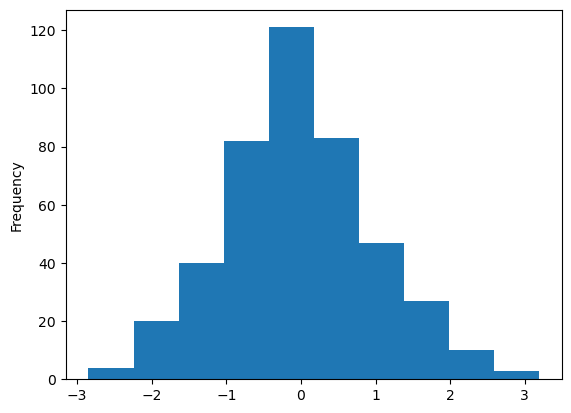

Ever had known person concerned about, or recommend reduction of, alcohol consumption: No


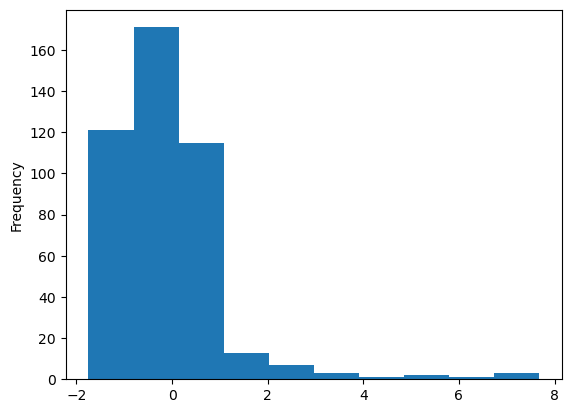

Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year


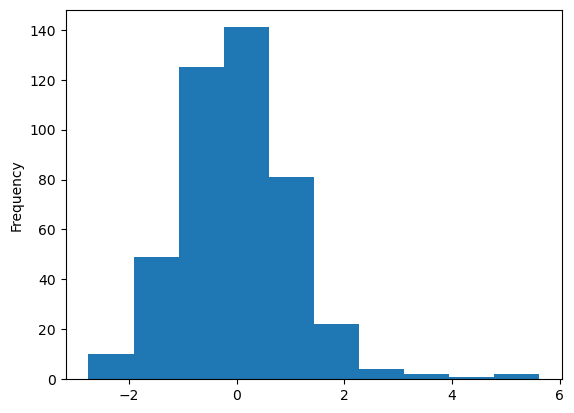

Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year


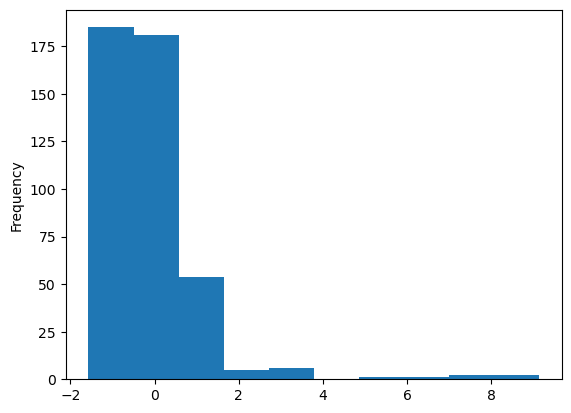

Total cholesterol


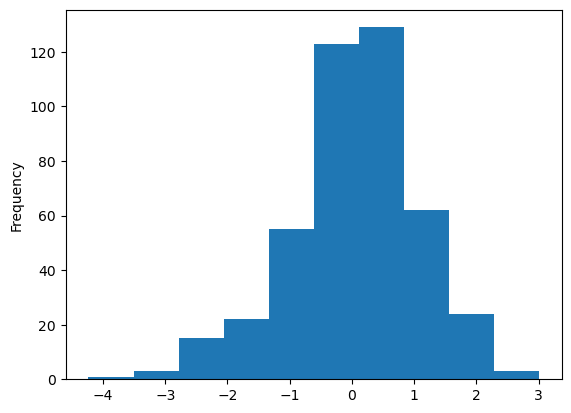

HDL cholesterol


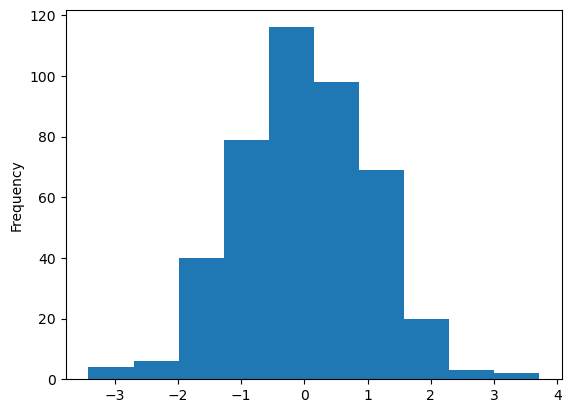

LDL cholesterol


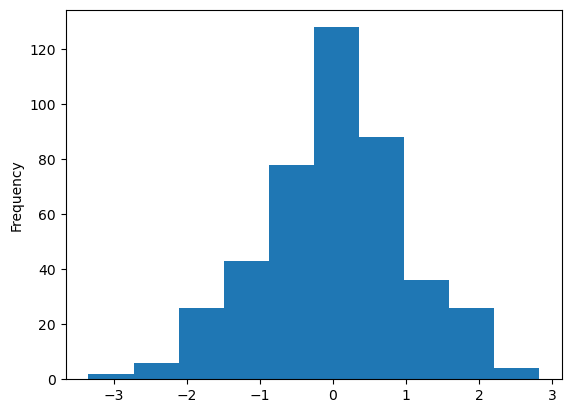

triglycerides


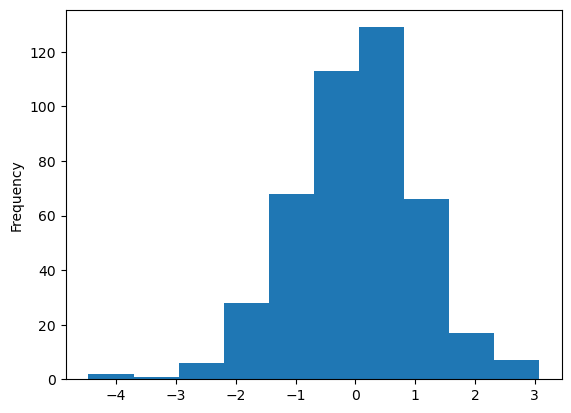

Cigarettes per Day


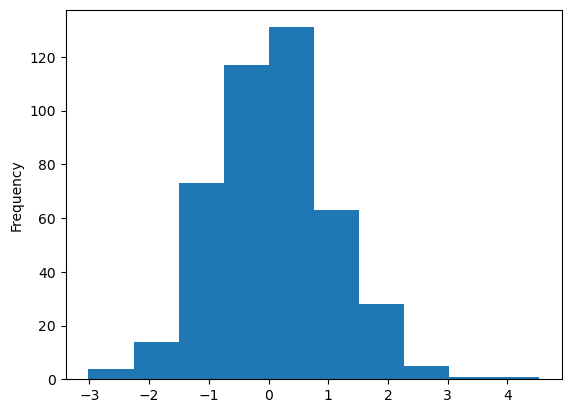

systolic blood pressure


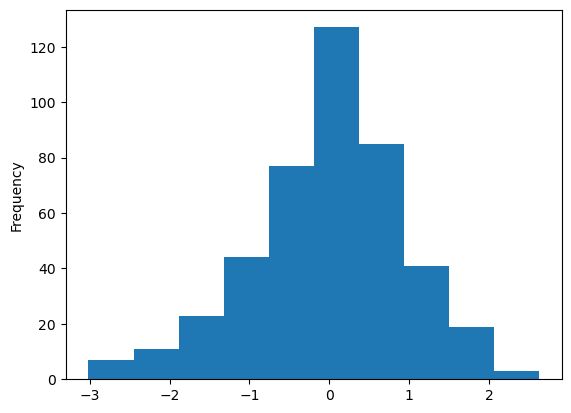

diastolic blood pressure


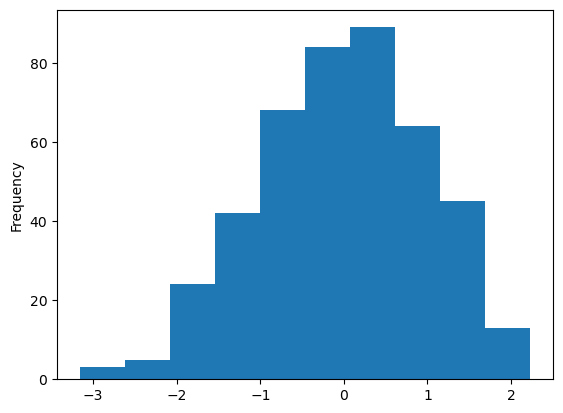

Hearing difficulty/problems: Yes


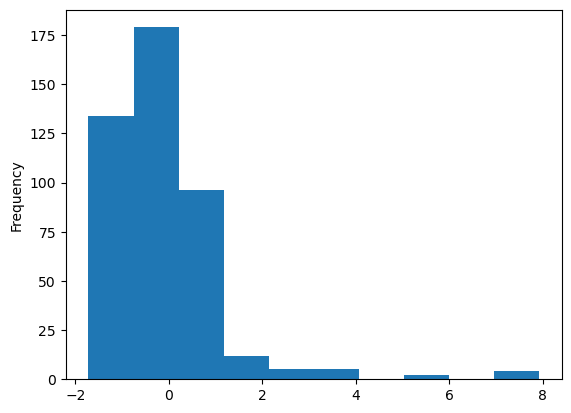

Non-cancer illness code, self-reported: depression


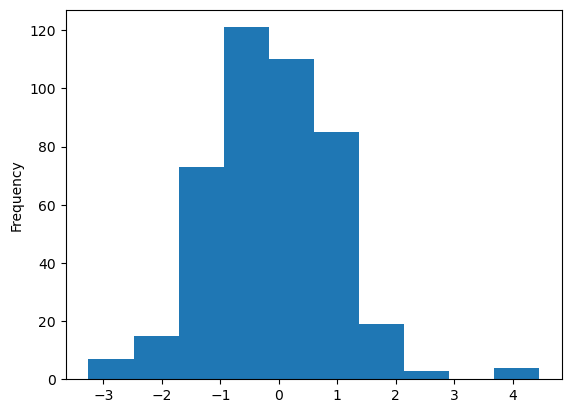

Non-oily fish intake


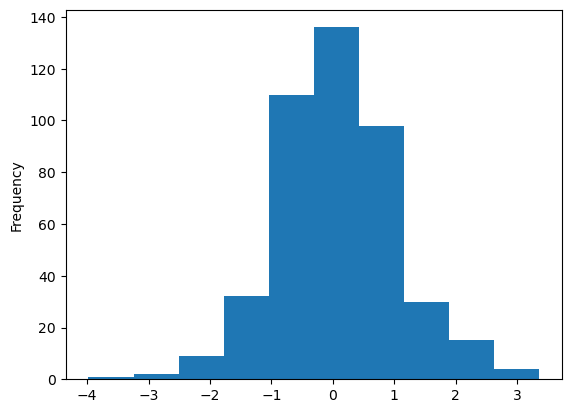

Hearing difficulty/problems with background noise


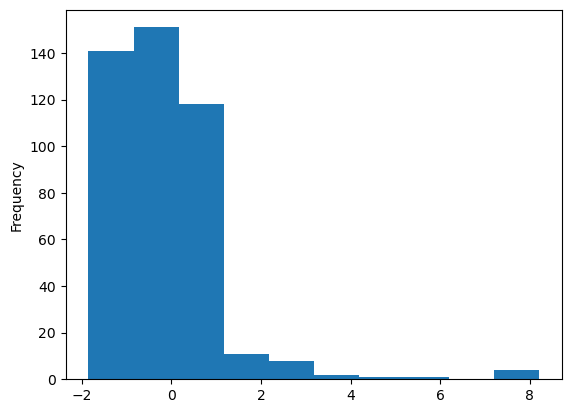

Body mass index (BMI)


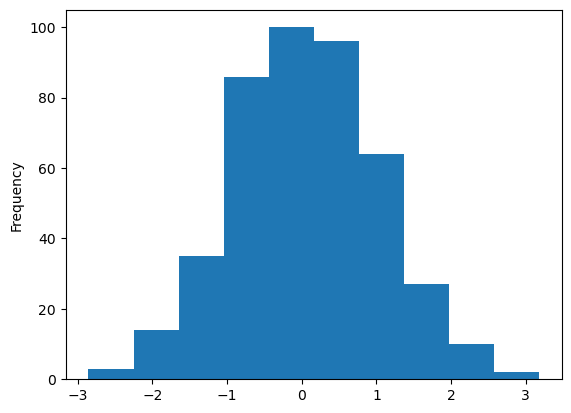

Oily fish intake


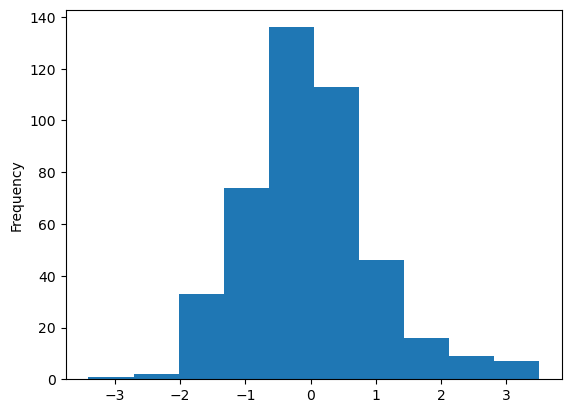

Sleeplessness / insomnia


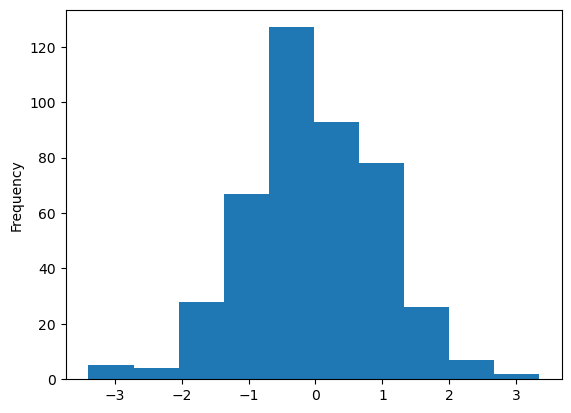

Sleep duration


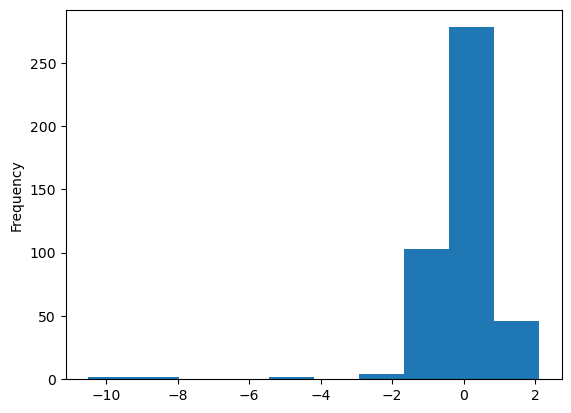

Age completed full time education


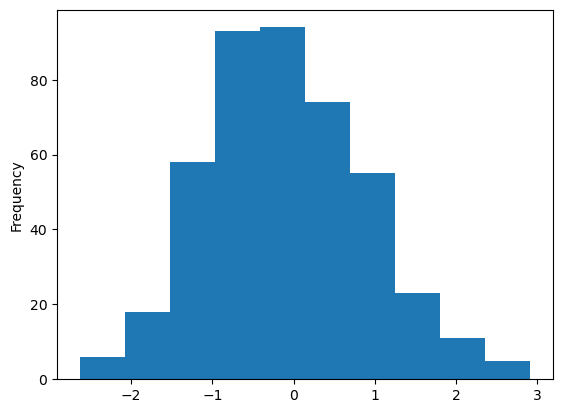

Processed meat intake


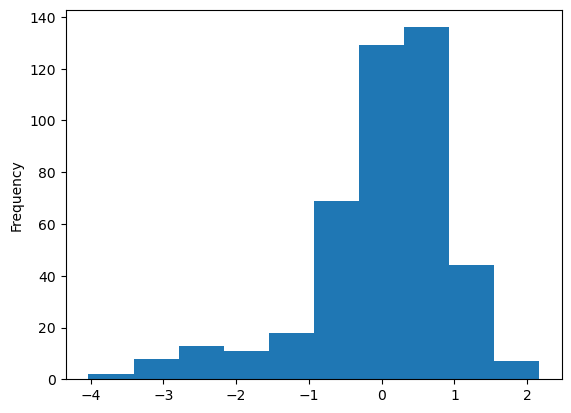

Types of physical activity in last 4 weeks: Strenuous sports


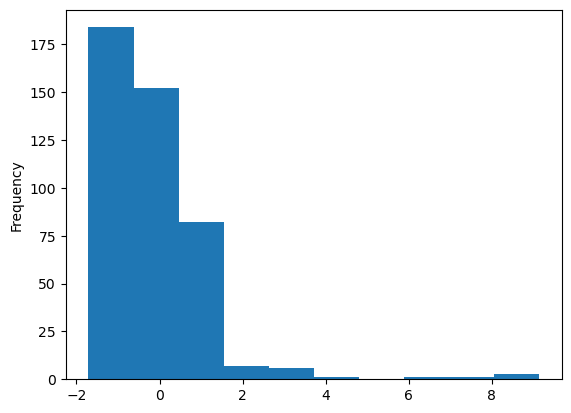

Other meat intake


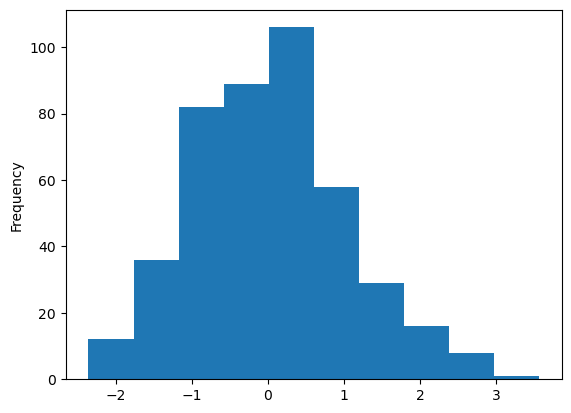

Loneliness, isolation


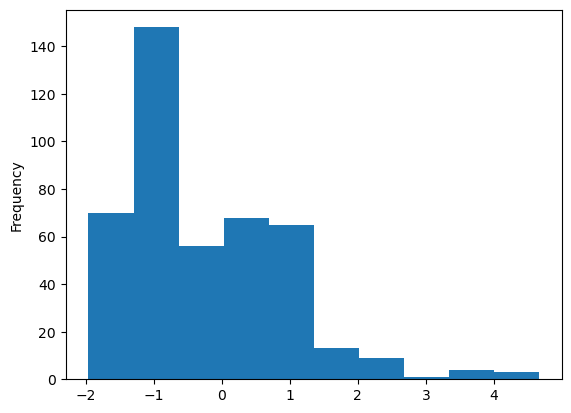

Illnesses of father: Alzheimer's disease/dementia


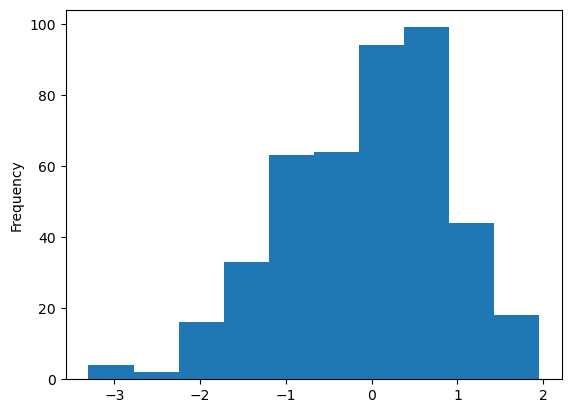

Illnesses of mother: Alzheimer's disease/dementia


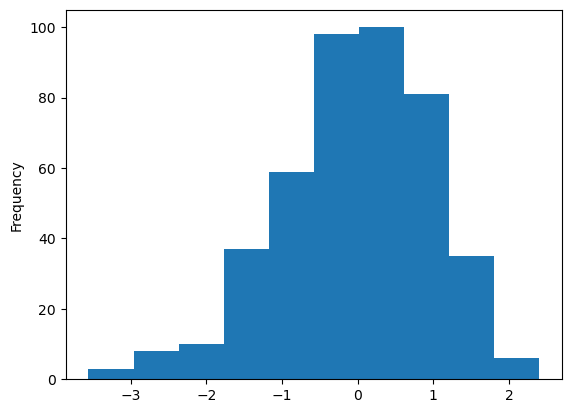

Mood swings


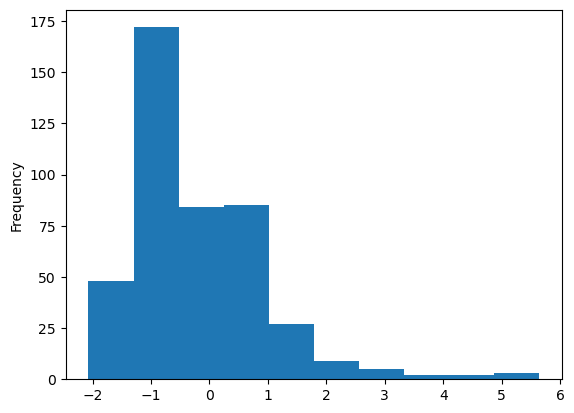

Non-cancer illness code, self-reported: anxiety/panic attacks


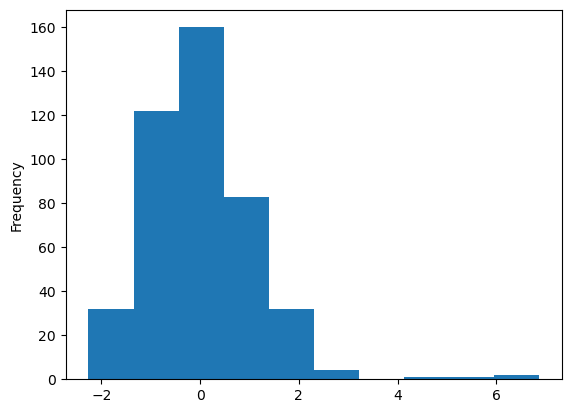

Non-cancer illness code, self-reported: stroke


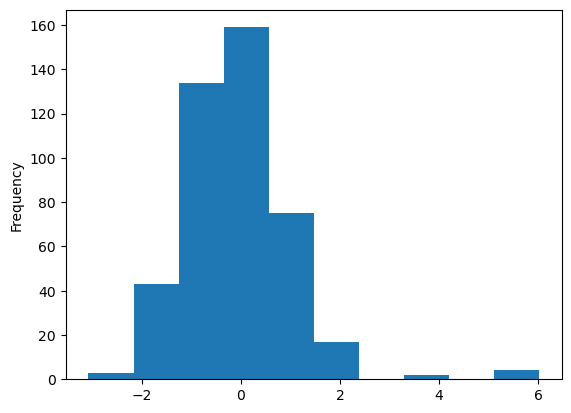

Non-cancer illness code, self-reported: head injury


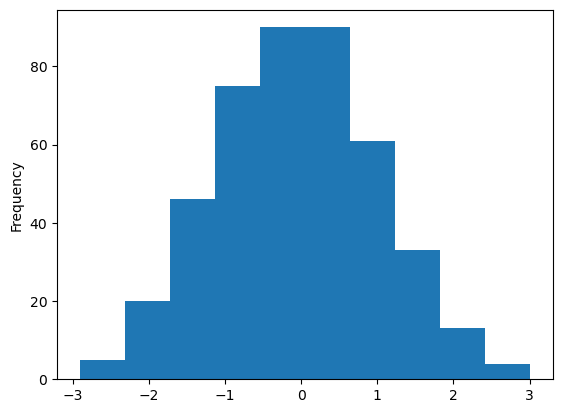

Alcohol intake frequency


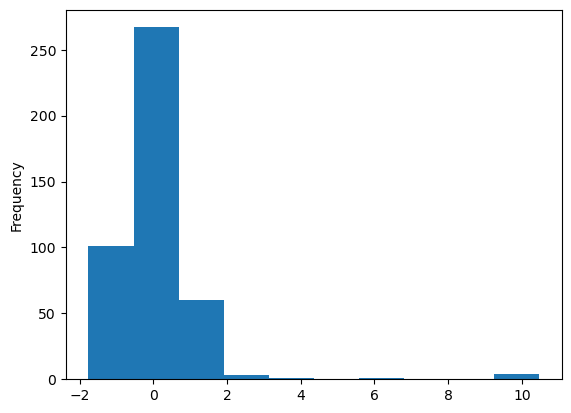

Diagnoses - secondary ICD10: E66.9 Obesity, unspecified


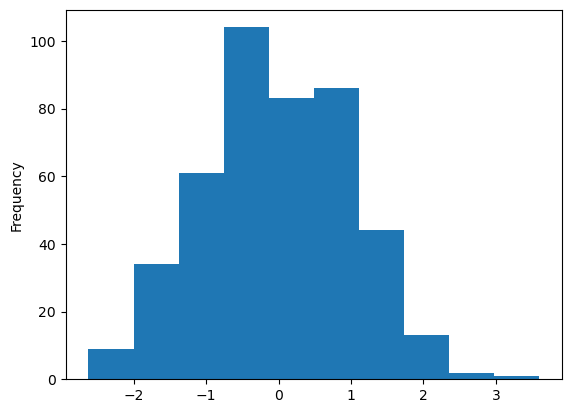

Non-cancer illness code, self-reported: hypothyroidism/myxoedema


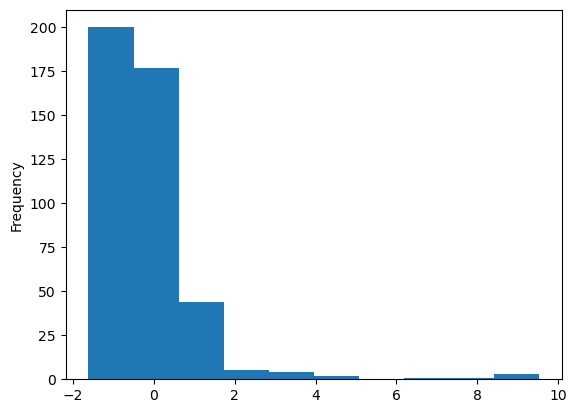

Non-cancer illness code, self-reported: hyperthyroidism/thyrotoxicosis


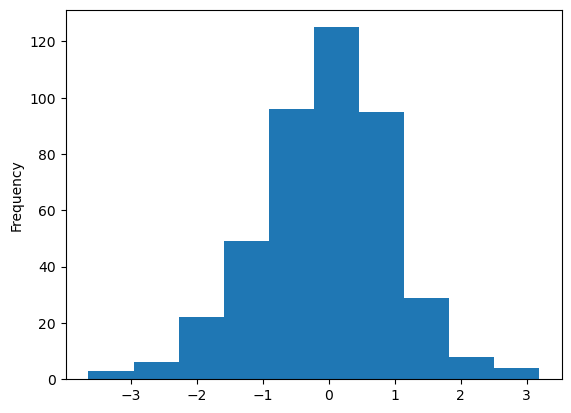

Non-cancer illness code, self-reported: hypertension


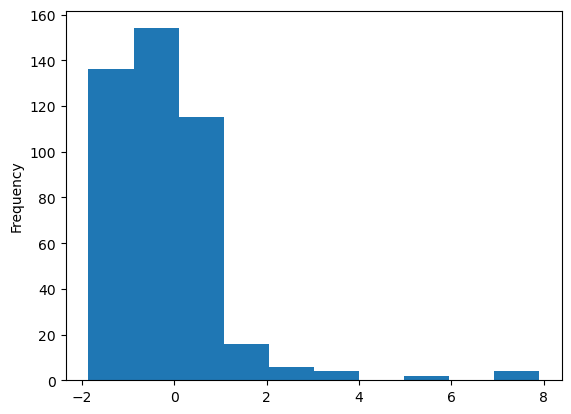

Particulate matter air pollution 2.5-10um; 2010


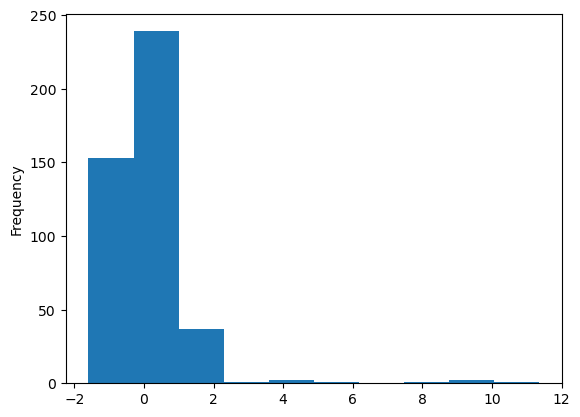

Nitrogen oxides air pollution; 2010


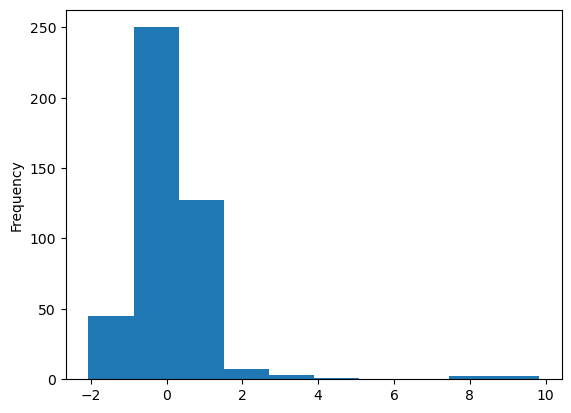

Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)


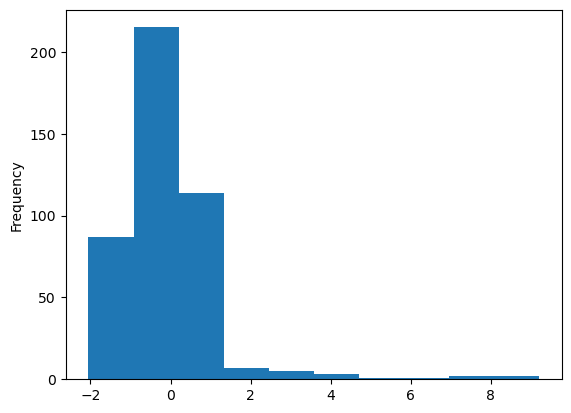

Diagnoses - secondary ICD10: I10 Essential (primary) hypertension


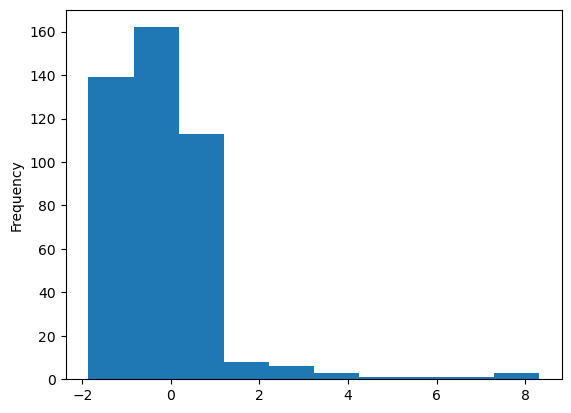

Prospective memory result


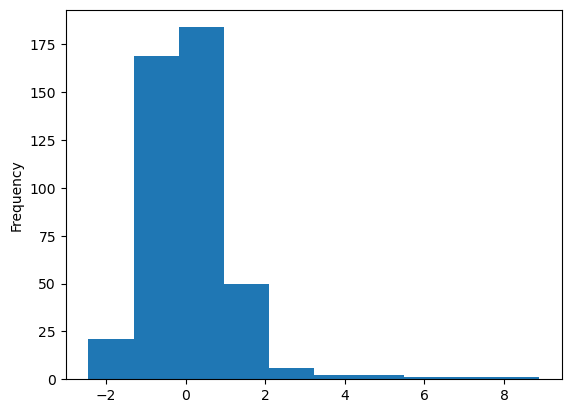

Leisure/social activities: Pub or social club


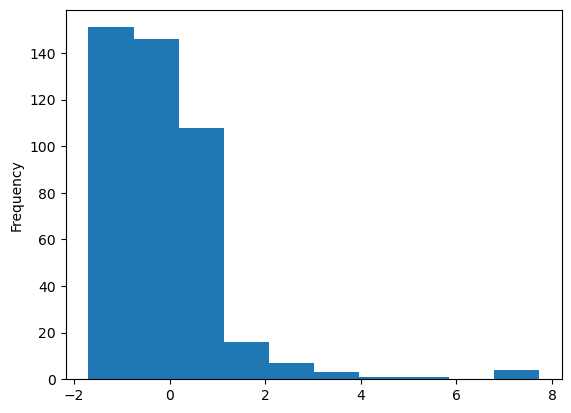

Leisure/social activities: Sports club or gym


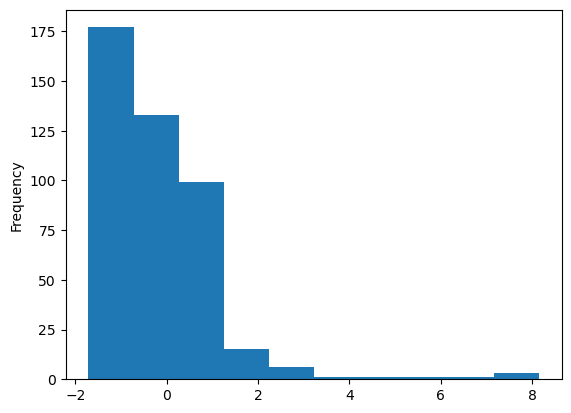

Mental health problems ever diagnosed by a professional: Social anxiety or social phobia


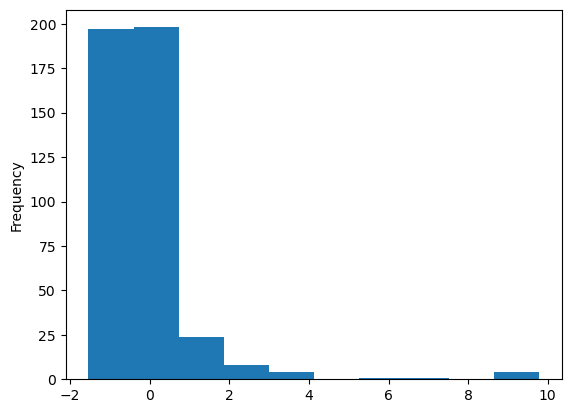

Mental health problems ever diagnosed by a professional: Anxiety, nerves or generalized anxiety disorder


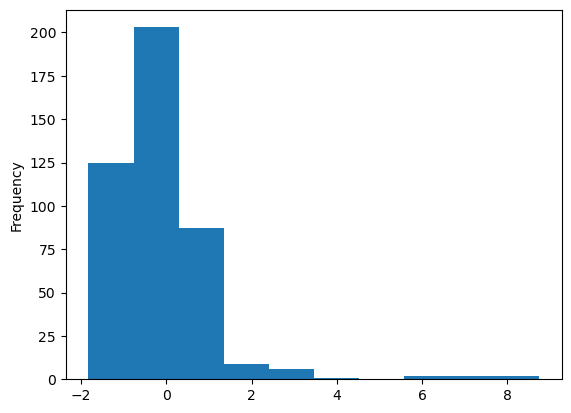

Operation code: brain surgery


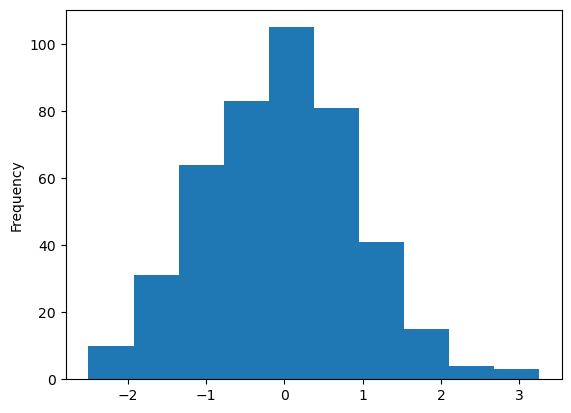

Ever had prolonged loss of interest in normal activities


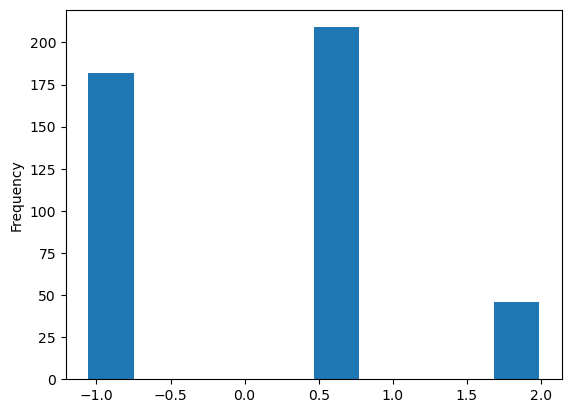

Illness, injury, bereavement, stress in last 2 years: Serious illness, injury or assault to yourself


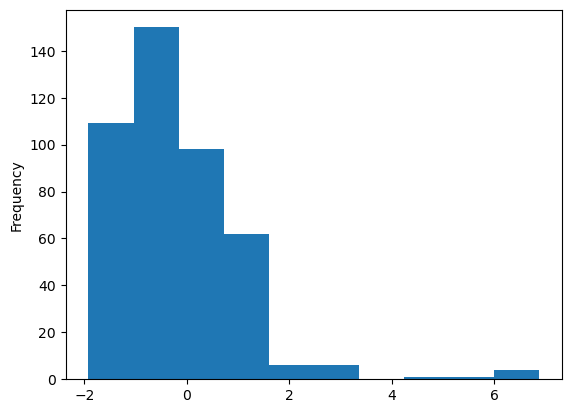

Illness, injury, bereavement, stress in last 2 years: Marital separation/divorce


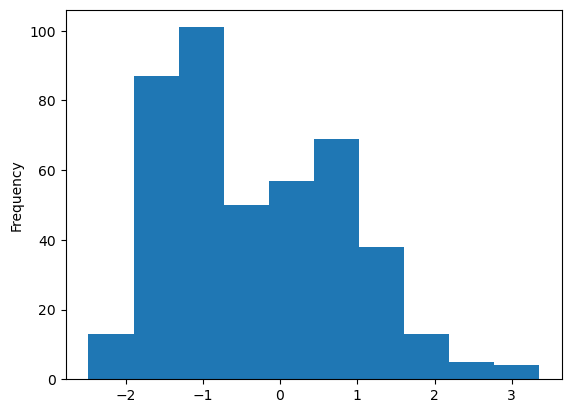

Illness, injury, bereavement, stress in last 2 years: Financial difficulties


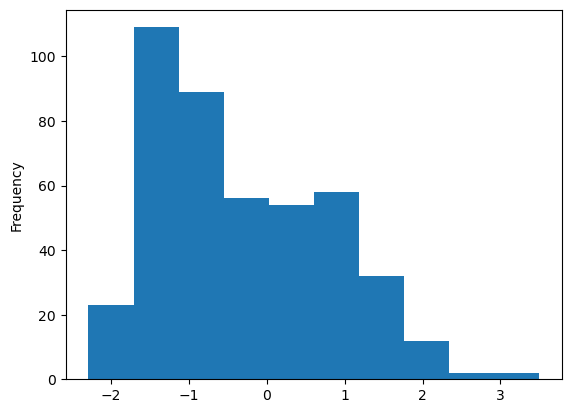

ADHD


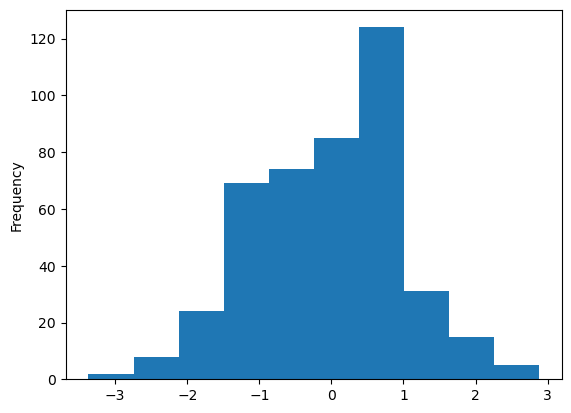

Microalbumin in urine


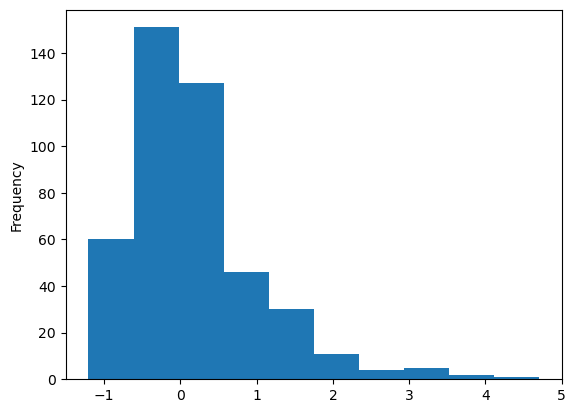

gender


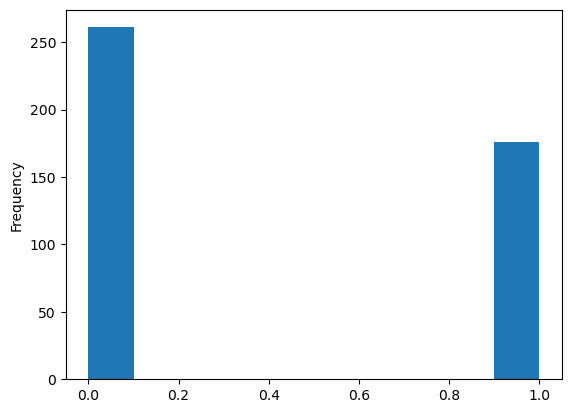

age


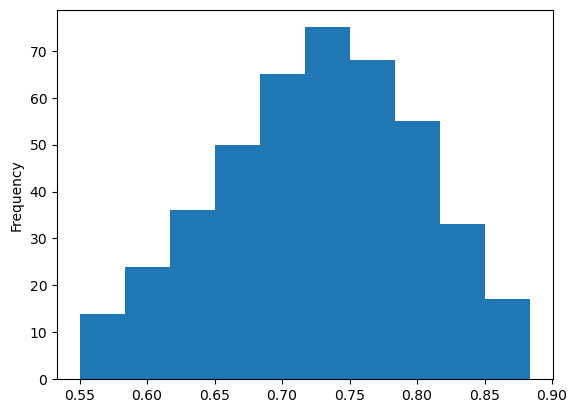

output


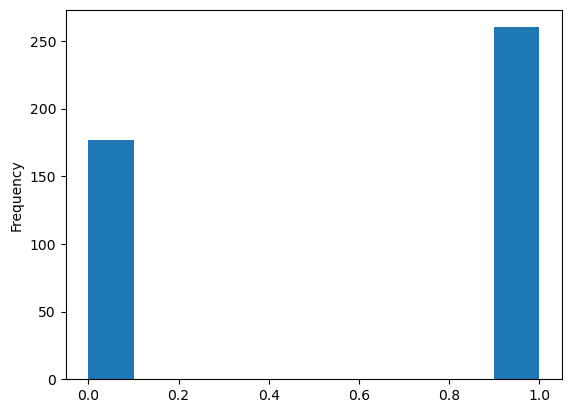

In [37]:
# print(df.head())
column_list = shuffled.columns
for i in column_list:
    print(i)
    shuffled[i].plot(kind="hist")
    plt.show()

**check distribution for positive and negative output with parents' Alzheimer PRS**

negative PRS values for negative output among  177  samples
Illnesses of father: Alzheimer's disease/dementia    75
Illnesses of mother: Alzheimer's disease/dementia    82
dtype: int64
Illnesses of father: Alzheimer's disease/dementia


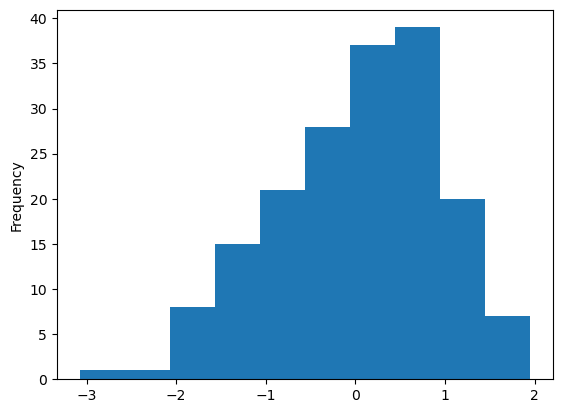

Illnesses of mother: Alzheimer's disease/dementia


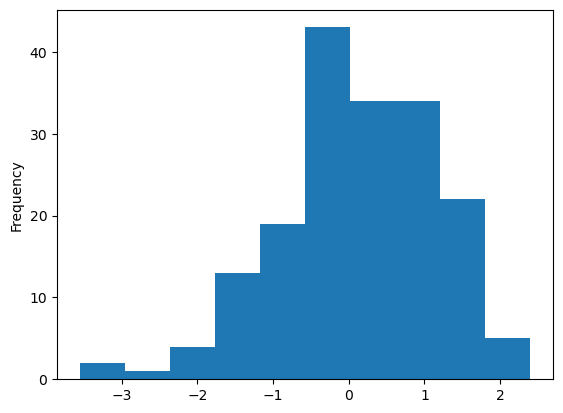

In [38]:
cols_to_check = ["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia"]
shuffled_neg = shuffled[shuffled['output'] == 0]


print('negative PRS values for negative output among ', shuffled_neg.shape[0], " samples")
print( shuffled_neg[cols_to_check].lt(0).sum() )

for i in cols_to_check:
    print(i)
    shuffled_neg[i].plot(kind="hist")
    plt.show()

negative PRS values for positive output among  260  samples
Illnesses of father: Alzheimer's disease/dementia    137
Illnesses of mother: Alzheimer's disease/dementia    130
dtype: int64
Illnesses of father: Alzheimer's disease/dementia


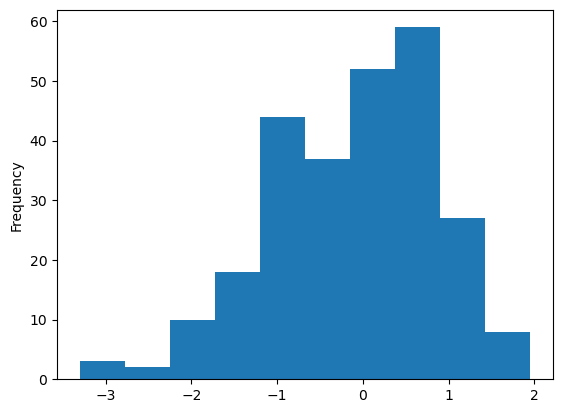

Illnesses of mother: Alzheimer's disease/dementia


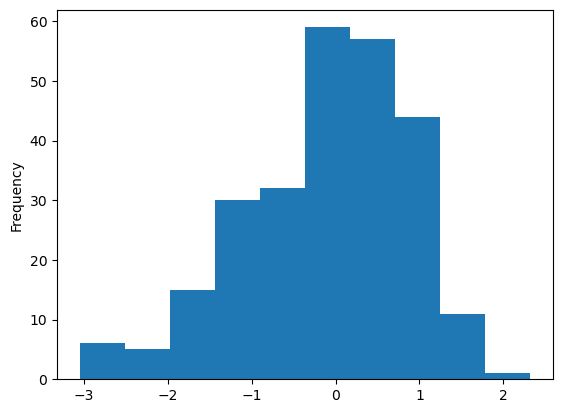

In [39]:
cols_to_check = ["Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia"]
shuffled_pos = shuffled[shuffled['output'] == 1]


print('negative PRS values for positive output among ', shuffled_pos.shape[0], " samples")
print( shuffled_pos[cols_to_check].lt(0).sum() )

for i in cols_to_check:
    print(i)
    shuffled_pos[i].plot(kind="hist")
    plt.show()

# Feature Selection
https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

In [40]:
selected_features = []

# Filter methods
Filter methods pick up the intrinsic properties of the features measured via univariate statistics instead of cross-validation performance. These methods are faster and less computationally expensive than wrapper methods. When dealing with high-dimensional data, it is computationally cheaper to use filter methods.

**Information Gain**

Information gain calculates the reduction in entropy from the transformation of a dataset. It can be used for feature selection by evaluating the Information gain of each variable in the context of the target variable.

['Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Hearing difficulty/problems: Yes', 'Hearing difficulty/problems with background noise', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', 'Mood swings', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 'Leisure/social activities: Sports club or gym', 'Mental health problems ever diagnosed by a professional: Social anxiety or social phobia', 'Illness, injury, bereavement, stress in last 2 years: Marital separation/divorce', 'Illness, injury, bereavement, stress in last 2 years: Financial difficulties']


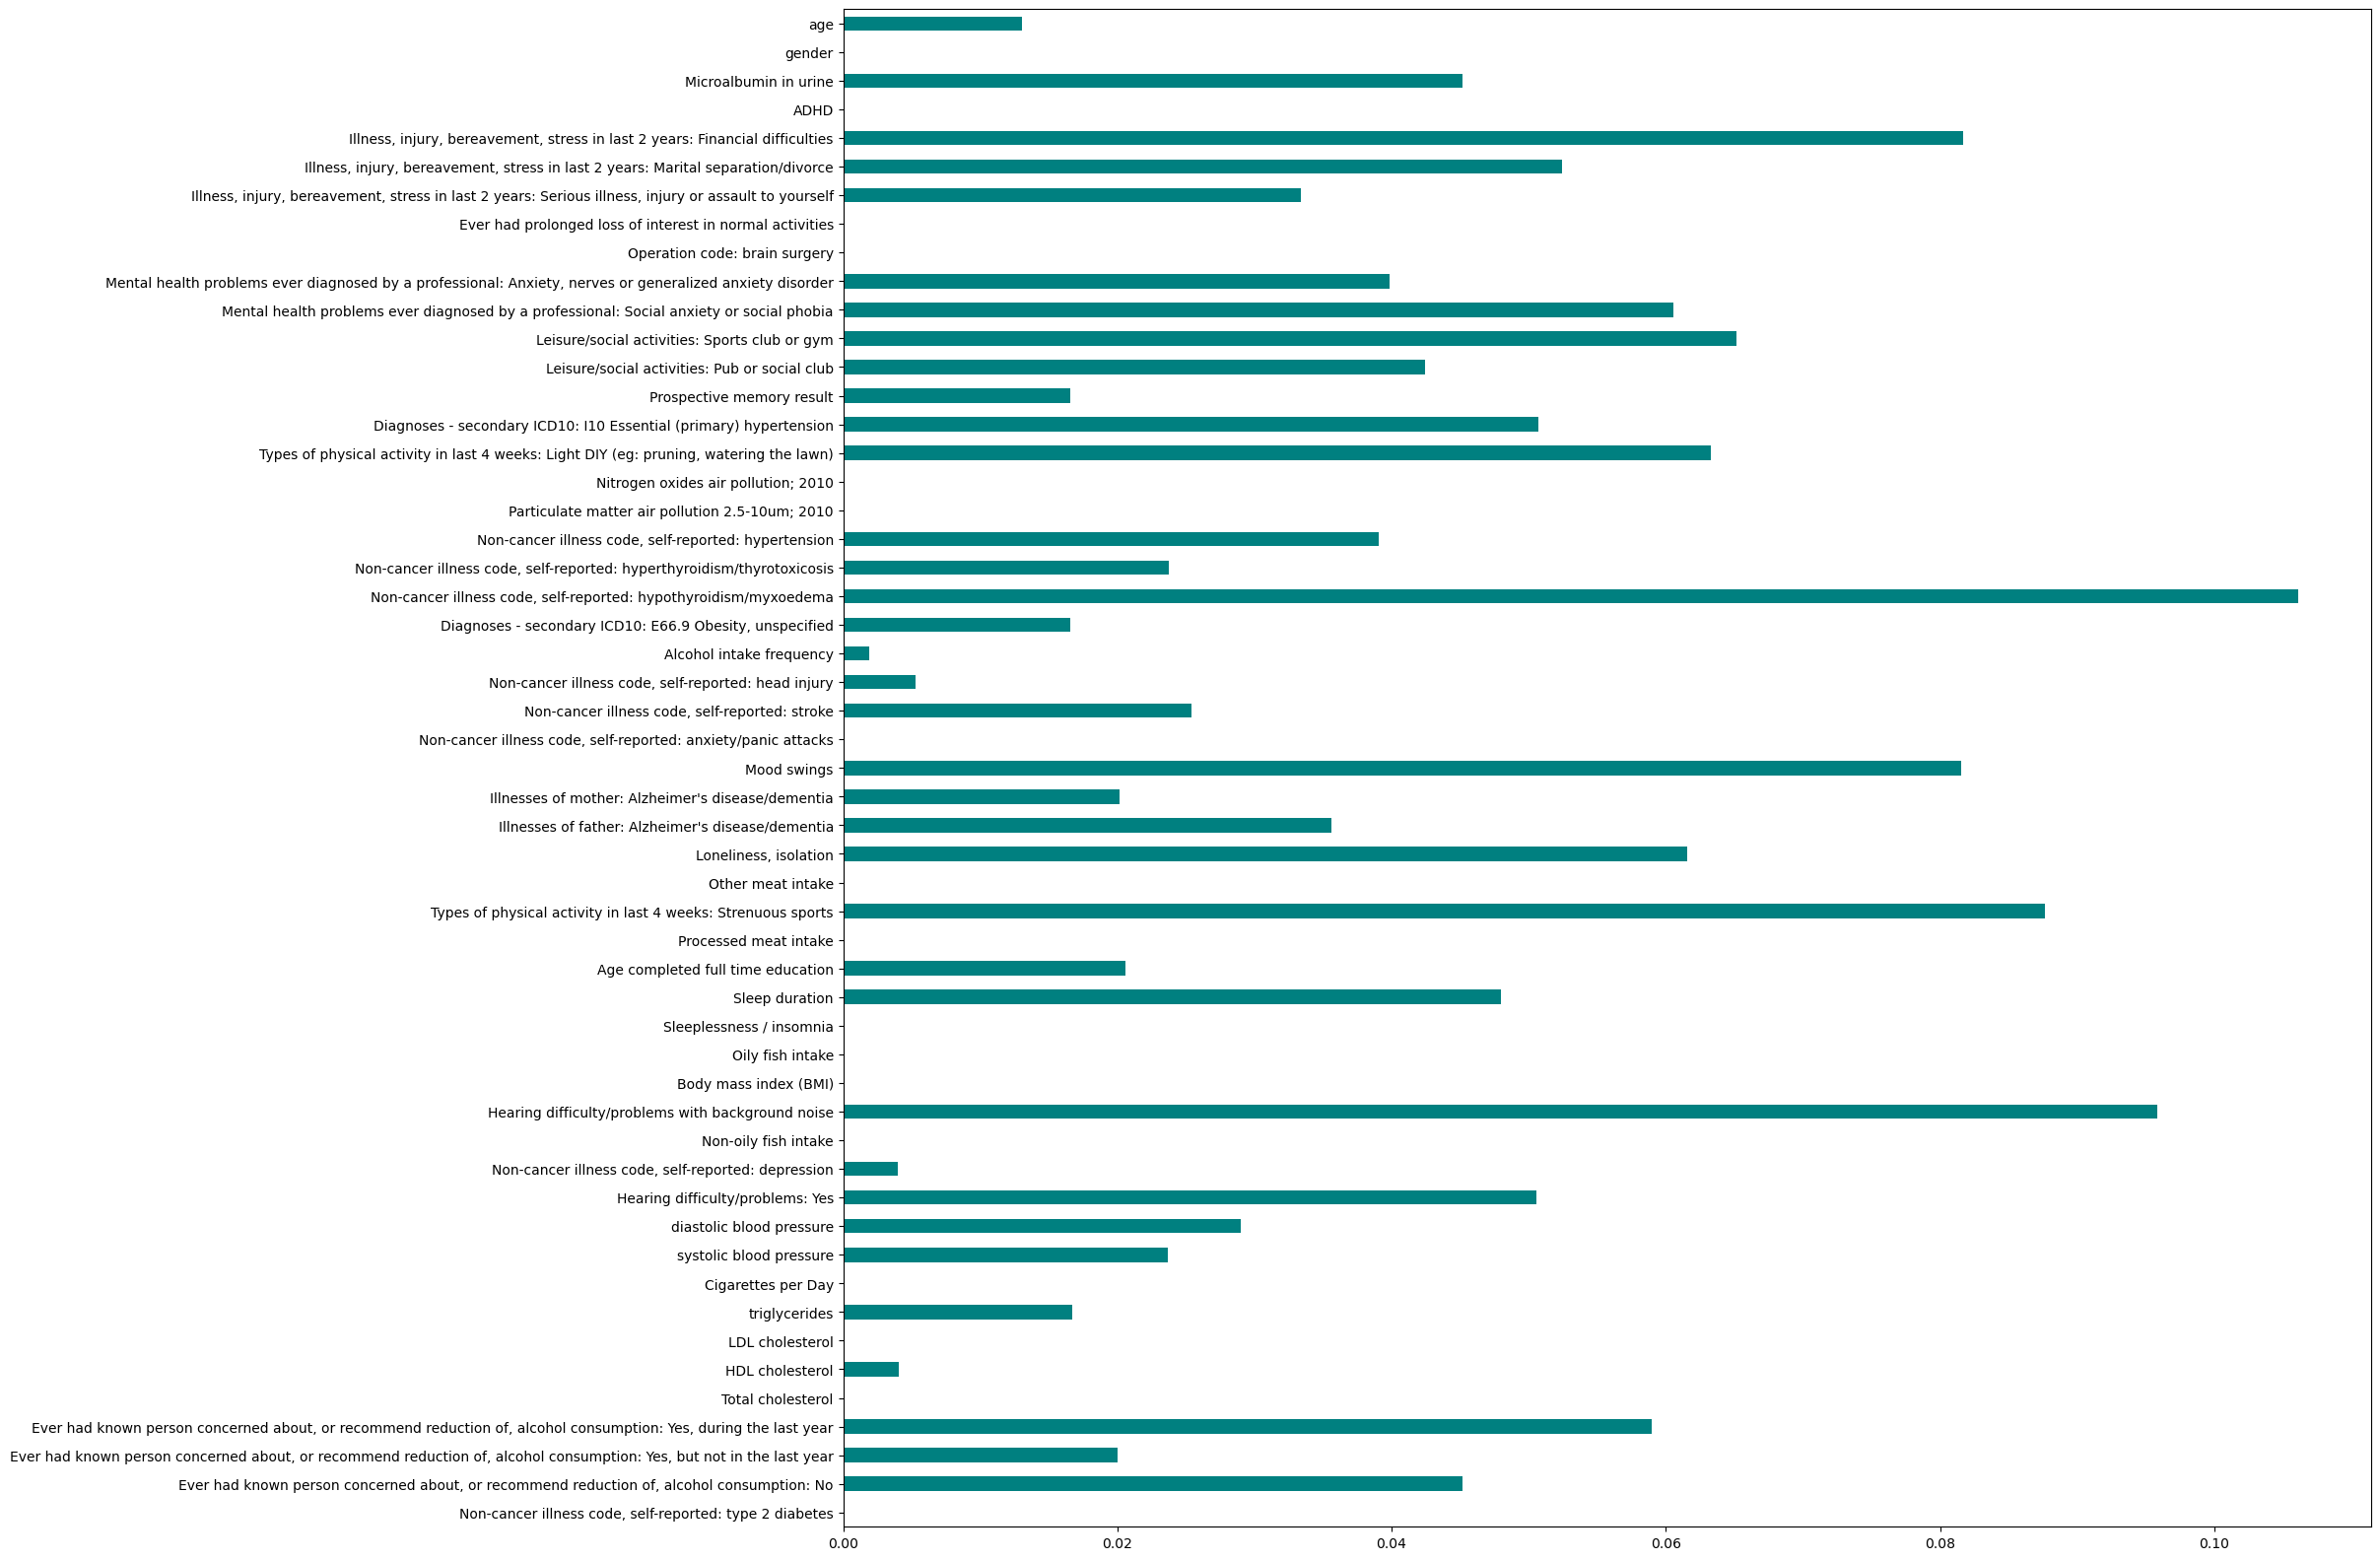

In [41]:
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

figure(figsize=(20, 20), dpi=100)

importances = mutual_info_classif(shuffled_X, shuffled_Y)
feat_importances = pd.Series(importances, shuffled.columns[ 0:len(shuffled.columns) - 1 ] )
important_features = []
count = 0
for elem in feat_importances:
    if elem > 0.05:
        important_features.append(shuffled.columns[count])
    count += 1
print(important_features)

selected_features += important_features
# print(selected_features)

feat_importances.plot( kind = 'barh', color = 'teal' )
plt.show()

**Correlation Coefficient**


<AxesSubplot: >

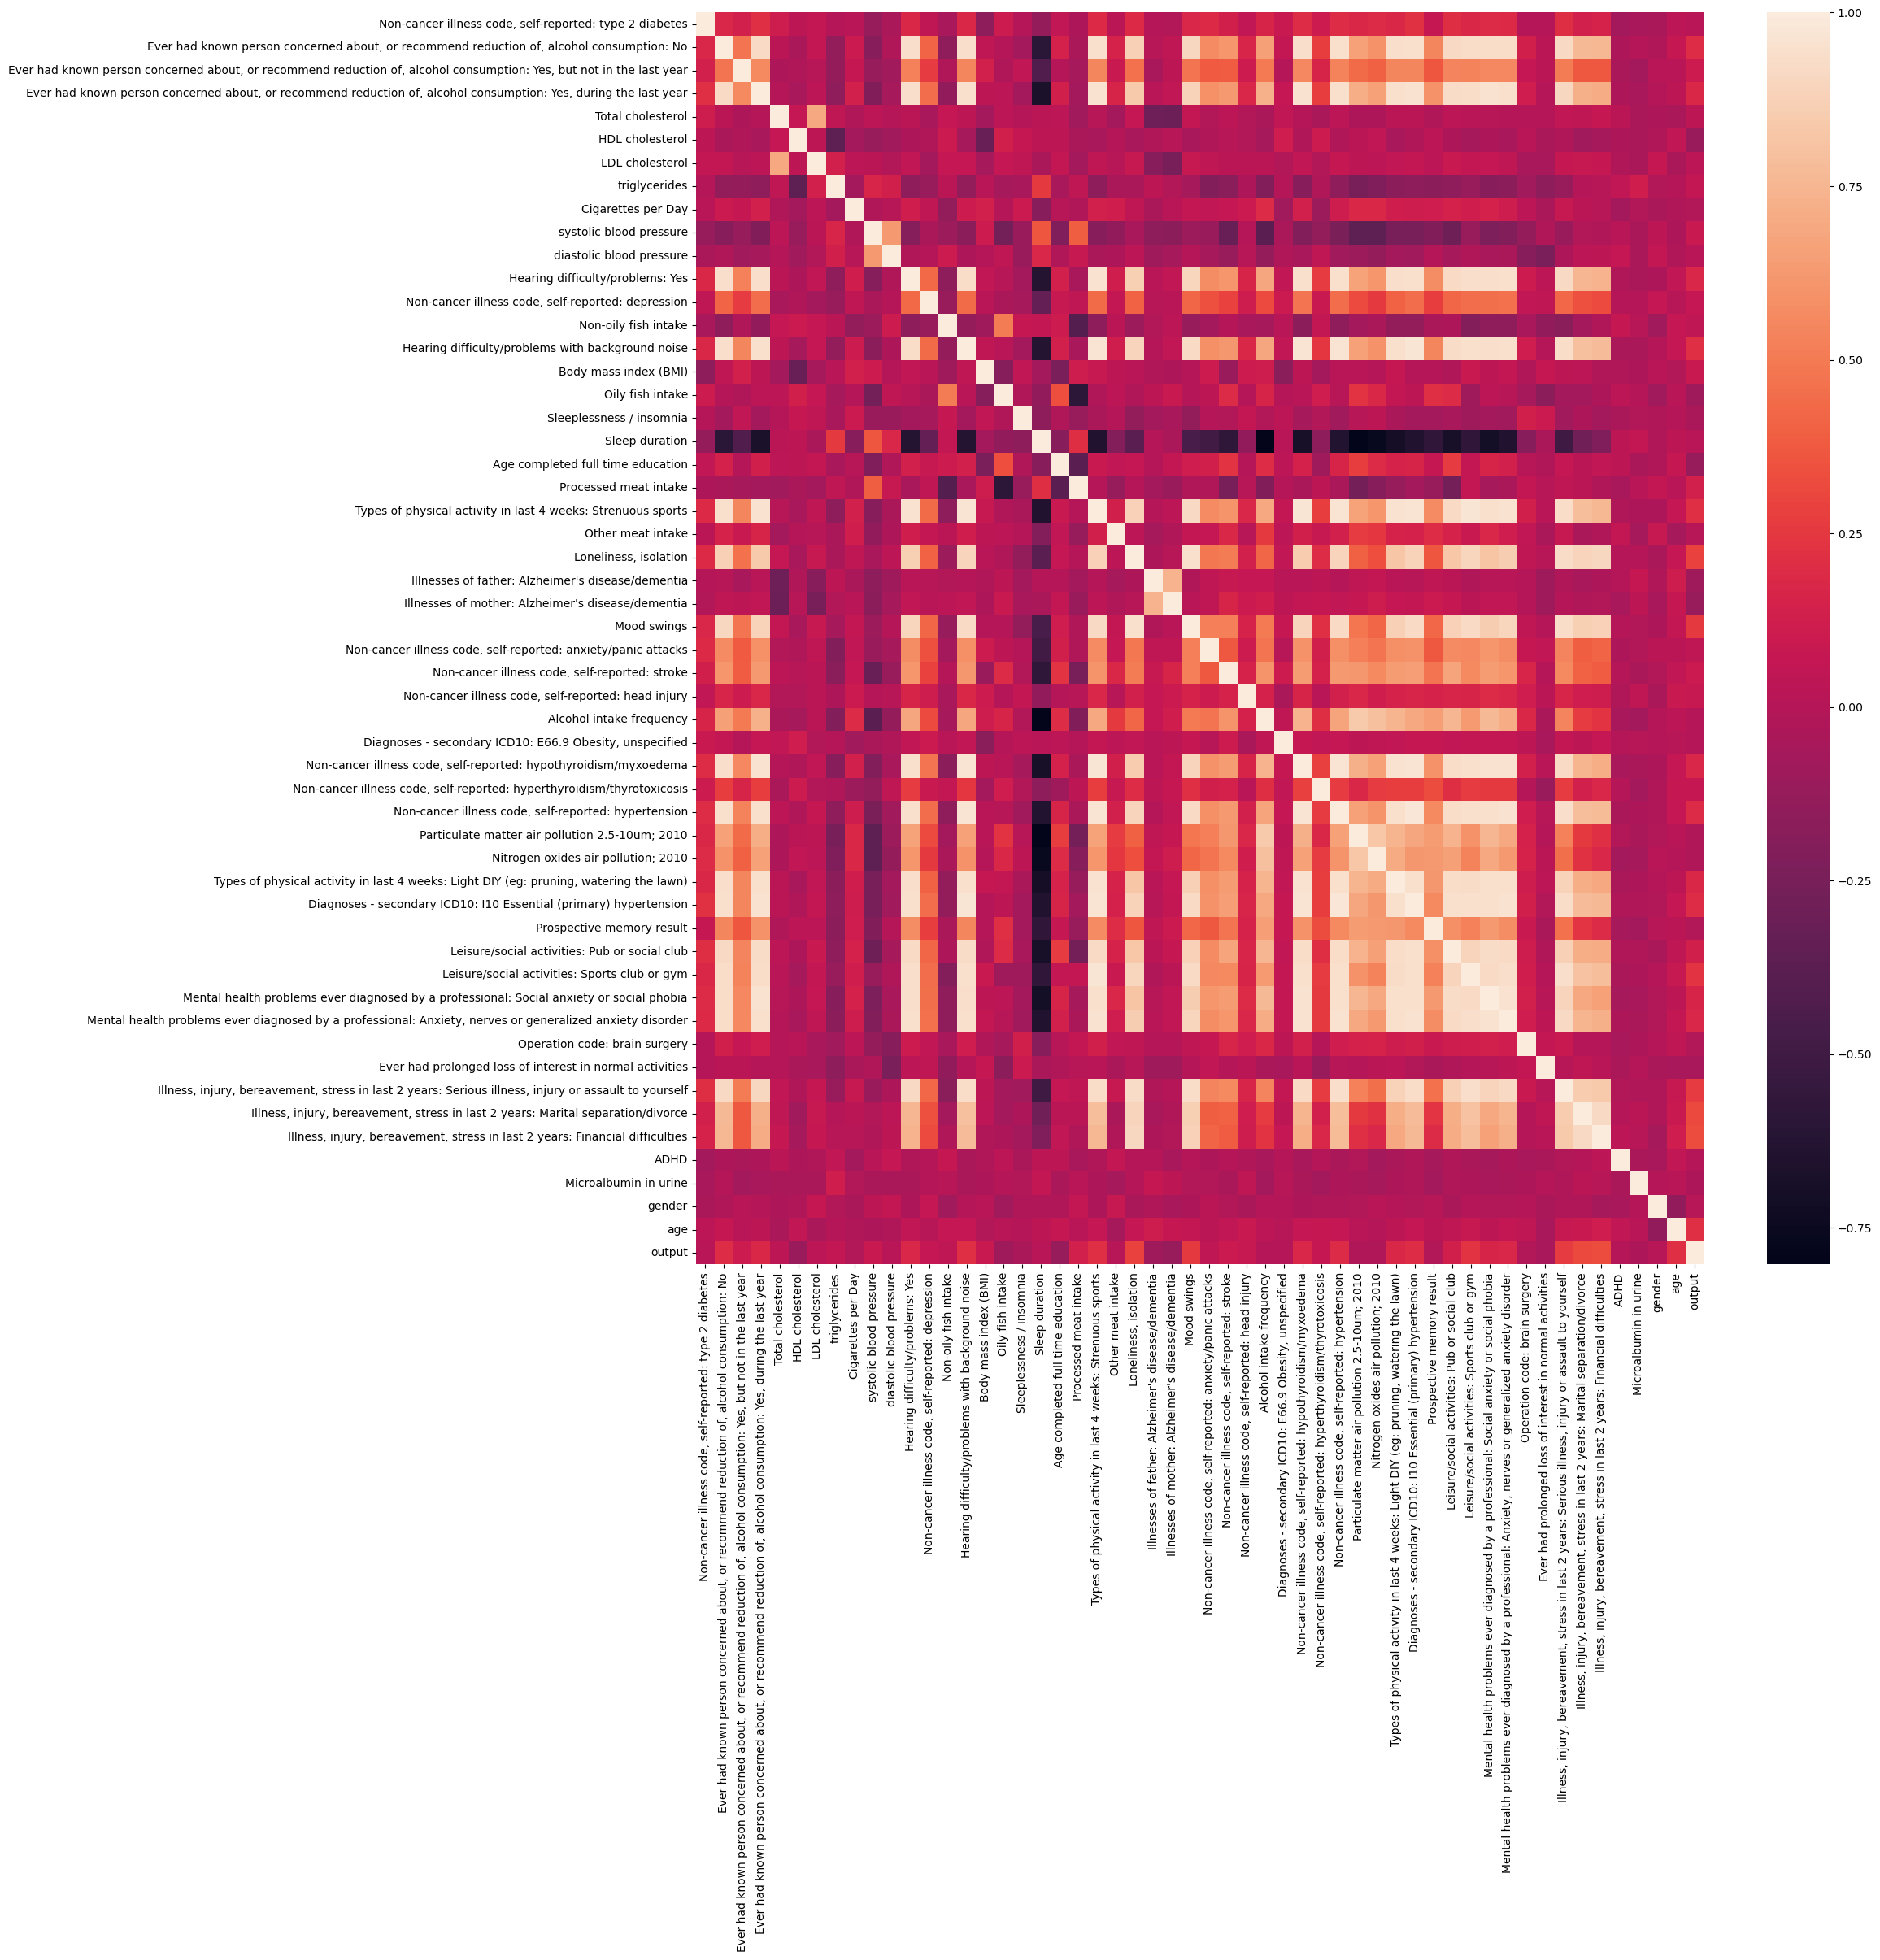

In [42]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
corr = shuffled.corr()
sns.heatmap( corr )

In [43]:
print(corr)

                                                    Non-cancer illness code, self-reported: type 2 diabetes  \
Non-cancer illness code, self-reported: type 2 ...                                           1.000000         
Ever had known person concerned about, or recom...                                           0.170454         
Ever had known person concerned about, or recom...                                           0.137141         
Ever had known person concerned about, or recom...                                           0.215429         
Total cholesterol                                                                            0.106394         
HDL cholesterol                                                                              0.041300         
LDL cholesterol                                                                              0.060644         
triglycerides                                                                               -0.006083         
C

**Still Alzheimer of parents show negative correlation:**
    1. Lack of Diagnosis for parents.
    2. Less patients overall earlier.
    3. Lack of such patients in this dataset

In [44]:
print(corr.iloc[0][0])
features_selected = []
column_len = len( shuffled.columns )
output_idx = column_len - 1

for i in range( column_len ): 
    if (corr.iloc[i][output_idx] > 0.1 ) and i != output_idx :
        features_selected.append(shuffled.columns[i])
print(features_selected)

selected_features += features_selected

1.0
['Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Hearing difficulty/problems: Yes', 'Hearing difficulty/problems with background noise', 'Processed meat intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', 'Mood swings', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 'Leisure/social activities: Pub or social club', 'Leisure/social activities: Sports club or gym', 'Mental health problems ever diagnosed by a professional: Social an

**Variance Threshold**

The variance threshold is a simple baseline approach to feature selection. It removes all features which variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e., features that have the same value in all samples. We assume that features with a higher variance may contain more useful information, but note that we are not taking the relationship between feature variables or feature and target variables into account, which is one of the drawbacks of filter methods.

In [45]:
from sklearn.feature_selection import VarianceThreshold

# remove features with variance less than 0.1
v_threshold = VarianceThreshold( threshold = 0.1 )
v_threshold.fit(shuffled_X)
print( v_threshold.get_support() )
rejected_col = [x for x, y in zip(shuffled_X.columns, v_threshold.get_support() ) if y == False]
print(rejected_col)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True False]
['age']


Makes sense as most of the age is very high for AD patients. No need to reject the "age" column

**Mean Absolute Difference (MAD)**

The mean absolute difference (MAD) computes the absolute difference from the mean value. The main difference between the variance and MAD measures is the absence of the square in the latter. The MAD, like the variance, is also a scale variant.’ This means that higher the MAD, higher the discriminatory power.

<BarContainer object of 53 artists>

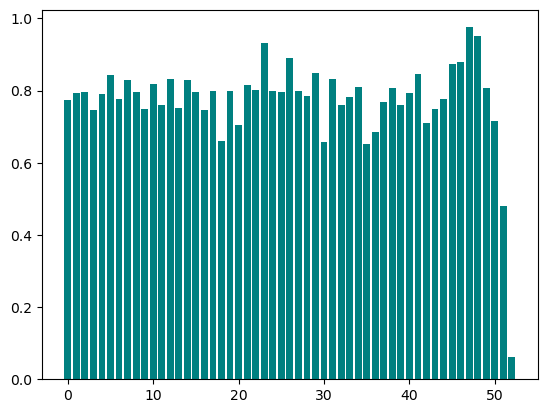

In [46]:
mean_abs_diff = np.sum( np.abs( shuffled_X - np.mean(shuffled_X, axis = 0 ) ), axis = 0 ) / shuffled_X.shape[0]

plt.bar( np.arange( shuffled_X.shape[1] ), mean_abs_diff, color = 'teal' )

# Wrapper Methods

Wrappers require some method to search the space of all possible subsets of features, assessing their quality by learning and evaluating a classifier with that feature subset. The feature selection process is based on a specific machine learning algorithm that we are trying to fit on a given dataset. It follows a greedy search approach by evaluating all the possible combinations of features against the evaluation criterion. The wrapper methods usually result in better predictive accuracy than filter methods.

**Forward Feature Selection**

http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html

This is an iterative method wherein we start with the best performing variable against the target. Next, we select another variable that gives the best performance in combination with the first selected variable. This process continues until the preset criterion is achieved.

In [47]:
from mlxtend.feature_selection import SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(shuffled_X, shuffled_Y)

ffs = SequentialFeatureSelector( rfc, k_features = 'best', forward = True, n_jobs = -1 )
ffs.fit(shuffled_X, shuffled_Y)
features = list( ffs.k_feature_names_ )
print(features)
print( len( features ) )

selected_features += features
# print(selected_features)

['HDL cholesterol', 'Cigarettes per Day', 'Non-cancer illness code, self-reported: depression', 'Mood swings', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Illness, injury, bereavement, stress in last 2 years: Financial difficulties', 'gender']
7


**Backward Feature Elimination**

This method works exactly opposite to the Forward Feature Selection method. Here, we start with all the features available and build a model. Next, we remove the variable from the model which gives the best evaluation measure value. This process is continued until the preset criterion is achieved.

In [48]:
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector

lr = LogisticRegression( class_weight = 'balanced', solver = 'lbfgs', random_state = 42, n_jobs = -1, max_iter = 500 )
lr.fit(shuffled_X, shuffled_Y)

bfs = SequentialFeatureSelector( lr, k_features = 'best', forward = False, n_jobs = -1 )
bfs.fit(shuffled_X, shuffled_Y)
features = list( bfs.k_feature_names_ )
print(features)
print( len( features ) )

selected_features += features
# print(selected_features)

['HDL cholesterol', 'Non-oily fish intake', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Loneliness, isolation', "Illnesses of mother: Alzheimer's disease/dementia", 'Alcohol intake frequency', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Leisure/social activities: Pub or social club', 'Mental health problems ever diagnosed by a professional: Anxiety, nerves or generalized anxiety disorder', 'Illness, injury, bereavement, stress in last 2 years: Serious illness, injury or assault to yourself', 'Illness, injury, bereavement, stress in last 2 years: Financial difficulties', 'Microalbumin in urine']
13


**Exhaustive Feature Selection**

This is the most robust feature selection method covered so far. This is a brute-force evaluation of each feature subset. This means that it tries every possible combination of the variables and returns the best performing subset.

In [49]:
# from mlxtend.feature_selection import ExhaustiveFeatureSelector

# from sklearn.ensemble import RandomForestClassifier

# efs = ExhaustiveFeatureSelector( RandomForestClassifier(), min_features = 8, max_features = 10, scoring = 'roc_auc', cv = 2)
# efs.fit(shuffled_X, shuffled_Y)

# selected_features = shuffled_X.columns[list(efs.best_idx_)]
# print(selected_features)

# print(efs.best_score_)

**Recursive Feature Elimination**

‘Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination (RFE) is to select features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features and the importance of each feature is obtained either through a coef_ attribute or through a feature_importances_ attribute.

Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.’

In [50]:
from sklearn.feature_selection import RFE
# here lr denotes the logistic regression model trained on backward elimination
rfe = RFE(lr, n_features_to_select = 10)
rfe.fit(shuffled_X, shuffled_Y)
selected_col = [ x for x, y in zip(shuffled_X.columns, rfe.support_ )  if y == True ]
print(selected_col)
print( len (selected_col ) )
print(rfe.ranking_)

selected_features += selected_col 
# print(selected_features)

['Hearing difficulty/problems: Yes', 'Loneliness, isolation', 'Alcohol intake frequency', 'Non-cancer illness code, self-reported: hypertension', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Leisure/social activities: Pub or social club', 'Mental health problems ever diagnosed by a professional: Anxiety, nerves or generalized anxiety disorder', 'Illness, injury, bereavement, stress in last 2 years: Serious illness, injury or assault to yourself', 'Illness, injury, bereavement, stress in last 2 years: Financial difficulties', 'age']
10
[37 17 39 34 24  6 41 44 29 13 11  1 36  2 14 26 38 31 22 20  4 42 28  1
 27  7 43  9  8 12  1 35  3 32  1 21 30  1  5 15  1 19 33  1 40 10  1 18
  1 23 16 25  1]


# Embedded Methods

These methods encompass the benefits of both the wrapper and filter methods, by including interactions of features but also maintaining reasonable computational cost. Embedded methods are iterative in the sense that takes care of each iteration of the model training process and carefully extracts those features which contribute the most to the training for a particular iteration.

**LASSO Regularization (L1)**

Regularization consists of adding a penalty to the different parameters of the machine learning model to reduce the freedom of the model, i.e. to avoid over-fitting. In linear model regularization, the penalty is applied over the coefficients that multiply each of the predictors. From the different types of regularization, Lasso or L1 has the property that is able to shrink some of the coefficients to zero. Therefore, that feature can be removed from the model.

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

logistic = LogisticRegression( C = 1, penalty = "l1", solver = 'liblinear', random_state = 7 ).fit(shuffled_X, shuffled_Y )

model = SelectFromModel(logistic, prefit = True )

X_new = model.transform(shuffled_X)

selected_feat = shuffled_X.columns[(model.get_support())]
print(selected_feat)
print( len( selected_feat ) )
# selected_columns = shuffled_X.columns[X_new.var() != 0 ]
# print(selected_columns)
# print( len(selected_columns[0] ) )
# print(type(selected_feat))
# print( selected_feat.tolist() )
selected_features += selected_feat.tolist()

# print(selected_features)

Index(['Non-cancer illness code, self-reported: type 2 diabetes',
       'Total cholesterol', 'HDL cholesterol', 'Cigarettes per Day',
       'systolic blood pressure', 'diastolic blood pressure',
       'Hearing difficulty/problems: Yes',
       'Non-cancer illness code, self-reported: depression',
       'Non-oily fish intake', 'Body mass index (BMI)',
       'Sleeplessness / insomnia', 'Sleep duration',
       'Age completed full time education', 'Processed meat intake',
       'Other meat intake', 'Loneliness, isolation',
       'Illnesses of father: Alzheimer's disease/dementia',
       'Illnesses of mother: Alzheimer's disease/dementia',
       'Non-cancer illness code, self-reported: anxiety/panic attacks',
       'Non-cancer illness code, self-reported: stroke',
       'Non-cancer illness code, self-reported: head injury',
       'Alcohol intake frequency',
       'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified',
       'Non-cancer illness code, self-reported: hypothyr

**Random Forest Importance**

Random Forests is a kind of a Bagging Algorithm that aggregates a specified number of decision trees. The tree-based strategies used by random forests naturally rank by how well they improve the purity of the node, or in other words a decrease in the impurity (Gini impurity) over all trees. Nodes with the greatest decrease in impurity happen at the start of the trees, while notes with the least decrease in impurity occur at the end of trees. Thus, by pruning trees below a particular node, we can create a subset of the most important features.

<AxesSubplot: >

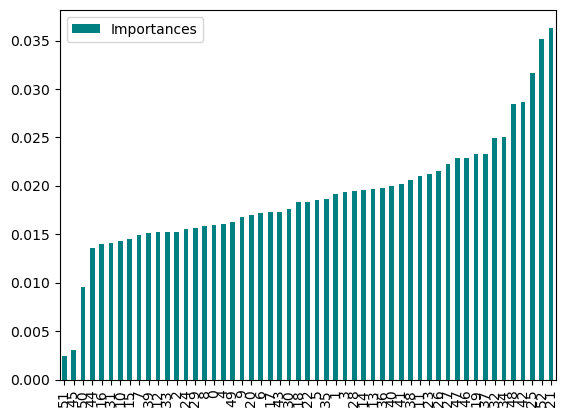

In [52]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier( n_estimators = 340 )

model.fit(shuffled_X, shuffled_Y)

importances = model.feature_importances_

final_df = pd.DataFrame({"Features" : pd.DataFrame(shuffled_X).columns, "Importances" : importances } )
final_df.set_index('Importances')

final_df = final_df.sort_values('Importances')
final_df.plot.bar(color = 'teal')

In [53]:
# print(type( final_df ) )
# print(final_df.columns)
# print(final_df['Features'].iloc[-10:])
important_cols = []
important_cols = final_df['Features'].iloc[-10:].values.tolist()
print(important_cols)

selected_features += important_cols

['Illness, injury, bereavement, stress in last 2 years: Serious illness, injury or assault to yourself', 'Age completed full time education', 'Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 'Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 'Non-cancer illness code, self-reported: hypertension', 'Illness, injury, bereavement, stress in last 2 years: Financial difficulties', 'Mental health problems ever diagnosed by a professional: Social anxiety or social phobia', "Illnesses of mother: Alzheimer's disease/dementia", 'age', 'Types of physical activity in last 4 weeks: Strenuous sports']


# Select features based on all methods

https://www.digitalocean.com/community/tutorials/python-counter-python-collections-counter

In [54]:
from collections import Counter
# print(selected_features)
c = Counter( selected_features )
# print( c )
# print( c.most_common(20) )
most_common = c.most_common(15)
print( most_common )
selected_col = list( list(zip(*most_common))[0] )
print(selected_col)

[('Illness, injury, bereavement, stress in last 2 years: Financial difficulties', 7), ('Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)', 6), ('Loneliness, isolation', 5), ('Non-cancer illness code, self-reported: hypothyroidism/myxoedema', 5), ('Non-cancer illness code, self-reported: hypertension', 5), ('Illness, injury, bereavement, stress in last 2 years: Serious illness, injury or assault to yourself', 5), ('Hearing difficulty/problems: Yes', 4), ('Types of physical activity in last 4 weeks: Strenuous sports', 4), ('Leisure/social activities: Pub or social club', 4), ('Mental health problems ever diagnosed by a professional: Anxiety, nerves or generalized anxiety disorder', 4), ('age', 4), ('Mood swings', 3), ('Diagnoses - secondary ICD10: I10 Essential (primary) hypertension', 3), ('Leisure/social activities: Sports club or gym', 3), ('Mental health problems ever diagnosed by a professional: Social anxiety or social phobia', 3)]
['Illness, i

# Drop extra features from Shuffled Dataframe

# Literature Review select features

Features related to : 
**Alcohol Consumption,
Hearing Problem,
Smoking / Cigarettes,
Cholesterol,
Blood Pressure,
Meat,
Depression,
Insomnia /  Sleep Schedule,
Education,
Hypertension,
Physical Inactivity,
Brain Injury,
Father / Mother,
Obesity,
Diabetes,
Age**


'Non-cancer illness code, self-reported: type 2 diabetes'
'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol'
'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure'
'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression’
'Hearing difficulty/problems with background noise'
'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education'
'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings'
'Non-cancer illness code, self-reported: hypertension'
'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension'
'Non-cancer illness code, self-reported: head injury', 'Alcohol intake frequency', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified’


In [55]:
# selected_col = ['Non-cancer illness code, self-reported: type 2 diabetes', 'Total cholesterol', 'HDL cholesterol', 'LDL cholesterol', 
# 'Cigarettes per Day', 'systolic blood pressure', 'diastolic blood pressure',
# 'Hearing difficulty/problems: Yes', 'Non-cancer illness code, self-reported: depression',
# 'Hearing difficulty/problems with background noise',
# 'Sleeplessness / insomnia', 'Sleep duration', 'Age completed full time education',
# 'Types of physical activity in last 4 weeks: Strenuous sports', 'Other meat intake', 'Loneliness, isolation', "Illnesses of father: Alzheimer's disease/dementia", "Illnesses of mother: Alzheimer's disease/dementia", 'Mood swings',
# 'Non-cancer illness code, self-reported: hypertension',
# 'Diagnoses - secondary ICD10: I10 Essential (primary) hypertension',
# 'Non-cancer illness code, self-reported: head injury', 'Alcohol intake frequency', 'Diagnoses - secondary ICD10: E66.9 Obesity, unspecified', 'age']

In [56]:
selected_col += ['output']
shuffled = shuffled[selected_col]

print( shuffled.shape )
print( shuffled.head() )

# dropping last / output column in df
shuffled_X = shuffled.iloc[: , :-1]

(437, 16)
   Illness, injury, bereavement, stress in last 2 years: Financial difficulties  \
0                                           0.903190                              
1                                          -1.509430                              
2                                           0.232871                              
3                                          -1.382295                              
4                                          -1.494175                              

   Types of physical activity in last 4 weeks: Light DIY (eg: pruning, watering the lawn)  \
0                                           3.700158                                        
1                                          -1.224680                                        
2                                           0.896391                                        
3                                          -1.110818                                        
4                         

# LOOCV

**Random Forest Classifier with LOOCV**

In [57]:
# from sklearn.model_selection import LeaveOneOut
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # print(shuffled_X.shape)
# # create loocv procedure
# cv = LeaveOneOut()
# # enumerate splits
# y_true, y_pred = list(), list()
# for train_ix, test_ix in cv.split(shuffled_X):
#     # split data
# #     print(train_ix, test_ix)
#     X_train, X_test = shuffled_X.iloc[train_ix], shuffled_X.iloc[test_ix]
#     y_train, y_test = shuffled_Y.iloc[train_ix], shuffled_Y.iloc[test_ix]
#     # fit model
#     model = RandomForestClassifier(random_state=1)
#     model.fit(X_train, y_train)
#     # evaluate model
#     yhat = model.predict(X_test)
#     # store
# #     print(y_test[0], yhat[0])
# #  print(len( y_test ), len( yhat ) )
#     y_true.append(y_test)
#     y_pred.append(yhat)
# # calculate accuracy
# acc = accuracy_score(y_true, y_pred)
# print('Accuracy: %.3f' % acc)

**Neural Network Model with LOOCV**

Epoch number is reduced to 250

In [58]:
# from sklearn.model_selection import LeaveOneOut
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import accuracy_score

# # print(shuffled_X.shape)

# avg_val_acc = []
# accuracies = []
# accuracies_val = []
# acc_score = []
# total_epochs = 250 #250(ideal)


# # create loocv procedure
# cv = LeaveOneOut()
# # enumerate splits
# y_true, y_pred = list(), list()
# for train_ix, test_ix in cv.split(shuffled_X):
#     # split data
# #     print(train_ix, test_ix)
#     X_train, X_test = shuffled_X.iloc[train_ix], shuffled_X.iloc[test_ix]
#     y_train, y_test = shuffled_Y.iloc[train_ix], shuffled_Y.iloc[test_ix]
    
#     train_dataset = df_dataSet( X_train, y_train )
#     valid_dataset = df_dataSet( X_test, y_test )
                
#     train_batch_size = train_dataset.__len__()
#     val_batch_size = valid_dataset.__len__()
                

                
#     train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 0)
#     valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

#     model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
#     model = model.to(DEVICE)
#     optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#     criterion = torch.nn.BCEWithLogitsLoss() 
#     best_acc_val = 0.
#     model_best = None
                
#     for epoch_num in range(total_epochs):
# #       print(epoch_num)
#         model.train()
# #       model.drop_probab=.8
# #       print("model trained")
#         precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = loocv_epoch(model=model, optimizer=optimizer, 
#                                                                                  criterion=criterion, is_training=True, 
#                                                                                loader=train_loader)
# #                     print("model validated")
#         model.eval()
# #       model.drop_probab=.0
#         precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = loocv_epoch(model=model, 
#                                                                                  optimizer=optimizer, 
#                                                                                  criterion=criterion, is_training=False, 
#                                                                                 loader=valid_loader)
# #       print("model kahini done")
#         if acc_val >= best_acc_val:
#             best_acc_val = acc_val
#             model_best = model.to(DEVICE)

#     model_best.eval()
#     precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = loocv_epoch(model=model_best, 
#                                                                              optimizer=optimizer, 
#                                                                              criterion=criterion, is_training=False, 
#                                                                              loader=valid_loader)
#     accuracies += [acc_test]
#     accuracies_val += [best_acc_val]
    
#     if test_ix % 50 == 0:
#         print(test_ix, ':', acc_test)
   


   # print( 'Accuracy', np.sum( accuracies ) / len( accuracies ) )

# Model training

https://www.analyticsvidhya.com/blog/2021/09/a-comprehensive-guide-on-neural-networks-performance-optimization/

In [59]:
tensor_X = torch.tensor(shuffled_X.values, dtype=torch.float32).to(DEVICE)
print( tensor_X[0].shape )

GENERATE_SHAP = True
total_epochs = 500 #250(ideal)
num_features_list = [shuffled_X.shape[1]]
# random_integers = [2, 6, 108, 90, 5]
random_integers = [90]#, 92, 0, 87, 73, 82, 54]

folds_list = [10]#[37*2]

avg_val_acc = []

shap_values_list = []
for num_features in num_features_list:
    print(f'NF:{num_features}')
    global_best_acc_val = 0.
    precision_avg = 0
    recall_avg = 0
    auprc_avg = 0
    auroc_avg = 0
    fscore_avg = 0
    for total_folds in folds_list:
        print(f'\n#F{total_folds}')
        for random_seed in random_integers:
            accuracies = []
            accuracies_val = []
            temp_shap_values = np.zeros(shuffled_X.shape)
            
            kf = KFold(n_splits = total_folds, random_state = None)
            acc_score = []

            for train_index , test_index in kf.split(shuffled):
                X_train , X_test = shuffled_X.iloc[train_index,:], shuffled_X.iloc[test_index,:]
                y_train , y_test = shuffled_Y[train_index] , shuffled_Y[test_index]
                
                X_train, y_train = bordersmote( X_train, y_train )
                print("train size: ", X_train.shape, y_train.shape)
                print("test size: ", X_test.shape, y_test.shape)
                
                train_dataset = df_dataSet( X_train, y_train )
                valid_dataset = df_dataSet( X_test, y_test )
                
                train_batch_size = train_dataset.__len__()
                val_batch_size = valid_dataset.__len__()
                
#                 print( train_batch_size, val_batch_size )
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = False, num_workers = 0)

#                 train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = train_batch_size, shuffle = True, num_workers = 0)
                valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = val_batch_size, shuffle = False, num_workers = 0)

                model = simple_model(num_features = shuffled_X.shape[1], hidden_dim = hidden_dimension)
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.BCEWithLogitsLoss() 
                best_acc_val = 0.
                model_best = None
                
                for epoch_num in range(total_epochs):
#                     print(epoch_num)
                    model.train()
#                     model.drop_probab=.8
#                     print("model trained")
                    precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=True, 
                                                                                           loader=train_loader)
#                     print("model validated")
                    model.eval()
#                     model.drop_probab=.0
                    precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
                                                                                             optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=False, 
                                                                                            loader=valid_loader)
#                     print("model kahini done")
                    if acc_val > best_acc_val:
                        best_acc_val = acc_val
                        if acc_val > global_best_acc_val:
                            global_best_acc_val = acc_val
    #                         print('global updated!')
                        torch.save(model.state_dict(), 'PRS_model.pt')
    #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
#                     if epoch_num + 1 == total_epochs:
#     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
#                         pass
                model_best = simple_model(num_features= shuffled_X.shape[1], hidden_dim = hidden_dimension, drop_probab=.0)
                model_best.load_state_dict(torch.load('PRS_model.pt'))
                model_best = model_best.to(DEVICE)
                model_best.eval()
                precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
                                                                                         optimizer=optimizer, 
                                                                                         criterion=criterion, is_training=False, 
                                                                                         loader=valid_loader)
                accuracies += [acc_test]
                accuracies_val += [best_acc_val]
                print("precision : ", precision, " ; recall : ", recall)
                precision_avg += precision
                recall_avg += recall
                auprc_avg += auprc
                auroc_avg += auroc
                fscore_avg += fscore
                
#                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
#                 print("pred")
#                 print(pred)
#                 print("pred binary")
#                 print(type(pred_binary))
#                 print(pred_binary)
                
                print(total_folds, ':')
                if GENERATE_SHAP:
                    explainer = shap.GradientExplainer(model_best.to(DEVICE), tensor_X,
                                                       batch_size=shuffled_X.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
#                     print("usable features : ", usable_features.shape[0])
#                     print(usable_features.shape)
#                     print(usable_features)
                    shap_values = explainer.shap_values(tensor_X, nsamples=500)
#                     print("shap values shape : ", shap_values.shape)
#                     print("Shap values : ", shap_values)
#                     print("shap values of 0 index", shap_values[0, :])
                    
                    temp_shap_values += shap_values 
            if GENERATE_SHAP:
                temp_shap_values /= total_folds
                shap_values_list += [temp_shap_values] 
            print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
                  np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
            avg_val_acc += [np.mean(accuracies_val)]
    print("accuraacies of validation: ", accuracies_val)
    print("average val accuracy: ", avg_val_acc)
    print(f'global_best_acc_val:{global_best_acc_val}')
    precision_avg = precision_avg * 1.0 / total_folds
    recall_avg = recall_avg * 1.0 / total_folds
    auprc_avg = auprc_avg * 1.0 / total_folds
    auroc_avg = auroc_avg * 1.0 / total_folds
    fscore_avg = fscore_avg * 1.0 / total_folds
    print( "precision avg : ", precision_avg )
    print( "recall avg : ", recall_avg )
    print( "AUPRC avg : ", auprc_avg )
    print( "AUROC avg : ", auroc_avg )
    print( "FScore avg : ", fscore_avg )
# usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
avg_val_acc = np.array(avg_val_acc)
print("average val accuracy: ", avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

torch.Size([15])
NF:15

#F10
train size:  (472, 15) (472,)
test size:  (44, 15) (44,)
[0.  0.5] [0. 1.] [0.         0.66666667] [236 236] 0.4961756679115197 0.49121083623684647
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.51875 0.5643154756416947
[0.         0.49893843] [0.         0.99576271] [0.         0.66478076] [236 236] 0.5306395432347026 0.49399876458102515
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.4604166666666667 0.579666734586745
[0.  0.5] [0. 1.] [0.         0.66666667] [236 236] 0.4992459063487504 0.5055261714326331
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.54375 0.5940462046432705
[0.  0.5] [0. 1.] [0.         0.66666667] [236 236] 0.5092466245331801 0.5106866803501756
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.44166666666666665 0.48399087079862635
[0.  0.5] [0. 1.] [0.         0.66666667] [236 236] 0.509192760700948 0.5075028578259989
[0.         0.54545455] [0. 1.] [0.         0.

[0.52588556 0.59047619] [0.81779661 0.26271186] [0.64013267 0.36363636] [236 236] 0.5315642056880207 0.53129284613272
[0.48571429 0.66666667] [0.85 0.25] [0.61818182 0.36363636] [20 24] 0.6479166666666667 0.7166507166647684
[0.50128535 0.5060241 ] [0.82627119 0.1779661 ] [0.624      0.26332288] [236 236] 0.5694125251364551 0.5396801366233391
[0.45 0.5 ] [0.9        0.08333333] [0.6        0.14285714] [20 24] 0.7 0.7002600592294288
[0.5257732  0.61904762] [0.86440678 0.22033898] [0.65384615 0.325     ] [236 236] 0.5945759120942258 0.5773381640137913
[0.48780488 1.        ] [1.    0.125] [0.6557377  0.22222222] [20 24] 0.6541666666666667 0.7191948696557771
[0.51507538 0.58108108] [0.86864407 0.18220339] [0.6466877  0.27741935] [236 236] 0.5897191898879632 0.5651583099719812
[0.43589744 0.4       ] [0.85       0.08333333] [0.57627119 0.13793103] [20 24] 0.5750000000000001 0.6007941405353261
[0.51904762 0.65384615] [0.92372881 0.1440678 ] [0.66463415 0.23611111] [236 236] 0.614550416546969

[0.51685393 0.77777778] [0.97457627 0.08898305] [0.67547724 0.15969582] [236 236] 0.6405307382935937 0.6749701885617272
[0.47619048 1.        ] [1.         0.08333333] [0.64516129 0.15384615] [20 24] 0.7041666666666667 0.8030472069580827
[0.51006711 0.68      ] [0.96610169 0.0720339 ] [0.66764275 0.1302682 ] [236 236] 0.6294347888537777 0.6085714321239925
[0.48780488 1.        ] [1.    0.125] [0.6557377  0.22222222] [20 24] 0.78125 0.8295935575745854
[0.50769231 0.70588235] [0.97881356 0.05084746] [0.66859624 0.09486166] [236 236] 0.6022155989658144 0.6069041876869662
[0.5 1. ] [1.         0.16666667] [0.66666667 0.28571429] [20 24] 0.80625 0.8482953258870961
[0.51111111 0.72727273] [0.97457627 0.06779661] [0.67055394 0.12403101] [236 236] 0.6321818442976157 0.6239536400786243
[0.45454545 0.        ] [1. 0.] [0.625 0.   ] [20 24] 0.74375 0.827492796219409
[0.51555556 0.81818182] [0.98305085 0.07627119] [0.67638484 0.13953488] [236 236] 0.6307993392703246 0.6464124087427671
[0.48780488 

[0.59400545 0.82857143] [0.92372881 0.36864407] [0.72305141 0.51026393] [236 236] 0.6581890979603562 0.6838495560243455
[0.52777778 0.875     ] [0.95       0.29166667] [0.67857143 0.4375    ] [20 24] 0.7125 0.7685053645409075
[0.57765668 0.77142857] [0.89830508 0.34322034] [0.70315091 0.47507331] [236 236] 0.6346416259695491 0.6418311025289041
[0.57575758 0.90909091] [0.95       0.41666667] [0.71698113 0.57142857] [20 24] 0.7125 0.752518985457779
[0.57567568 0.7745098 ] [0.90254237 0.33474576] [0.7029703  0.46745562] [236 236] 0.6404409652398736 0.6452951481990603
[0.52777778 0.875     ] [0.95       0.29166667] [0.67857143 0.4375    ] [20 24] 0.6687500000000001 0.7806249160309273
[0.57765668 0.77142857] [0.89830508 0.34322034] [0.70315091 0.47507331] [236 236] 0.6356560614765872 0.6410777131409717
[0.55555556 1.        ] [1.         0.33333333] [0.71428571 0.5       ] [20 24] 0.6666666666666666 0.7893323871866158
[0.57837838 0.78431373] [0.90677966 0.33898305] [0.70627063 0.47337278] [

[0.59831461 0.80172414] [0.90254237 0.3940678 ] [0.71959459 0.52840909] [236 236] 0.638771186440678 0.6796565261906453
[0.57575758 0.90909091] [0.95       0.41666667] [0.71698113 0.57142857] [20 24] 0.715625 0.7313931068446405
[0.58707865 0.76724138] [0.88559322 0.37711864] [0.70608108 0.50568182] [236 236] 0.6560794311979317 0.6867085616108356
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.7875 0.8514542144226315
[0.5960452  0.78813559] [0.8940678 0.3940678] [0.71525424 0.52542373] [236 236] 0.6359164033323759 0.6689401325390689
[0.54054054 1.        ] [1.         0.29166667] [0.70175439 0.4516129 ] [20 24] 0.6843750000000001 0.8056458493200179
[0.59490085 0.78151261] [0.88983051 0.3940678 ] [0.71307301 0.52394366] [236 236] 0.6502800919276069 0.6529472832344578
[0.57575758 0.90909091] [0.95       0.41666667] [0.71698113 0.57142857] [20 24] 0.71875 0.7270246110124855
[0.59887006 0.79661017] [0.89830508 0.39830508] [0.71864407 0.53107345] [236 236] 0.

[0.60344828 0.79032258] [0.88983051 0.41525424] [0.71917808 0.54444444] [236 236] 0.66087331226659 0.6903407782679479
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.70625 0.8040768255508656
[0.59883721 0.765625  ] [0.87288136 0.41525424] [0.71034483 0.53846154] [236 236] 0.6468507612754957 0.6459410858301551
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.6958333333333334 0.8003852152754898
[0.59770115 0.77419355] [0.88135593 0.40677966] [0.71232877 0.53333333] [236 236] 0.6356111749497271 0.6461974214322348
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.6989583333333333 0.8111371495404726
[0.59883721 0.765625  ] [0.87288136 0.41525424] [0.71034483 0.53846154] [236 236] 0.6570938667049698 0.65585540734312
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.759375 0.8500538947148462
[0.60404624 0.78571429] [0.88559322 0.41949153] [0.71821306 0.54696133] [236 236] 0.6494900890548693 0.684323

[0.60755814 0.7890625 ] [0.88559322 0.4279661 ] [0.72068966 0.55494505] [236 236] 0.6379811835679402 0.6924483040231808
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.6708333333333334 0.7995928389911815
[0.60344828 0.79032258] [0.88983051 0.41525424] [0.71917808 0.54444444] [236 236] 0.6530989658144211 0.6675319542191553
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.7062499999999999 0.8154263354889488
[0.5982659  0.76984127] [0.87711864 0.41101695] [0.71134021 0.5359116 ] [236 236] 0.6356111749497271 0.6612782648394914
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.7458333333333333 0.8177296020847844
[0.60057471 0.78225806] [0.88559322 0.41101695] [0.71575342 0.53888889] [236 236] 0.6572464808962942 0.6736535345437369
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.7249999999999999 0.8074734591967518
[0.6057971  0.78740157] [0.88559322 0.42372881] [0.71944923 0.55096419] 

[0.61271676 0.80952381] [0.89830508 0.43220339] [0.72852234 0.56353591] [236 236] 0.6565731829933927 0.6719181690030297
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.7312500000000002 0.810419012851078
[0.60174419 0.7734375 ] [0.87711864 0.41949153] [0.7137931  0.54395604] [236 236] 0.6294527434645216 0.6457095856473292
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.7687499999999999 0.7621959846004863
[0.60115607 0.77777778] [0.88135593 0.41525424] [0.71477663 0.54143646] [236 236] 0.649373384085033 0.6690633828476273
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.684375 0.7677214900964101
[0.60932945 0.79069767] [0.88559322 0.43220339] [0.72193437 0.55890411] [236 236] 0.6544635162309681 0.6738325927083635
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.7333333333333334 0.8216487942963857
[0.60869565 0.79527559] [0.88983051 0.4279661 ] [0.72289157 0.55647383] [236 236] 0.

[0.64516129 1.        ] [1.         0.54166667] [0.78431373 0.7027027 ] [20 24] 0.7645833333333334 0.8557345260238483
[0.60404624 0.78571429] [0.88559322 0.41949153] [0.71821306 0.54696133] [236 236] 0.6526770324619362 0.6731376504363153
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.7458333333333335 0.8345357393898584
[0.59943182 0.79166667] [0.8940678  0.40254237] [0.71768707 0.53370787] [236 236] 0.6514202097098535 0.6686070456463429
[0.60606061 1.        ] [1.         0.45833333] [0.75471698 0.62857143] [20 24] 0.7604166666666666 0.8540106786171181
[0.6011396  0.79338843] [0.8940678  0.40677966] [0.71890971 0.53781513] [236 236] 0.6487629273197357 0.6633435596423674
[0.60606061 1.        ] [1.         0.45833333] [0.75471698 0.62857143] [20 24] 0.7552083333333334 0.8502262674689144
[0.59943182 0.79166667] [0.8940678  0.40254237] [0.71768707 0.53370787] [236 236] 0.6556126113185865 0.7008463884763727
[0.64516129 1.        ] [1.         0.54166667] 

[0.61111111 0.79230769] [0.88559322 0.43644068] [0.72318339 0.56284153] [236 236] 0.6428199511634589 0.646128354721181
[0.63333333 0.92857143] [0.95       0.54166667] [0.76       0.68421053] [20 24] 0.7270833333333333 0.8122509678430729
[0.61337209 0.8046875 ] [0.8940678  0.43644068] [0.72758621 0.56593407] [236 236] 0.6450912094225797 0.6679297058240826
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.6916666666666667 0.7174398241653677
[0.60518732 0.792     ] [0.88983051 0.41949153] [0.72041166 0.54847645] [236 236] 0.6446962079862109 0.6789600880961602
[0.63333333 0.92857143] [0.95       0.54166667] [0.76       0.68421053] [20 24] 0.7208333333333334 0.8064653959381687
[0.60404624 0.78571429] [0.88559322 0.41949153] [0.71821306 0.54696133] [236 236] 0.6292283108302211 0.657190719585035
[0.59375    0.91666667] [0.95       0.45833333] [0.73076923 0.61111111] [20 24] 0.69375 0.7943644930777283
[0.60997067 0.78625954] [0.88135593 0.43644068] [0.72097054 0.5613079 ] [

[0.60818713 0.78461538] [0.88135593 0.43220339] [0.71972318 0.55737705] [236 236] 0.6403332375754093 0.6679938126540639
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.7385416666666667 0.7698716409436224
[0.60806916 0.8       ] [0.8940678  0.42372881] [0.7238422  0.55401662] [236 236] 0.6253142056880208 0.6819383671785224
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.675 0.753489531982179
[0.60755814 0.7890625 ] [0.88559322 0.4279661 ] [0.72068966 0.55494505] [236 236] 0.6410244900890548 0.6570829551762273
[0.63333333 0.92857143] [0.95       0.54166667] [0.76       0.68421053] [20 24] 0.7104166666666667 0.8229222166722165
[0.60526316 0.77692308] [0.87711864 0.4279661 ] [0.71626298 0.55191257] [236 236] 0.6626238868141339 0.6834345341340436
[0.61290323 0.92307692] [0.95 0.5 ] [0.74509804 0.64864865] [20 24] 0.71875 0.8223667779588831
[0.60997067 0.78625954] [0.88135593 0.43644068] [0.72097054 0.5613079 ] [236 236] 0.646581442114335 0.6486842

train size:  (470, 15) (470,)
test size:  (44, 15) (44,)
[0.49753695 0.484375  ] [0.85957447 0.13191489] [0.63026521 0.20735786] [235 235] 0.48727931190583973 0.49052603713150955
[0.43589744 0.6       ] [0.89473684 0.12      ] [0.5862069 0.2      ] [19 25] 0.4568421052631579 0.5681436285035999
[0.48951049 0.3902439 ] [0.89361702 0.06808511] [0.63253012 0.11594203] [235 235] 0.46238116794929834 0.47668417031906035
[0.41860465 0.        ] [0.94736842 0.        ] [0.58064516 0.        ] [19 25] 0.5284210526315789 0.5544593359564919
[0.49417249 0.43902439] [0.90212766 0.07659574] [0.63855422 0.13043478] [235 235] 0.5034314169307379 0.4851577034222985
[0.41860465 0.        ] [0.94736842 0.        ] [0.58064516 0.        ] [19 25] 0.7178947368421053 0.7212186347351224
[0.50465116 0.55      ] [0.92340426 0.09361702] [0.65263158 0.16      ] [235 235] 0.4944861928474423 0.5138059903177299
[0.43902439 0.66666667] [0.94736842 0.08      ] [0.6        0.14285714] [19 25] 0.4210526315789474 0.576175

[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.6378947368421053 0.6847787385741619
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.5700860117700317 0.5670127220763342
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.5578947368421053 0.5915116437155531
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6054323223177909 0.5880267851199061
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.728421052631579 0.8325999799772437
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6310547759167046 0.6013814919513396
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.6210526315789474 0.6629125497581295
[0.49786325 0.        ] [0.99148936 0.        ] [0.6628734 0.       ] [235 235] 0.5693979176097782 0.5493856835217774
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7115789473684211 0.6763955138056265
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6369216840199186 0.6140794067515141
[0.43181818 0.        ]

[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.6799999999999999 0.7234370042821064
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.63584427342689 0.62259814396575
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7936842105263159 0.8069934466232542
[0.4989339 0.       ] [0.99574468 0.        ] [0.66477273 0.        ] [235 235] 0.6099592575826165 0.6242872381322053
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7368421052631579 0.7131552585754332
[0.5010661 1.       ] [1.         0.00425532] [0.66761364 0.00847458] [235 235] 0.6424807605251245 0.6697790421622317
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7221052631578948 0.789439248712207
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.635400633770937 0.6682115059754954
[0.41860465 0.        ] [0.94736842 0.        ] [0.58064516 0.        ] [19 25] 0.6778947368421053 0.6870636470550073
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6063558171118153 0

[0.53537736 0.82608696] [0.96595745 0.16170213] [0.68892261 0.27046263] [235 235] 0.6301856043458578 0.6697800206834337
[0.48571429 0.77777778] [0.89473684 0.28      ] [0.62962963 0.41176471] [19 25] 0.6631578947368422 0.6675901664128228
[0.54066986 0.82692308] [0.96170213 0.18297872] [0.69218989 0.29965157] [235 235] 0.6434947940244454 0.6844631163419966
[0.44736842 0.66666667] [0.89473684 0.16      ] [0.59649123 0.25806452] [19 25] 0.6778947368421053 0.7580538290601988
[0.52657005 0.69642857] [0.92765957 0.16595745] [0.67180277 0.26804124] [235 235] 0.6375192394748755 0.645666324416792
[0.47222222 0.75      ] [0.89473684 0.24      ] [0.61818182 0.36363636] [19 25] 0.6842105263157895 0.6985485274597639
[0.51408451 0.63636364] [0.93191489 0.11914894] [0.66263238 0.20071685] [235 235] 0.6284653689452242 0.621275106825154
[0.5 0.8] [0.89473684 0.32      ] [0.64150943 0.45714286] [19 25] 0.7389473684210527 0.7962345229270742
[0.53012048 0.72727273] [0.93617021 0.17021277] [0.67692308 0.27

[0.59195402 0.76229508] [0.87659574 0.39574468] [0.70668954 0.5210084 ] [235 235] 0.6531100045269352 0.6440075864576329
[0.59259259 0.82352941] [0.84210526 0.56      ] [0.69565217 0.66666667] [19 25] 0.648421052631579 0.7743583078666939
[0.58404558 0.74789916] [0.87234043 0.3787234 ] [0.6996587  0.50282486] [235 235] 0.6653055681303758 0.674744837664652
[0.55172414 0.8       ] [0.84210526 0.48      ] [0.66666667 0.6       ] [19 25] 0.6831578947368421 0.7073659529727
[0.57879656 0.72727273] [0.85957447 0.37446809] [0.69178082 0.49438202] [235 235] 0.6395835219556361 0.6315876192204543
[0.60714286 0.875     ] [0.89473684 0.56      ] [0.72340426 0.68292683] [19 25] 0.756842105263158 0.8334957887406184
[0.59130435 0.752     ] [0.86808511 0.4       ] [0.70344828 0.52222222] [235 235] 0.6453870529651425 0.6565989081416306
[0.55172414 0.8       ] [0.84210526 0.48      ] [0.66666667 0.6       ] [19 25] 0.7452631578947368 0.7812877132406536
[0.5872093  0.73809524] [0.85957447 0.39574468] [0.697

[0.59356725 0.75      ] [0.86382979 0.40851064] [0.70363951 0.52892562] [235 235] 0.6393300135808058 0.6562882415868414
[0.59259259 0.82352941] [0.84210526 0.56      ] [0.69565217 0.66666667] [19 25] 0.6968421052631579 0.7502817616786337
[0.60059172 0.75757576] [0.86382979 0.42553191] [0.70855148 0.54495913] [235 235] 0.6709280217292892 0.6625028742955505
[0.57142857 0.8125    ] [0.84210526 0.52      ] [0.68085106 0.63414634] [19 25] 0.6799999999999999 0.7572312124385107
[0.59705882 0.75384615] [0.86382979 0.41702128] [0.70608696 0.5369863 ] [235 235] 0.6668899954730647 0.6525936280691019
[0.57142857 0.8125    ] [0.84210526 0.52      ] [0.68085106 0.63414634] [19 25] 0.7789473684210527 0.8477303237779711
[0.59183673 0.7480315 ] [0.86382979 0.40425532] [0.70242215 0.52486188] [235 235] 0.6537799909461295 0.6552250774070737
[0.59259259 0.82352941] [0.84210526 0.56      ] [0.69565217 0.66666667] [19 25] 0.7221052631578947 0.7838097087645716
[0.59356725 0.75      ] [0.86382979 0.40851064] 

[0.60714286 0.875     ] [0.89473684 0.56      ] [0.72340426 0.68292683] [19 25] 0.7326315789473683 0.7673169482912019
[0.59710145 0.768     ] [0.87659574 0.40851064] [0.71034483 0.53333333] [235 235] 0.6437573562698053 0.6631970710959829
[0.57142857 0.8125    ] [0.84210526 0.52      ] [0.68085106 0.63414634] [19 25] 0.6547368421052633 0.7352086240846454
[0.5942029 0.76     ] [0.87234043 0.40425532] [0.70689655 0.52777778] [235 235] 0.6613942960615662 0.6640100836239506
[0.55555556 0.76470588] [0.78947368 0.52      ] [0.65217391 0.61904762] [19 25] 0.6463157894736842 0.6709341682271772
[0.59654179 0.77235772] [0.88085106 0.40425532] [0.71134021 0.53072626] [235 235] 0.6401539157990039 0.6643647839655491
[0.61538462 0.83333333] [0.84210526 0.6       ] [0.71111111 0.69767442] [19 25] 0.7431578947368421 0.7811651892262358
[0.5954416  0.78151261] [0.8893617  0.39574468] [0.71331058 0.52542373] [235 235] 0.6235310095065639 0.6658208489738615
[0.59259259 0.82352941] [0.84210526 0.56      ] [0

[0.60174419 0.77777778] [0.88085106 0.41702128] [0.71502591 0.54293629] [235 235] 0.668157537347216 0.6883719719196587
[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.6926315789473684 0.707015025117566
[0.60465116 0.78571429] [0.88510638 0.4212766 ] [0.71848014 0.54847645] [235 235] 0.6646808510638298 0.6894021730222011
[0.57692308 0.77777778] [0.78947368 0.56      ] [0.66666667 0.65116279] [19 25] 0.7273684210526316 0.7722331183371701
[0.61046512 0.8015873 ] [0.89361702 0.42978723] [0.7253886  0.55955679] [235 235] 0.6392394748755093 0.6676483622034259
[0.6        0.78947368] [0.78947368 0.6       ] [0.68181818 0.68181818] [19 25] 0.6831578947368421 0.7014678145789199
[0.60518732 0.79674797] [0.89361702 0.41702128] [0.72164948 0.54748603] [235 235] 0.6456133997283839 0.6763806828161583
[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.6126315789473685 0.6753920607484614
[0.61176471 0.79230769] [0.88510638 0.43829787] [0

[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.7378947368421053 0.7693133922879954
[0.61079545 0.83050847] [0.91489362 0.41702128] [0.73253833 0.55524079] [235 235] 0.673689452240833 0.7014082268909175
[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.7105263157894737 0.7645351333913589
[0.60623229 0.82051282] [0.9106383  0.40851064] [0.72789116 0.54545455] [235 235] 0.6770484382073336 0.6856211436733668
[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.7410526315789474 0.8213192358774019
[0.60504202 0.83185841] [0.91914894 0.4       ] [0.72972973 0.54022989] [235 235] 0.6749026708918062 0.6950514288283854
[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.6336842105263157 0.6650834408073758
[0.60795455 0.8220339 ] [0.9106383  0.41276596] [0.72913118 0.54957507] [235 235] 0.6626708918062473 0.7003671559539533
[0.53571429 0.75      ] [0.78947368 0.48      ] [

[0.55555556 0.76470588] [0.78947368 0.52      ] [0.65217391 0.61904762] [19 25] 0.6631578947368422 0.7354157777444669
[0.61781609 0.83606557] [0.91489362 0.43404255] [0.73756432 0.57142857] [235 235] 0.6908193752829335 0.710437669486352
[0.57692308 0.77777778] [0.78947368 0.56      ] [0.66666667 0.65116279] [19 25] 0.7105263157894737 0.7701797372731467
[0.61604585 0.83471074] [0.91489362 0.42978723] [0.73630137 0.56741573] [235 235] 0.6636487098234495 0.6990151153163575
[0.57692308 0.77777778] [0.78947368 0.56      ] [0.66666667 0.65116279] [19 25] 0.6915789473684211 0.7670125314630108
[0.61079545 0.83050847] [0.91489362 0.41702128] [0.73253833 0.55524079] [235 235] 0.6939248528746038 0.7165236217679039
[0.53571429 0.75      ] [0.78947368 0.48      ] [0.63829787 0.58536585] [19 25] 0.648421052631579 0.7308269855296438
[0.61823362 0.8487395 ] [0.92340426 0.42978723] [0.74061433 0.57062147] [235 235] 0.6664916251697601 0.7112835141959117
[0.57692308 0.77777778] [0.78947368 0.56      ] [0

[0.55555556 0.76470588] [0.78947368 0.52      ] [0.65217391 0.61904762] [19 25] 0.7105263157894737 0.8161027174438249
[0.61142857 0.825     ] [0.9106383 0.4212766] [0.73162393 0.55774648] [235 235] 0.6784065187867814 0.7196253075174581
[0.57692308 0.77777778] [0.78947368 0.56      ] [0.66666667 0.65116279] [19 25] 0.6663157894736842 0.7465703455495216
[0.61126761 0.84347826] [0.92340426 0.41276596] [0.73559322 0.55428571] [235 235] 0.6833137166138523 0.7333393725642516
[0.51724138 0.73333333] [0.78947368 0.44      ] [0.625 0.55 ] [19 25] 0.7136842105263157 0.7496636070682198
[0.60784314 0.84070796] [0.92340426 0.40425532] [0.73310811 0.54597701] [235 235] 0.7128564961521051 0.7351116460806364
[0.51724138 0.73333333] [0.78947368 0.44      ] [0.625 0.55 ] [19 25] 0.6873684210526316 0.7278318775852981
[0.61849711 0.83064516] [0.9106383  0.43829787] [0.73666093 0.57381616] [235 235] 0.6666727025803532 0.71020385114685
[0.55555556 0.76470588] [0.78947368 0.52      ] [0.65217391 0.61904762] 

[0.59259259 0.82352941] [0.84210526 0.56      ] [0.69565217 0.66666667] [19 25] 0.7305263157894737 0.7725879197792627
precision :  0.8235294117647058  ; recall :  0.56
10 :
train size:  (464, 15) (464,)
test size:  (44, 15) (44,)
[0.47619048 0.49303621] [0.21551724 0.76293103] [0.29673591 0.59898477] [232 232] 0.5059638822829964 0.4992157438664311
[0.21428571 0.56666667] [0.1875     0.60714286] [0.2       0.5862069] [16 28] 0.390625 0.5876516897945677
[0.53383459 0.51359517] [0.30603448 0.73275862] [0.3890411  0.60390764] [232 232] 0.540520957193817 0.5321361143555348
[0.53846154 0.70967742] [0.4375     0.78571429] [0.48275862 0.74576271] [16 28] 0.6160714285714286 0.6897297724071233
[0.512      0.50442478] [0.27586207 0.73706897] [0.35854342 0.59894921] [232 232] 0.5066513079667063 0.5063730812136321
[0.29411765 0.59259259] [0.3125     0.57142857] [0.3030303  0.58181818] [16 28] 0.47321428571428575 0.6700038703895065
[0.58783784 0.54113924] [0.375      0.73706897] [0.45789474 0.624087

[0.5 0.5] [0.97844828 0.02155172] [0.66180758 0.04132231] [232 232] 0.5888265457788348 0.5702211135196505
[0.36585366 0.66666667] [0.9375     0.07142857] [0.52631579 0.12903226] [16 28] 0.6540178571428572 0.757781638918042
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [232 232] 0.623030618311534 0.6064178112462835
[0.37209302 1.        ] [1.         0.03571429] [0.54237288 0.06896552] [16 28] 0.6294642857142857 0.7756347818230526
[0.5021645 1.       ] [1.         0.00862069] [0.6685879  0.01709402] [232 232] 0.6403463139120095 0.6266825475026888
[0.36363636 0.        ] [1. 0.] [0.53333333 0.        ] [16 28] 0.7098214285714286 0.7704979954247875
[0.50434783 1.        ] [1.         0.01724138] [0.67052023 0.03389831] [232 232] 0.6080001486325802 0.5985858498272999
[0.36363636 0.        ] [1. 0.] [0.53333333 0.        ] [16 28] 0.6651785714285714 0.7384673919620869
[0.49782609 0.25      ] [0.98706897 0.00431034] [0.66184971 0.00847458] [232 232] 0.5978002378121283 0.578247981272218
[0.363636

[0.36363636 0.        ] [1. 0.] [0.53333333 0.        ] [16 28] 0.7566964285714285 0.8782540073766307
[0.50434783 1.        ] [1.         0.01724138] [0.67052023 0.03389831] [232 232] 0.6427987514863257 0.6828887232381293
[0.36363636 0.        ] [1. 0.] [0.53333333 0.        ] [16 28] 0.7276785714285714 0.8281184227511921
[0.50218341 0.66666667] [0.99137931 0.01724138] [0.66666667 0.03361345] [232 232] 0.654577883472057 0.6640086756706696
[0.38095238 1.        ] [1.         0.07142857] [0.55172414 0.13333333] [16 28] 0.7991071428571428 0.8656249881631366
[0.50217391 0.75      ] [0.99568966 0.01293103] [0.66763006 0.02542373] [232 232] 0.635998810939358 0.6436866815157891
[0.36363636 0.        ] [1. 0.] [0.53333333 0.        ] [16 28] 0.7723214285714285 0.8765860748371346
[0.5010846  0.66666667] [0.99568966 0.00862069] [0.66666667 0.01702128] [232 232] 0.651410151605232 0.6424419015579601
[0.36363636 0.        ] [1. 0.] [0.53333333 0.        ] [16 28] 0.7433035714285714 0.85044553477007

[0.52570093 0.80555556] [0.96982759 0.125     ] [0.68181818 0.21641791] [232 232] 0.6531844530321046 0.6749605545168385
[0.4 1. ] [1.         0.14285714] [0.57142857 0.25      ] [16 28] 0.6852678571428571 0.7992363256206005
[0.52112676 0.73684211] [0.95689655 0.12068966] [0.67477204 0.20740741] [232 232] 0.6628734393579072 0.6609384485246667
[0.42105263 1.        ] [1.         0.21428571] [0.59259259 0.35294118] [16 28] 0.7165178571428571 0.8439257509719278
[0.53206651 0.81395349] [0.96551724 0.15086207] [0.68606432 0.25454545] [232 232] 0.6600865784780023 0.665893853449515
[0.42857143 0.88888889] [0.9375     0.28571429] [0.58823529 0.43243243] [16 28] 0.7388392857142857 0.852521091471733
[0.53066038 0.825     ] [0.96982759 0.14224138] [0.68597561 0.24264706] [232 232] 0.6384140903686089 0.6629626566093475
[0.3902439 1.       ] [1.         0.10714286] [0.56140351 0.19354839] [16 28] 0.7477678571428571 0.8551786437742527
[0.52245863 0.73170732] [0.95258621 0.12931034] [0.67480916 0.2197

[0.46666667 0.85714286] [0.875      0.42857143] [0.60869565 0.57142857] [16 28] 0.625 0.7016775411724894
[0.5801105  0.78431373] [0.90517241 0.34482759] [0.70707071 0.47904192] [232 232] 0.64540911117717 0.6581759175257071
[0.4516129  0.84615385] [0.875      0.39285714] [0.59574468 0.53658537] [16 28] 0.7008928571428572 0.7831296275116111
[0.5922865  0.83168317] [0.92672414 0.36206897] [0.72268908 0.5045045 ] [232 232] 0.6701471462544589 0.688943419881371
[0.46666667 0.85714286] [0.875      0.42857143] [0.60869565 0.57142857] [16 28] 0.6294642857142856 0.7164394409381833
[0.58333333 0.78846154] [0.90517241 0.35344828] [0.70945946 0.48809524] [232 232] 0.6377080856123662 0.6811778057626283
[0.5   0.875] [0.875 0.5  ] [0.63636364 0.63636364] [16 28] 0.7790178571428571 0.851607207683787
[0.58543417 0.78504673] [0.90086207 0.36206897] [0.70967742 0.49557522] [232 232] 0.6732870095124851 0.696652766672827
[0.51724138 0.93333333] [0.9375 0.5   ] [0.66666667 0.65116279] [16 28] 0.755580357142

[0.59195402 0.77586207] [0.88793103 0.38793103] [0.71034483 0.51724138] [232 232] 0.6387020659928656 0.6693783319155978
[0.51851852 0.88235294] [0.875      0.53571429] [0.65116279 0.66666667] [16 28] 0.7020089285714286 0.8193504213835373
[0.60174419 0.79166667] [0.89224138 0.40948276] [0.71875    0.53977273] [232 232] 0.6512336504161712 0.6714951564001506
[0.53846154 0.88888889] [0.875      0.57142857] [0.66666667 0.69565217] [16 28] 0.7879464285714286 0.8759116658292088
[0.5960452  0.80909091] [0.90948276 0.38362069] [0.72013652 0.52046784] [232 232] 0.6262262187871581 0.6650589670118683
[0.53846154 0.88888889] [0.875      0.57142857] [0.66666667 0.69565217] [16 28] 0.78125 0.8639417722733287
[0.59537572 0.77966102] [0.88793103 0.39655172] [0.71280277 0.52571429] [232 232] 0.6558598394768134 0.6609471023096203
[0.51724138 0.93333333] [0.9375 0.5   ] [0.66666667 0.65116279] [16 28] 0.7633928571428571 0.8856459126319407
[0.58739255 0.76521739] [0.88362069 0.37931034] [0.70567986 0.50720

[0.53571429 0.9375    ] [0.9375     0.53571429] [0.68181818 0.68181818] [16 28] 0.7366071428571428 0.8463496701779537
[0.59887006 0.81818182] [0.9137931  0.38793103] [0.72354949 0.52631579] [232 232] 0.6747547562425684 0.7055098300329974
[0.48275862 0.86666667] [0.875      0.46428571] [0.62222222 0.60465116] [16 28] 0.7299107142857142 0.8293057585263508
[0.59659091 0.80357143] [0.90517241 0.38793103] [0.71917808 0.52325581] [232 232] 0.6591111771700355 0.6903444011579243
[0.48275862 0.86666667] [0.875      0.46428571] [0.62222222 0.60465116] [16 28] 0.7142857142857142 0.8334491772203525
[0.60169492 0.82727273] [0.91810345 0.39224138] [0.72696246 0.53216374] [232 232] 0.6716427615933414 0.7107002314808544
[0.48148148 0.82352941] [0.8125 0.5   ] [0.60465116 0.62222222] [16 28] 0.7433035714285714 0.8575633470265028
[0.58707865 0.78703704] [0.90086207 0.36637931] [0.71088435 0.5       ] [232 232] 0.637754533293698 0.6524783410840878
[0.48275862 0.86666667] [0.875      0.46428571] [0.622222

[0.58640227 0.77477477] [0.89224138 0.37068966] [0.70769231 0.50145773] [232 232] 0.6521626040428061 0.6512076380992333
[0.5   0.875] [0.875 0.5  ] [0.63636364 0.63636364] [16 28] 0.6886160714285714 0.7576833660092637
[0.5954416  0.79646018] [0.90086207 0.38793103] [0.71698113 0.52173913] [232 232] 0.6614707193816884 0.6556198381148532
[0.51851852 0.88235294] [0.875      0.53571429] [0.65116279 0.66666667] [16 28] 0.7779017857142857 0.8893261218643996
[0.59550562 0.81481481] [0.9137931  0.37931034] [0.72108844 0.51764706] [232 232] 0.6297190844233056 0.6986538178038231
[0.57142857 1.        ] [1.         0.57142857] [0.72727273 0.72727273] [16 28] 0.7767857142857142 0.8953485810766404
[0.59550562 0.81481481] [0.9137931  0.37931034] [0.72108844 0.51764706] [232 232] 0.6730919292508918 0.7041757699537905
[0.5        0.92857143] [0.9375     0.46428571] [0.65217391 0.61904762] [16 28] 0.6852678571428571 0.8368586694584592
[0.59103641 0.80373832] [0.90948276 0.37068966] [0.71646859 0.507374

[0.59773371 0.81081081] [0.90948276 0.38793103] [0.72136752 0.52478134] [232 232] 0.6658182223543401 0.7032014294021732
[0.51851852 0.88235294] [0.875      0.53571429] [0.65116279 0.66666667] [16 28] 0.7433035714285714 0.8068173467706308
[0.59217877 0.81132075] [0.9137931  0.37068966] [0.71864407 0.50887574] [232 232] 0.6727667954815695 0.7021002000523686
[0.55555556 0.94117647] [0.9375     0.57142857] [0.69767442 0.71111111] [16 28] 0.7198660714285714 0.8189864596626587
[0.5960452  0.80909091] [0.90948276 0.38362069] [0.72013652 0.52046784] [232 232] 0.6503418549346016 0.6905684465926711
[0.5   0.875] [0.875 0.5  ] [0.63636364 0.63636364] [16 28] 0.7700892857142857 0.8734482446085378
[0.59052925 0.80952381] [0.9137931  0.36637931] [0.71742809 0.50445104] [232 232] 0.6581450653983354 0.6881472053275595
[0.5   0.875] [0.875 0.5  ] [0.63636364 0.63636364] [16 28] 0.6495535714285715 0.7842903504466155
[0.6        0.82568807] [0.91810345 0.38793103] [0.72572402 0.52785924] [232 232] 0.6466

[0.60227273 0.82142857] [0.9137931  0.39655172] [0.7260274  0.53488372] [232 232] 0.675061310939358 0.6950523390730889
[0.51851852 0.88235294] [0.875      0.53571429] [0.65116279 0.66666667] [16 28] 0.75 0.8266376830673271
[0.58988764 0.7962963 ] [0.90517241 0.37068966] [0.71428571 0.50588235] [232 232] 0.6607089774078477 0.6782818662681556
[0.48275862 0.86666667] [0.875      0.46428571] [0.62222222 0.60465116] [16 28] 0.71875 0.7442922210744594
[0.59206799 0.79279279] [0.90086207 0.37931034] [0.71452991 0.51311953] [232 232] 0.6580057223543401 0.6979073561781335
[0.48275862 0.86666667] [0.875      0.46428571] [0.62222222 0.60465116] [16 28] 0.7611607142857143 0.8277515201667167
[0.59103641 0.80373832] [0.90948276 0.37068966] [0.71646859 0.50737463] [232 232] 0.6384326694411415 0.6564115308285072
[0.48275862 0.86666667] [0.875      0.46428571] [0.62222222 0.60465116] [16 28] 0.703125 0.8145354677265335
[0.60056657 0.81981982] [0.9137931  0.39224138] [0.72478632 0.53061224] [232 232] 0.

[0.59497207 0.82075472] [0.91810345 0.375     ] [0.7220339 0.5147929] [232 232] 0.662734096313912 0.7145072497173902
[0.5        0.83333333] [0.8125     0.53571429] [0.61904762 0.65217391] [16 28] 0.6841517857142858 0.7578626584359667
[0.6056338 0.8440367] [0.92672414 0.39655172] [0.73253833 0.53958944] [232 232] 0.6583865933412605 0.6926156947404212
[0.48275862 0.86666667] [0.875      0.46428571] [0.62222222 0.60465116] [16 28] 0.7522321428571429 0.8094839706057327
[0.59279778 0.82524272] [0.92241379 0.36637931] [0.72175379 0.50746269] [232 232] 0.6786935196195005 0.703764827457813
[0.5   0.875] [0.875 0.5  ] [0.63636364 0.63636364] [16 28] 0.705357142857143 0.7626546940606588
[0.59610028 0.82857143] [0.92241379 0.375     ] [0.72419628 0.51632047] [232 232] 0.6632357312722948 0.7004011392833294
[0.51851852 0.88235294] [0.875      0.53571429] [0.65116279 0.66666667] [16 28] 0.7064732142857143 0.8208692133459935
[0.59497207 0.82075472] [0.91810345 0.375     ] [0.7220339 0.5147929] [232 

train size:  (472, 15) (472,)
test size:  (44, 15) (44,)
[0.         0.49680171] [0.         0.98728814] [0.         0.66099291] [236 236] 0.49463157138753233 0.49306632267004213
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.5249999999999999 0.6317540919887845
[0.33333333 0.4989339 ] [0.00423729 0.99152542] [0.0083682  0.66382979] [236 236] 0.5029894426888825 0.5106178788393563
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.7020833333333334 0.6801607686042497
[0.  0.5] [0. 1.] [0.         0.66666667] [236 236] 0.5064457052571101 0.5145075080527586
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.4604166666666667 0.5305822935563091
[0.2        0.49678801] [0.00423729 0.98305085] [0.00829876 0.66002845] [236 236] 0.49417372881355937 0.5098236605802764
[0.         0.54545455] [0. 1.] [0.         0.70588235] [20 24] 0.66875 0.7350117305831214
[0.66666667 0.5010661 ] [0.00847458 0.99576271] [0.0167364  0.66666667] [236 236] 0.589108733

[0.46341463 0.66666667] [0.95       0.08333333] [0.62295082 0.14814815] [20 24] 0.5354166666666667 0.5570924348042035
[0.50666667 0.63636364] [0.96610169 0.05932203] [0.66472303 0.10852713] [236 236] 0.6333399166906062 0.6185072316389796
[0.48780488 1.        ] [1.    0.125] [0.6557377  0.22222222] [20 24] 0.6041666666666667 0.6727411210276184
[0.50772627 0.68421053] [0.97457627 0.05508475] [0.66763425 0.10196078] [236 236] 0.6361318586613043 0.5973365917970251
[0.44186047 0.        ] [0.95 0.  ] [0.6031746 0.       ] [20 24] 0.625 0.6428092119702334
[0.51219512 0.76190476] [0.97881356 0.06779661] [0.67248908 0.12451362] [236 236] 0.6036878770468257 0.5993203858418
[0.47619048 1.        ] [1.         0.08333333] [0.64516129 0.15384615] [20 24] 0.5833333333333334 0.6700981136782546
[0.5 0.5] [0.97033898 0.02966102] [0.65994236 0.056     ] [236 236] 0.630063200229819 0.6098440784730237
[0.47368421 0.66666667] [0.9        0.16666667] [0.62068966 0.26666667] [20 24] 0.5458333333333334 0.55

[0.52017937 0.84615385] [0.98305085 0.09322034] [0.68035191 0.16793893] [236 236] 0.6839808962941684 0.699983488503605
[0.475 0.75 ] [0.95  0.125] [0.63333333 0.21428571] [20 24] 0.60625 0.6339641239354671
[0.51777778 0.86363636] [0.98728814 0.08050847] [0.67930029 0.14728682] [236 236] 0.6674985636311406 0.7084060669490109
[0.475 0.75 ] [0.95  0.125] [0.63333333 0.21428571] [20 24] 0.5770833333333333 0.612708722921692
[0.51809955 0.76666667] [0.97033898 0.09745763] [0.67551622 0.17293233] [236 236] 0.6754704108014937 0.6731200827106874
[0.46341463 0.66666667] [0.95       0.08333333] [0.62295082 0.14814815] [20 24] 0.6875 0.6940334067610281
[0.51224944 0.73913043] [0.97457627 0.0720339 ] [0.67153285 0.13127413] [236 236] 0.698012424590635 0.7017040866069035
[0.47619048 1.        ] [1.         0.08333333] [0.64516129 0.15384615] [20 24] 0.6458333333333334 0.7497642519347378
[0.53255814 0.83333333] [0.97033898 0.14830508] [0.68768769 0.25179856] [236 236] 0.6816916834243034 0.69327416540

[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6583333333333333 0.6851932772327276
[0.6011396  0.79338843] [0.8940678  0.40677966] [0.71890971 0.53781513] [236 236] 0.6643654840563056 0.6948187005143878
[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.6260416666666666 0.6983712259518636
[0.62028986 0.82677165] [0.90677966 0.44491525] [0.73666093 0.5785124 ] [236 236] 0.6799770180982477 0.6898267901048529
[0.52941176 0.8       ] [0.9        0.33333333] [0.66666667 0.47058824] [20 24] 0.59375 0.6889632308027287
[0.60955056 0.8362069 ] [0.91949153 0.41101695] [0.73310811 0.55113636] [236 236] 0.6904984199942545 0.7183546371201606
[0.55882353 0.9       ] [0.95  0.375] [0.7037037  0.52941176] [20 24] 0.6270833333333333 0.7341639764807488
[0.60623229 0.81512605] [0.90677966 0.41101695] [0.72665535 0.54647887] [236 236] 0.6458542803792013 0.6787319857087675
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.5604166666666667 0.6722610912

[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6052083333333333 0.7095635772625334
[0.61383285 0.816     ] [0.90254237 0.43220339] [0.73070326 0.56509695] [236 236] 0.6717717609882218 0.6866822814983962
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.7125 0.7840779041977268
[0.60344828 0.79032258] [0.88983051 0.41525424] [0.71917808 0.54444444] [236 236] 0.6710984630853203 0.6886325837050664
[0.5        0.66666667] [0.8        0.33333333] [0.61538462 0.44444444] [20 24] 0.59375 0.6283986302895398
[0.61918605 0.8203125 ] [0.90254237 0.44491525] [0.73448276 0.57692308] [236 236] 0.6944933208848032 0.6803733313718286
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.63125 0.7037593051808306
[0.6122449  0.79844961] [0.88983051 0.43644068] [0.7253886  0.56438356] [236 236] 0.6735851766733697 0.7160537991328728
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6385416666666668 0.6948278661342288
[0.6115942  0.80314961] [0.8

[0.61604585 0.82926829] [0.91101695 0.43220339] [0.73504274 0.56824513] [236 236] 0.6742046107440391 0.6974263625409804
[0.5483871  0.76923077] [0.85       0.41666667] [0.66666667 0.54054054] [20 24] 0.6604166666666667 0.7445509591584794
[0.61849711 0.82539683] [0.90677966 0.44067797] [0.73539519 0.57458564] [236 236] 0.6851210140764148 0.7281250265097794
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.625 0.6429263421795154
[0.62463343 0.82442748] [0.90254237 0.45762712] [0.73830156 0.58855586] [236 236] 0.6675165182418844 0.6892879860493262
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.63125 0.6731009332427506
[0.6167147 0.824    ] [0.90677966 0.43644068] [0.73413379 0.57063712] [236 236] 0.6507648664176962 0.6946852978771034
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6041666666666666 0.6676070331295687
[0.62099125 0.82170543] [0.90254237 0.44915254] [0.7357513  0.58082192] [236 236] 0.6568155702384372 0.6957077753109099
[0

[0.62170088 0.81679389] [0.89830508 0.45338983] [0.73483536 0.58310627] [236 236] 0.6815929330652112 0.7047217104113931
[0.5483871  0.76923077] [0.85       0.41666667] [0.66666667 0.54054054] [20 24] 0.6604166666666667 0.6645860518061556
[0.61627907 0.8125    ] [0.89830508 0.44067797] [0.73103448 0.57142857] [236 236] 0.6584494398161449 0.6849434849610914
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.5645833333333334 0.5703204324572331
[0.62099125 0.82170543] [0.90254237 0.44915254] [0.7357513  0.58082192] [236 236] 0.6782354208560759 0.6967043018588494
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.5708333333333333 0.6265379429744615
[0.61560694 0.81746032] [0.90254237 0.43644068] [0.73195876 0.56906077] [236 236] 0.6893583022120081 0.6824336071453989
[0.5483871  0.76923077] [0.85       0.41666667] [0.66666667 0.54054054] [20 24] 0.6041666666666666 0.6611776087655731
[0.62463343 0.82442748] [0.90254237 0.45762712] [0.73830156 0.58855586] [236 236

[0.62028986 0.82677165] [0.90677966 0.44491525] [0.73666093 0.5785124 ] [236 236] 0.6686566360241311 0.671137714744958
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6364583333333333 0.7192429505276188
[0.62390671 0.82945736] [0.90677966 0.45338983] [0.73920553 0.58630137] [236 236] 0.6886760270037345 0.6933150459712542
[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.6645833333333333 0.7578245618905584
[0.62390671 0.82945736] [0.90677966 0.45338983] [0.73920553 0.58630137] [236 236] 0.6747791582878483 0.6955745300877699
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.5885416666666666 0.6658473401023793
[0.61560694 0.81746032] [0.90254237 0.43644068] [0.73195876 0.56906077] [236 236] 0.6954000287273773 0.7109516949394088
[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.6875 0.754374471108913
[0.61494253 0.82258065] [0.90677966 0.43220339] [0.73287671 0.56666667] [236 236] 0.6801027003734559 0.71959844550

[0.62138728 0.83333333] [0.91101695 0.44491525] [0.73883162 0.5801105 ] [236 236] 0.678738149956909 0.7370229597202824
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6 0.7249958647967947
[0.6217765  0.84552846] [0.91949153 0.44067797] [0.74188034 0.57938719] [236 236] 0.6864227233553577 0.7275050220833676
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6958333333333333 0.7453132474675791
[0.62138728 0.83333333] [0.91101695 0.44491525] [0.73883162 0.5801105 ] [236 236] 0.6851479459925309 0.7067589619632205
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6375 0.6798307155638499
[0.62099125 0.82170543] [0.90254237 0.44915254] [0.7357513  0.58082192] [236 236] 0.7023484630853203 0.7177877786287751
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.5708333333333333 0.5766461255589623
[0.61538462 0.83471074] [0.91525424 0.4279661 ] [0.73594549 0.56582633] [236 236] 0.6765835966676241 0.7025488687403934
[0.53125 0.75   ] [0

[0.6203966  0.85714286] [0.9279661  0.43220339] [0.74363328 0.57464789] [236 236] 0.6773556449296179 0.710765593484364
[0.52941176 0.8       ] [0.9        0.33333333] [0.66666667 0.47058824] [20 24] 0.6145833333333333 0.7297934929349402
[0.61891117 0.83739837] [0.91525424 0.43644068] [0.73846154 0.57381616] [236 236] 0.6724809681126114 0.7109346558938131
[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.6312500000000001 0.7473593858657882
[0.61253561 0.82644628] [0.91101695 0.42372881] [0.73253833 0.56022409] [236 236] 0.6811799770180982 0.7354771443253387
[0.51515152 0.72727273] [0.85       0.33333333] [0.64150943 0.45714286] [20 24] 0.6802083333333334 0.7382417565950846
[0.62138728 0.83333333] [0.91101695 0.44491525] [0.73883162 0.5801105 ] [236 236] 0.6876436368859523 0.7231070568333032
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.61875 0.7150282503775781
[0.62318841 0.83464567] [0.91101695 0.44915254] [0.74010327 0.58402204] [236 236] 0.69

[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.5854166666666667 0.7041533949687384
[0.61931818 0.85      ] [0.92372881 0.43220339] [0.7414966  0.57303371] [236 236] 0.6704969836253951 0.6902768414197964
[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.5916666666666666 0.701625924791952
[0.62247839 0.84      ] [0.91525424 0.44491525] [0.74099485 0.58171745] [236 236] 0.6801924734271761 0.7005226867173986
[0.53125 0.75   ] [0.85  0.375] [0.65384615 0.5       ] [20 24] 0.6385416666666668 0.6520992989392588
[0.62427746 0.84126984] [0.91525424 0.44915254] [0.74226804 0.58563536] [236 236] 0.6911806952025281 0.7264688140417499
[0.51515152 0.72727273] [0.85       0.33333333] [0.64150943 0.45714286] [20 24] 0.6020833333333333 0.6450817844240159
[0.62247839 0.84      ] [0.91525424 0.44491525] [0.74099485 0.58171745] [236 236] 0.675093363975869 0.7166630098228947
[0.54545455 0.81818182] [0.9   0.375] [0.67924528 0.51428571] [20 24] 0.59895833333333

train size:  (470, 15) (470,)
test size:  (44, 15) (44,)
[0.5010661 1.       ] [1.         0.00425532] [0.66761364 0.00847458] [235 235] 0.5093164327750114 0.5075647714944524
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.6905263157894737 0.7444530388787658
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.47744680851063825 0.5236249492008593
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.30736842105263157 0.4698998269209749
[0.4989339 0.       ] [0.99574468 0.        ] [0.66477273 0.        ] [235 235] 0.483974649162517 0.4962579790769791
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.5410526315789475 0.651844140379488
[0.50107066 0.66666667] [0.99574468 0.00851064] [0.66666667 0.01680672] [235 235] 0.4970031688546854 0.5222423189641973
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.5831578947368421 0.6180781102860434
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.4729741964689905 0.47641814012622524
[0.431

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6103938433680398 0.5927524399165776
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7136842105263158 0.6541791158484069
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6133997283838841 0.5692002162768772
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.665263157894737 0.7145271352122818
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.5774920778632866 0.5831737267654724
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.6568421052631579 0.6509855906672097
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6277229515617926 0.6187963362137664
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.688421052631579 0.6680860705117896
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.5626618379357176 0.5584729754608302
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.6968421052631578 0.7682850362045839
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6552105024898144 0.6475170311850686
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7452631578947368 0.8472723932874038
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6397827071072884 0.6425046950718108
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7894736842105264 0.852590913942495
[0.5010661 1.       ] [1.         0.00425532] [0.66761364 0.00847458] [235 235] 0.6388048890900859 0.6435702853438207
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7810526315789474 0.7679046197260784
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [235 235] 0.6474603893164328 0.675040294390282
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.8084210526315789 0.8615600171345391
[0.49786325 0.        ] [0.99148936 0.        ] [0.6628734 0.       ] [235 235] 0.6319601629696695 0.6198632879284414
[0.43181818 0.        ] [1. 0.] [0.6031746 0.       ] [19 25] 0.7242105263157894 0.7916750385890

[0.45 0.75] [0.94736842 0.12      ] [0.61016949 0.20689655] [19 25] 0.6652631578947369 0.7128225355261576
[0.52142857 0.68      ] [0.93191489 0.14468085] [0.66870229 0.23859649] [235 235] 0.6238750565866908 0.6323675943583381
[0.51351351 1.        ] [1.   0.28] [0.67857143 0.4375    ] [19 25] 0.76 0.8587549174642075
[0.53493976 0.76363636] [0.94468085 0.1787234 ] [0.68307692 0.28965517] [235 235] 0.6185242191036668 0.6394949276874564
[0.51351351 1.        ] [1.   0.28] [0.67857143 0.4375    ] [19 25] 0.831578947368421 0.8931551110600139
[0.53460621 0.78431373] [0.95319149 0.17021277] [0.68501529 0.27972028] [235 235] 0.6564689904934358 0.6502231537085513
[0.44186047 1.        ] [1.   0.04] [0.61290323 0.07692308] [19 25] 0.7663157894736842 0.8192036721192552
[0.52731591 0.73469388] [0.94468085 0.15319149] [0.67682927 0.25352113] [235 235] 0.6276505205975554 0.6421685609199631
[0.5   0.875] [0.94736842 0.28      ] [0.65454545 0.42424242] [19 25] 0.7526315789473683 0.8227474049019333
[0.

[0.59365994 0.76422764] [0.87659574 0.4       ] [0.70790378 0.52513966] [235 235] 0.6357990040742417 0.6503562088102482
[0.6        0.92857143] [0.94736842 0.52      ] [0.73469388 0.66666667] [19 25] 0.8589473684210527 0.8820599395295428
[0.58739255 0.75206612] [0.87234043 0.38723404] [0.70205479 0.51123596] [235 235] 0.6519239474875509 0.6531284465818468
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7547368421052632 0.8495618476513769
[0.59530792 0.75193798] [0.86382979 0.41276596] [0.70486111 0.53296703] [235 235] 0.635636034404708 0.6589596942585687
[0.54545455 0.90909091] [0.94736842 0.4       ] [0.69230769 0.55555556] [19 25] 0.7821052631578946 0.8299736779971759
[0.60176991 0.76335878] [0.86808511 0.42553191] [0.71080139 0.54644809] [235 235] 0.618234495246718 0.6625310977856874
[0.6        0.92857143] [0.94736842 0.52      ] [0.73469388 0.66666667] [19 25] 0.7652631578947368 0.8576049657351101
[0.58908046 0.75409836] [0.87234043 0.39148936] [0

[0.6035503  0.76515152] [0.86808511 0.42978723] [0.71204188 0.55040872] [235 235] 0.6320235400633771 0.6526411425690173
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.731578947368421 0.832537007487435
[0.59766764 0.76377953] [0.87234043 0.41276596] [0.70934256 0.5359116 ] [235 235] 0.6231507469443188 0.6503510286732717
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.8347368421052631 0.82214667996113
[0.59411765 0.74615385] [0.85957447 0.41276596] [0.7026087  0.53150685] [235 235] 0.6455228610230873 0.6610793858719801
[0.61290323 1.        ] [1.   0.52] [0.76       0.68421053] [19 25] 0.8631578947368421 0.9170694194654352
[0.59763314 0.75      ] [0.85957447 0.4212766 ] [0.70506108 0.53950954] [235 235] 0.6330828429153463 0.66521790670344
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7736842105263158 0.8463274351219254
[0.61127596 0.78195489] [0.87659574 0.44255319] [0.72027972 0.5652

[0.60597015 0.76296296] [0.86382979 0.43829787] [0.7122807  0.55675676] [235 235] 0.6245903123585332 0.6583668121944172
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.768421052631579 0.8663331692719989
[0.60830861 0.77443609] [0.87234043 0.43829787] [0.71678322 0.55978261] [235 235] 0.6376731552738796 0.6742308632386983
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.783157894736842 0.8109655593139425
[0.61127596 0.78195489] [0.87659574 0.44255319] [0.72027972 0.56521739] [235 235] 0.6395925758261656 0.6705129437832187
[0.6        0.92857143] [0.94736842 0.52      ] [0.73469388 0.66666667] [19 25] 0.7578947368421053 0.8228856479594621
[0.60597015 0.76296296] [0.86382979 0.43829787] [0.7122807  0.55675676] [235 235] 0.6128202806699865 0.644593316384208
[0.6        0.92857143] [0.94736842 0.52      ] [0.73469388 0.66666667] [19 25] 0.7326315789473684 0.8418074442387906
[0.60714286 0.76865672] [0.86808511 0.43829787] [0.

[0.60289855 0.784     ] [0.88510638 0.41702128] [0.71724138 0.54444444] [235 235] 0.6488003621548212 0.669670886336947
[0.5625     0.91666667] [0.94736842 0.44      ] [0.70588235 0.59459459] [19 25] 0.776842105263158 0.8384810728152733
[0.60588235 0.77692308] [0.87659574 0.42978723] [0.71652174 0.55342466] [235 235] 0.6277320054323223 0.6725671375988567
[0.5625     0.91666667] [0.94736842 0.44      ] [0.70588235 0.59459459] [19 25] 0.7305263157894737 0.7873136250662824
[0.61242604 0.78787879] [0.88085106 0.44255319] [0.72251309 0.56675749] [235 235] 0.6245088275237665 0.6409412470524665
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7684210526315789 0.8490483076681623
[0.60766962 0.77862595] [0.87659574 0.43404255] [0.71777003 0.55737705] [235 235] 0.6377003168854686 0.6640019939323145
[0.5625     0.91666667] [0.94736842 0.44      ] [0.70588235 0.59459459] [19 25] 0.6610526315789473 0.7398149002769752
[0.60233918 0.7734375 ] [0.87659574 0.4212766 ] [0

[0.60946746 0.78030303] [0.87659574 0.43829787] [0.71902269 0.5613079 ] [235 235] 0.637872340425532 0.6774465603643565
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7642105263157895 0.8436575488772133
[0.60588235 0.77692308] [0.87659574 0.42978723] [0.71652174 0.55342466] [235 235] 0.6485649615210503 0.6824147185811062
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7536842105263158 0.8483796411534802
[0.60946746 0.78030303] [0.87659574 0.43829787] [0.71902269 0.5613079 ] [235 235] 0.615273879583522 0.6544706190243726
[0.6        0.92857143] [0.94736842 0.52      ] [0.73469388 0.66666667] [19 25] 0.8557894736842104 0.8702895287754366
[0.60534125 0.76691729] [0.86808511 0.43404255] [0.71328671 0.55434783] [235 235] 0.6676957899502037 0.6981488037818749
[0.6        0.92857143] [0.94736842 0.52      ] [0.73469388 0.66666667] [19 25] 0.76 0.8619770376510315
[0.60895522 0.77037037] [0.86808511 0.44255319] [0.71578947 0.56

[0.59375 1.     ] [1.   0.48] [0.74509804 0.64864865] [19 25] 0.7968421052631579 0.8850003730359768
[0.61127596 0.78195489] [0.87659574 0.44255319] [0.72027972 0.56521739] [235 235] 0.6350294250792213 0.6624108437968483
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7705263157894737 0.8712161008925717
[0.60766962 0.77862595] [0.87659574 0.43404255] [0.71777003 0.55737705] [235 235] 0.6381439565414214 0.661479861203015
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7757894736842106 0.847755315525473
[0.60946746 0.78030303] [0.87659574 0.43829787] [0.71902269 0.5613079 ] [235 235] 0.6136894522408329 0.6500067693853735
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7336842105263157 0.8097140503115736
[0.60946746 0.78030303] [0.87659574 0.43829787] [0.71902269 0.5613079 ] [235 235] 0.6650520597555455 0.6925994927505348
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.631578

[0.61011905 0.7761194 ] [0.87234043 0.44255319] [0.71803853 0.56368564] [235 235] 0.6295880488909009 0.6688939520097426
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.843157894736842 0.8546182584858045
[0.61127596 0.78195489] [0.87659574 0.44255319] [0.72027972 0.56521739] [235 235] 0.638497057492078 0.6786132395646551
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7957894736842106 0.8811720621065418
[0.60410557 0.7751938 ] [0.87659574 0.42553191] [0.71527778 0.54945055] [235 235] 0.6243186962426437 0.6736042511167273
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.7421052631578948 0.8491373688231273
[0.61127596 0.78195489] [0.87659574 0.44255319] [0.72027972 0.56521739] [235 235] 0.6465821638750565 0.682380603538976
[0.58064516 0.92307692] [0.94736842 0.48      ] [0.72       0.63157895] [19 25] 0.6989473684210528 0.820539333215804
[0.61011905 0.7761194 ] [0.87234043 0.44255319] [0.7

[0.56632653 0.54814815] [0.47639485 0.63519313] [0.51748252 0.58846918] [233 233] 0.5563005397041758 0.5250126278349749
[0.38461538 0.61290323] [0.29411765 0.7037037 ] [0.33333333 0.65517241] [17 27] 0.5032679738562091 0.6390437533668192
[0.55940594 0.54545455] [0.48497854 0.61802575] [0.51954023 0.57947686] [233 233] 0.5715338282156607 0.5401803268901004
[0.47058824 0.66666667] [0.47058824 0.66666667] [0.47058824 0.66666667] [17 27] 0.5664488017429194 0.625237862477798
[0.54545455 0.54065041] [0.51502146 0.57081545] [0.52980132 0.55532359] [233 233] 0.5439591814179668 0.5080246433589054
[0.4        0.63157895] [0.58823529 0.44444444] [0.47619048 0.52173913] [17 27] 0.5403050108932461 0.6689743892787474
[0.57627119 0.57826087] [0.58369099 0.57081545] [0.57995736 0.57451404] [233 233] 0.5651605297574095 0.5354701279981914
[0.375      0.60714286] [0.35294118 0.62962963] [0.36363636 0.61818182] [17 27] 0.5119825708061002 0.6770601208718547
[0.57364341 0.59134615] [0.63519313 0.527897  ] [

[0.5274463  0.74468085] [0.94849785 0.15021459] [0.67791411 0.25      ] [233 233] 0.6677503730037393 0.6728806561998089
[0.425 1.   ] [1.         0.14814815] [0.59649123 0.25806452] [17 27] 0.5925925925925926 0.7370932209675856
[0.53140097 0.75      ] [0.94420601 0.16738197] [0.68006182 0.27368421] [233 233] 0.6739671019911952 0.6678334420785499
[0.35714286 0.        ] [0.88235294 0.        ] [0.50847458 0.        ] [17 27] 0.5773420479302832 0.6230499660881377
[0.54187192 0.78333333] [0.94420601 0.20171674] [0.6885759  0.32081911] [233 233] 0.6872294571644347 0.666842053544165
[0.44736842 1.        ] [1.         0.22222222] [0.61818182 0.36363636] [17 27] 0.5686274509803921 0.7527192211975144
[0.5410628  0.82692308] [0.96137339 0.18454936] [0.69242658 0.30175439] [233 233] 0.6829284017020022 0.6975156737381938
[0.3902439  0.66666667] [0.94117647 0.07407407] [0.55172414 0.13333333] [17 27] 0.6318082788671023 0.7283720591998624
[0.53694581 0.75      ] [0.93562232 0.19313305] [0.68231612

[0.44117647 0.8       ] [0.88235294 0.2962963 ] [0.58823529 0.43243243] [17 27] 0.5904139433551198 0.727964760743083
[0.60830861 0.78294574] [0.87982833 0.43347639] [0.71929825 0.55801105] [233 233] 0.6744644403101918 0.6856024392824271
[0.44117647 0.8       ] [0.88235294 0.2962963 ] [0.58823529 0.43243243] [17 27] 0.5381263616557734 0.6987969296973506
[0.6163142  0.78518519] [0.87553648 0.45493562] [0.72340426 0.57608696] [233 233] 0.6640387555490063 0.6582324291915312
[0.42857143 0.77777778] [0.88235294 0.25925926] [0.57692308 0.38888889] [17 27] 0.6503267973856209 0.7521863036524115
[0.60650888 0.78125   ] [0.87982833 0.42918455] [0.71803853 0.55401662] [233 233] 0.6734973935788098 0.7057103700913905
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.644880174291939 0.7757116232911891
[0.60778443 0.77272727] [0.87124464 0.43776824] [0.71604938 0.55890411] [233 233] 0.6740960415553795 0.6972134145722841
[0.42424242 0.72727273] [0.82352941 0.2962963 ] [0.56     

[0.61398176 0.77372263] [0.86695279 0.45493562] [0.71886121 0.57297297] [233 233] 0.6822284440678591 0.699111424520765
[0.42424242 0.72727273] [0.82352941 0.2962963 ] [0.56       0.42105263] [17 27] 0.6601307189542484 0.7811006521587738
[0.61144578 0.7761194 ] [0.87124464 0.44635193] [0.71858407 0.56675749] [233 233] 0.6977288216765828 0.6969198041954746
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6339869281045752 0.7759508967110136
[0.6231003  0.79562044] [0.87982833 0.46781116] [0.72953737 0.58918919] [233 233] 0.6774484702241707 0.7027561777327589
[0.42857143 0.77777778] [0.88235294 0.25925926] [0.57692308 0.38888889] [17 27] 0.6111111111111112 0.7111635692911762
[0.62121212 0.79411765] [0.87982833 0.46351931] [0.72824156 0.58536585] [233 233] 0.6733960839212364 0.6635429854275701
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6078431372549019 0.6589771536119797
[0.62269939 0.78571429] [0.87124464 0.472103  ] [0.72629696 0.589

[0.62006079 0.78832117] [0.87553648 0.46351931] [0.72597865 0.58378378] [233 233] 0.6847243456317118 0.7186591139326086
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.690631808278867 0.7713838768396095
[0.62037037 0.77464789] [0.86266094 0.472103  ] [0.72172352 0.58666667] [233 233] 0.6824402733518761 0.695663790195134
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6557734204793028 0.7476523171019716
[0.62461538 0.78723404] [0.87124464 0.47639485] [0.72759857 0.59358289] [233 233] 0.67833262723572 0.6735255946124712
[0.4516129  0.76923077] [0.82352941 0.37037037] [0.58333333 0.5       ] [17 27] 0.6296296296296297 0.7076252928391817
[0.6231003  0.79562044] [0.87982833 0.46781116] [0.72953737 0.58918919] [233 233] 0.6600876789036452 0.6703104305942048
[0.42424242 0.72727273] [0.82352941 0.2962963 ] [0.56       0.42105263] [17 27] 0.6361655773420479 0.7598377099602562
[0.62385321 0.79136691] [0.87553648 0.472103  ] [0.72857143 0.591397

[0.62732919 0.78472222] [0.86695279 0.48497854] [0.72792793 0.5994695 ] [233 233] 0.6822837038810808 0.6817797307833512
[0.42424242 0.72727273] [0.82352941 0.2962963 ] [0.56       0.42105263] [17 27] 0.5947712418300652 0.6628807128273034
[0.62269939 0.78571429] [0.87124464 0.472103  ] [0.72629696 0.58981233] [233 233] 0.6495975243603677 0.6492370769896146
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5631808278867103 0.6908739965824016
[0.63125    0.78767123] [0.86695279 0.49356223] [0.73056058 0.60686016] [233 233] 0.6677135331282581 0.6615788821617878
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6252723311546842 0.7459805922616984
[0.62269939 0.78571429] [0.87124464 0.472103  ] [0.72629696 0.58981233] [233 233] 0.6893845898800863 0.7036659857277447
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6034858387799564 0.757052535238431
[0.62654321 0.78873239] [0.87124464 0.4806867 ] [0.72890485 0.59733333] [

[0.628125   0.78082192] [0.86266094 0.48927039] [0.72694394 0.60158311] [233 233] 0.6813627069940503 0.6653149621711544
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6318082788671023 0.7084822691698163
[0.62848297 0.79020979] [0.87124464 0.48497854] [0.73021583 0.60106383] [233 233] 0.6920094310081232 0.6819711951382221
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5620915032679739 0.656776508347499
[0.625387   0.78321678] [0.86695279 0.4806867 ] [0.72661871 0.59574468] [233 233] 0.6889056714988303 0.67740221639245
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6056644880174292 0.7588849575424679
[0.62616822 0.77931034] [0.86266094 0.48497854] [0.72563177 0.5978836 ] [233 233] 0.6799075319125422 0.7137480274221563
[0.41935484 0.69230769] [0.76470588 0.33333333] [0.54166667 0.45      ] [17 27] 0.6045751633986928 0.7221612587402497
[0.62695925 0.7755102 ] [0.8583691  0.48927039] [0.72463768 0.6       ] [23

[0.63207547 0.78378378] [0.86266094 0.49785408] [0.72958258 0.60892388] [233 233] 0.6849361749157288 0.6886629487396712
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5620915032679737 0.7236068004913236
[0.62732919 0.78472222] [0.86695279 0.48497854] [0.72792793 0.5994695 ] [233 233] 0.6938606347510545 0.6960688772365891
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5577342047930284 0.6695387226118577
[0.63239875 0.79310345] [0.87124464 0.49356223] [0.73285199 0.60846561] [233 233] 0.6713791007386395 0.6786973032598542
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.616557734204793 0.7673691779208269
[0.63125    0.78767123] [0.86695279 0.49356223] [0.73056058 0.60686016] [233 233] 0.6871097275691208 0.7144934833563248
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5718954248366013 0.680518056821763
[0.63043478 0.79166667] [0.87124464 0.48927039] [0.73153153 0.60477454] [233 233] 

[0.62695925 0.7755102 ] [0.8583691  0.48927039] [0.72463768 0.6       ] [233 233] 0.6801469911031701 0.700347192578382
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5708061002178649 0.6959228939915925
[0.63322884 0.78911565] [0.86695279 0.49785408] [0.73188406 0.61052632] [233 233] 0.6865202895614213 0.6983056516184958
[0.41935484 0.69230769] [0.76470588 0.33333333] [0.54166667 0.45      ] [17 27] 0.6274509803921569 0.7430802871000632
[0.634375   0.79452055] [0.87124464 0.49785408] [0.73417722 0.6121372 ] [233 233] 0.7008233712170054 0.7337982223040913
[0.41935484 0.69230769] [0.76470588 0.33333333] [0.54166667 0.45      ] [17 27] 0.6045751633986927 0.7527595202421207
[0.63043478 0.79166667] [0.87124464 0.48927039] [0.73153153 0.60477454] [233 233] 0.6917791817863657 0.7074990198665023
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.6002178649237473 0.7356067757873743
[0.63322884 0.78911565] [0.86695279 0.49785408] [0.73188406 0.610

[0.62776025 0.77181208] [0.85407725 0.49356223] [0.72363636 0.60209424] [233 233] 0.6658531194164563 0.6795743437371977
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5076252723311547 0.6793399501317796
[0.63239875 0.79310345] [0.87124464 0.49356223] [0.73285199 0.60846561] [233 233] 0.6687726795483432 0.7015556395553814
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5566448801742919 0.677480799819121
[0.63239875 0.79310345] [0.87124464 0.49356223] [0.73285199 0.60846561] [233 233] 0.6853598334837628 0.7045489888866916
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5816993464052287 0.694864781918782
[0.63636364 0.79591837] [0.87124464 0.50214592] [0.73550725 0.61578947] [233 233] 0.6733039842325332 0.6785257119273325
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5838779956427016 0.7210911452965864
[0.6375     0.80136986] [0.87553648 0.50214592] [0.73779385 0.61741425] [233 233] 

[0.634375   0.79452055] [0.87124464 0.49785408] [0.73417722 0.6121372 ] [233 233] 0.6796312328464329 0.6903737448418101
[0.41935484 0.69230769] [0.76470588 0.33333333] [0.54166667 0.45      ] [17 27] 0.5446623093681917 0.6559974414300928
[0.63207547 0.78378378] [0.86266094 0.49785408] [0.72958258 0.60892388] [233 233] 0.6742341910884342 0.6939929209628071
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5773420479302833 0.6551242804609677
[0.634375   0.79452055] [0.87124464 0.49785408] [0.73417722 0.6121372 ] [233 233] 0.6799904216323749 0.7028696073955157
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.55119825708061 0.6803026849284008
[0.63207547 0.78378378] [0.86266094 0.49785408] [0.72958258 0.60892388] [233 233] 0.6972499032953269 0.7201684808378532
[0.4375 0.75  ] [0.82352941 0.33333333] [0.57142857 0.46153846] [17 27] 0.5991285403050108 0.691704846103711
[0.6340694 0.7852349] [0.86266094 0.50214592] [0.73090909 0.61256545] [233 

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [229 229] 0.5315306725653591 0.513859380872971
[0.29545455 0.        ] [1. 0.] [0.45614035 0.        ] [13 31] 0.640198511166253 0.8142260106344382
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [229 229] 0.5367746610476536 0.5138357963447571
[0.29545455 0.        ] [1. 0.] [0.45614035 0.        ] [13 31] 0.7121588089330024 0.8252344367148393
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [229 229] 0.5896435994736944 0.5715221632806147
[0.29545455 0.        ] [1. 0.] [0.45614035 0.        ] [13 31] 0.6749379652605458 0.7623041944594856
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [229 229] 0.5703171182853112 0.5267313805528282
[0.29545455 0.        ] [1. 0.] [0.45614035 0.        ] [13 31] 0.6799007444168734 0.8376741920645413
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [229 229] 0.6258652580995785 0.6194797392177576
[0.29545455 0.        ] [1. 0.] [0.45614035 0.        ] [13 31] 0.781637717121588 0.9003262237268758
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [

[0.5 0.5] [0.99126638 0.00873362] [0.66471449 0.01716738] [229 229] 0.6618199500390916 0.664951223619793
[0.30232558 1.        ] [1.         0.03225806] [0.46428571 0.0625    ] [13 31] 0.7419354838709677 0.8845712803030921
[0.5 0.5] [0.98689956 0.01310044] [0.66372981 0.02553191] [229 229] 0.6468602810777826 0.6228634141158103
[0.29545455 0.        ] [1. 0.] [0.45614035 0.        ] [13 31] 0.7444168734491315 0.898279509122651
[0.50554324 0.85714286] [0.99563319 0.02620087] [0.67058824 0.05084746] [229 229] 0.6707919376060716 0.6788187559005263
[0.30232558 1.        ] [1.         0.03225806] [0.46428571 0.0625    ] [13 31] 0.7468982630272953 0.8837798400821968
[0.5077951  0.88888889] [0.99563319 0.0349345 ] [0.67256637 0.06722689] [229 229] 0.6814706050609256 0.6895132647345956
[0.31707317 1.        ] [1.         0.09677419] [0.48148148 0.17647059] [13 31] 0.771712158808933 0.8938925869007853
[0.50669643 0.8       ] [0.99126638 0.0349345 ] [0.67060561 0.06694561] [229 229] 0.64903415266

[0.59302326 0.78070175] [0.89082969 0.38864629] [0.71204188 0.51895044] [229 229] 0.6581872961995385 0.6829405186605605
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.7419354838709677 0.8929206872592275
[0.59649123 0.78448276] [0.89082969 0.39737991] [0.7145359  0.52753623] [229 229] 0.6571289639785665 0.6643374084936169
[0.4137931  0.93333333] [0.92307692 0.4516129 ] [0.57142857 0.60869565] [13 31] 0.6898263027295285 0.868217339417293
[0.58959538 0.77678571] [0.89082969 0.37991266] [0.70956522 0.51026393] [229 229] 0.6718312007780172 0.6558882629320726
[0.4        0.92857143] [0.92307692 0.41935484] [0.55813953 0.57777778] [13 31] 0.7816377171215881 0.9003555366366942
[0.59593023 0.78947368] [0.89519651 0.3930131 ] [0.71553229 0.52478134] [229 229] 0.6668541789820942 0.6963582418452486
[0.36666667 0.85714286] [0.84615385 0.38709677] [0.51162791 0.53333333] [13 31] 0.7444168734491314 0.8690075569217037
[0.58119658 0.76635514] [0.89082969 0.3580786 ] [

[0.61656442 0.78787879] [0.87772926 0.45414847] [0.72432432 0.57617729] [229 229] 0.661181136896703 0.6892544002645709
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.674937965260546 0.8402419201485908
[0.6146789  0.78625954] [0.87772926 0.44978166] [0.72302158 0.57222222] [229 229] 0.6706870578364257 0.6812738940029365
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7121588089330025 0.8701552823588885
[0.6130031  0.77037037] [0.86462882 0.45414847] [0.7173913  0.57142857] [229 229] 0.643570870120707 0.6817096185329028
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7642679900744416 0.8841787495545791
[0.61656442 0.78787879] [0.87772926 0.45414847] [0.72432432 0.57617729] [229 229] 0.6614481035830744 0.6867702518011547
[0.42307692 0.88888889] [0.84615385 0.51612903] [0.56410256 0.65306122] [13 31] 0.6315136476426798 0.8399355664423445
[0.61728395 0.78358209] [0.87336245 0.45851528] [0.72332731 0.5785124 ] [229 229]

[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.7245657568238213 0.8892288073256853
[0.61538462 0.78195489] [0.87336245 0.45414847] [0.72202166 0.57458564] [229 229] 0.6799641501878301 0.7037818103326199
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7543424317617866 0.8843783892518062
[0.61538462 0.78195489] [0.87336245 0.45414847] [0.72202166 0.57458564] [229 229] 0.690709559314277 0.7086541096335921
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.673697270471464 0.8599832240456209
[0.62229102 0.79259259] [0.87772926 0.46724891] [0.72826087 0.58791209] [229 229] 0.6601609427737839 0.6989983732974244
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6699751861042184 0.8531735554124356
[0.61230769 0.77443609] [0.86899563 0.44978166] [0.71841155 0.56906077] [229 229] 0.671974218645716 0.7012734793763294
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0

[0.62111801 0.78676471] [0.87336245 0.46724891] [0.72595281 0.58630137] [229 229] 0.6586830914742281 0.6820854761572596
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7468982630272953 0.8877095607508967
[0.61728395 0.78358209] [0.87336245 0.45851528] [0.72332731 0.5785124 ] [229 229] 0.6609237047348449 0.6977645298348871
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7158808933002482 0.871963898965497
[0.61538462 0.78195489] [0.87336245 0.45414847] [0.72202166 0.57458564] [229 229] 0.6680650635952785 0.7042470652989969
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.6799007444168734 0.8413502436904676
[0.61919505 0.78518519] [0.87336245 0.4628821 ] [0.72463768 0.58241758] [229 229] 0.6701340554146564 0.706141878210484
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7816377171215881 0.9097666463712285
[0.62037037 0.79104478] [0.87772926 0.4628821 ] [0.72694394 0.58402204] [229 229

[0.62616822 0.79562044] [0.87772926 0.47598253] [0.73090909 0.59562842] [229 229] 0.6514940599912283 0.6986727131520093
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6873449131513648 0.8615231176258458
[0.62382445 0.78417266] [0.86899563 0.47598253] [0.72627737 0.5923913 ] [229 229] 0.6645468240498846 0.7090173047577539
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6612903225806452 0.8453104659980093
[0.62305296 0.78832117] [0.87336245 0.47161572] [0.72727273 0.59016393] [229 229] 0.6820522110562346 0.7082760928661531
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.6823821339950372 0.8619619241711647
[0.62037037 0.79104478] [0.87772926 0.4628821 ] [0.72694394 0.58402204] [229 229] 0.6749775938673939 0.7156312547951731
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7009925558312655 0.8719781097535977
[0.6242236  0.79411765] [0.87772926 0.47161572] [0.72958258 0.59178082] [229 2

[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6600496277915633 0.8608406053952713
[0.62305296 0.78832117] [0.87336245 0.47161572] [0.72727273 0.59016393] [229 229] 0.6636601132701512 0.7035584946339243
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6550868486352357 0.8485624552000928
[0.625      0.78985507] [0.87336245 0.47598253] [0.72859745 0.59400545] [229 229] 0.6659007265307679 0.7136818662117133
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.674937965260546 0.8582957201401142
[0.628125   0.79710145] [0.87772926 0.48034934] [0.73224044 0.59945504] [229 229] 0.6885642912987929 0.7276563576880508
[0.42307692 0.88888889] [0.84615385 0.51612903] [0.56410256 0.65306122] [13 31] 0.684863523573201 0.8601110847093896
[0.62111801 0.78676471] [0.87336245 0.46724891] [0.72595281 0.58630137] [229 229] 0.65439255544326 0.7057651877679454
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7642679900

[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6352357320099256 0.8276468052215528
[0.62229102 0.79259259] [0.87772926 0.46724891] [0.72826087 0.58791209] [229 229] 0.66742625045289 0.7191452565815254
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.6253101736972705 0.8406848683046246
[0.625387 0.8     ] [0.88209607 0.47161572] [0.73188406 0.59340659] [229 229] 0.6643465990351061 0.719884806432298
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7146401985111663 0.8424273653203432
[0.62616822 0.79562044] [0.87772926 0.47598253] [0.73090909 0.59562842] [229 229] 0.6661867622661657 0.7112402191031058
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6674937965260546 0.8620598759586293
[0.62616822 0.79562044] [0.87772926 0.47598253] [0.73090909 0.59562842] [229 229] 0.6665967468202361 0.7058621447714892
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.691

[0.6242236  0.79411765] [0.87772926 0.47161572] [0.72958258 0.59178082] [229 229] 0.6655670181728037 0.7173621782327867
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6600496277915633 0.8332795143945866
[0.62229102 0.79259259] [0.87772926 0.46724891] [0.72826087 0.58791209] [229 229] 0.6703152113804085 0.7206474917486739
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.6650124069478908 0.8342495988521845
[0.62305296 0.78832117] [0.87336245 0.47161572] [0.72727273 0.59016393] [229 229] 0.6692854827329762 0.7143089019704526
[0.40740741 0.88235294] [0.84615385 0.48387097] [0.55  0.625] [13 31] 0.7258064516129032 0.8890132988238385
[0.62229102 0.79259259] [0.87772926 0.46724891] [0.72826087 0.58791209] [229 229] 0.669533380370321 0.7167819346366633
[0.39285714 0.875     ] [0.84615385 0.4516129 ] [0.53658537 0.59574468] [13 31] 0.6749379652605458 0.8679205244412067
[0.62037037 0.79104478] [0.87772926 0.4628821 ] [0.72694394 0.58402204] [229 22

train size:  (464, 15) (464,)
test size:  (43, 15) (43,)
[0.  0.5] [0. 1.] [0.         0.66666667] [232 232] 0.49725029726516057 0.4999133999976927
[0.         0.65116279] [0. 1.] [0.         0.78873239] [15 28] 0.4357142857142858 0.6563345978576687
[1.         0.50107991] [0.00431034 1.        ] [0.00858369 0.6676259 ] [232 232] 0.5128845868014269 0.507691786783887
[0.         0.65116279] [0. 1.] [0.         0.78873239] [15 28] 0.4666666666666667 0.6682576513644604
[0.  0.5] [0. 1.] [0.         0.66666667] [232 232] 0.5353931331747919 0.5184132921963496
[1.         0.66666667] [0.06666667 1.        ] [0.125 0.8  ] [15 28] 0.6190476190476191 0.7125138093762238
[0.  0.5] [0. 1.] [0.         0.66666667] [232 232] 0.5215888822829965 0.515106409714724
[0.         0.65116279] [0. 1.] [0.         0.78873239] [15 28] 0.3904761904761905 0.5817118737534636
[0.75       0.50217391] [0.01293103 0.99568966] [0.02542373 0.66763006] [232 232] 0.4809564506539833 0.4884952943573657
[1.         0.666666

[0.51133501 0.56716418] [0.875     0.1637931] [0.645469  0.2541806] [232 232] 0.584107461355529 0.5508100895059672
[0.41176471 0.88888889] [0.93333333 0.28571429] [0.57142857 0.43243243] [15 28] 0.6571428571428571 0.7561871196151283
[0.53482587 0.72580645] [0.92672414 0.19396552] [0.67823344 0.30612245] [232 232] 0.602389268727705 0.6123333252742771
[0.39473684 1.        ] [1.         0.17857143] [0.56603774 0.3030303 ] [15 28] 0.6261904761904763 0.8002750987999628
[0.52141058 0.62686567] [0.89224138 0.18103448] [0.6581876  0.28093645] [232 232] 0.624015309155767 0.5814833359022163
[0.38888889 0.85714286] [0.93333333 0.21428571] [0.54901961 0.34285714] [15 28] 0.6476190476190476 0.7825112204051915
[0.52112676 0.73684211] [0.95689655 0.12068966] [0.67477204 0.20740741] [232 232] 0.6150787752675386 0.6453218561873517
[0.32432432 0.5       ] [0.8        0.10714286] [0.46153846 0.17647059] [15 28] 0.611904761904762 0.6748210499078422
[0.52463054 0.67241379] [0.91810345 0.16810345] [0.66771

[0.58356164 0.80808081] [0.91810345 0.34482759] [0.71356784 0.48338369] [232 232] 0.6746432818073721 0.6864266386145804
[0.4516129  0.91666667] [0.93333333 0.39285714] [0.60869565 0.55      ] [15 28] 0.6523809523809523 0.8195845400383653
[0.5801105  0.78431373] [0.90517241 0.34482759] [0.70707071 0.47904192] [232 232] 0.6671559155766943 0.6630061238545525
[0.48275862 0.92857143] [0.93333333 0.46428571] [0.63636364 0.61904762] [15 28] 0.6 0.7579978843404805
[0.57220708 0.77319588] [0.90517241 0.32327586] [0.70116861 0.45592705] [232 232] 0.6725438466111772 0.6686347321405153
[0.44827586 0.85714286] [0.86666667 0.42857143] [0.59090909 0.57142857] [15 28] 0.6523809523809524 0.7652439986551712
[0.58196721 0.80612245] [0.91810345 0.34051724] [0.71237458 0.47878788] [232 232] 0.6545964625445897 0.6810024952150331
[0.41935484 0.83333333] [0.86666667 0.35714286] [0.56521739 0.5       ] [15 28] 0.6142857142857143 0.7103067535589715
[0.5801105  0.78431373] [0.90517241 0.34482759] [0.70707071 0.4

[0.61242604 0.8015873 ] [0.89224138 0.43534483] [0.72631579 0.56424581] [232 232] 0.6628641498216409 0.6912823140941966
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5738095238095239 0.7374993899447185
[0.60650888 0.78571429] [0.88362069 0.42672414] [0.71929825 0.55307263] [232 232] 0.6673138376932224 0.6706842781309212
[0.48148148 0.875     ] [0.86666667 0.5       ] [0.61904762 0.63636364] [15 28] 0.6738095238095239 0.802857073840987
[0.61077844 0.78461538] [0.87931034 0.43965517] [0.72084806 0.56353591] [232 232] 0.6580614595719382 0.6748417956561328
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.611904761904762 0.7656258856539192
[0.60650888 0.78571429] [0.88362069 0.42672414] [0.71929825 0.55307263] [232 232] 0.6618423008323425 0.689607428427394
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6142857142857143 0.7092725118627321
[0.61242604 0.8015873 ] [0.89224138 0.43534483] [0.72631579 0.56424581] [232 232] 0.679269470

[0.61746988 0.79545455] [0.88362069 0.45258621] [0.72695035 0.57692308] [232 232] 0.6509828329369798 0.6812147786768876
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6702380952380953 0.8134533417373231
[0.61261261 0.78625954] [0.87931034 0.44396552] [0.72212389 0.56749311] [232 232] 0.6605231866825207 0.6678702976713211
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6345238095238095 0.7037886167870784
[0.61261261 0.78625954] [0.87931034 0.44396552] [0.72212389 0.56749311] [232 232] 0.673574985136742 0.6608629752827848
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5833333333333334 0.7628819699237266
[0.61445783 0.78787879] [0.87931034 0.44827586] [0.72340426 0.57142857] [232 232] 0.6591018876337693 0.6698976448816323
[0.48148148 0.875     ] [0.86666667 0.5       ] [0.61904762 0.63636364] [15 28] 0.6571428571428571 0.7997564676771837
[0.61746988 0.79545455] [0.88362069 0.45258621] [0.72695035 0.57692308] [232 232] 0.6768727

[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5821428571428572 0.7665033396846349
[0.61377246 0.79230769] [0.88362069 0.44396552] [0.72438163 0.56906077] [232 232] 0.6774301426872771 0.6882862426067533
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6238095238095238 0.7337235442961463
[0.61607143 0.8046875 ] [0.89224138 0.44396552] [0.72887324 0.57222222] [232 232] 0.680217003567182 0.7062270276761096
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5595238095238095 0.7165603125729085
[0.6163142  0.78947368] [0.87931034 0.45258621] [0.72468917 0.57534247] [232 232] 0.6851404577883472 0.6797096868322813
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6154761904761905 0.7032972224329823
[0.61398176 0.77777778] [0.87068966 0.45258621] [0.7201426  0.57220708] [232 232] 0.641581822235434 0.6658165721622411
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6095238095238096 0.7536459253528133
[0

[0.61818182 0.79104478] [0.87931034 0.45689655] [0.72597865 0.57923497] [232 232] 0.687871581450654 0.7058649154793761
[0.44       0.77777778] [0.73333333 0.5       ] [0.55       0.60869565] [15 28] 0.5976190476190476 0.7756287541746792
[0.6146789  0.77372263] [0.86637931 0.45689655] [0.71914132 0.57452575] [232 232] 0.6681313168846611 0.6850438237579509
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6226190476190476 0.784185950937826
[0.6163142  0.78947368] [0.87931034 0.45258621] [0.72468917 0.57534247] [232 232] 0.6707881242568371 0.698278419810139
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6011904761904763 0.7338153143787879
[0.61144578 0.78030303] [0.875      0.44396552] [0.71985816 0.56593407] [232 232] 0.6861251486325802 0.7087299509464591
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5880952380952381 0.7552449838919939
[0.6116208  0.76642336] [0.86206897 0.45258621] [0.71556351 0.56910569] [232 232] 0.647016200

[0.61818182 0.79104478] [0.87931034 0.45689655] [0.72597865 0.57923497] [232 232] 0.6807836652794292 0.709759660901558
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6333333333333333 0.7886135555615494
[0.61676647 0.8       ] [0.88793103 0.44827586] [0.72791519 0.57458564] [232 232] 0.6542527497027348 0.6881202398654882
[0.44       0.77777778] [0.73333333 0.5       ] [0.55       0.60869565] [15 28] 0.5892857142857143 0.7601140508426154
[0.61861862 0.80152672] [0.88793103 0.45258621] [0.72920354 0.5785124 ] [232 232] 0.6685121878715814 0.6966324755069364
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6297619047619047 0.7467513719404394
[0.61329305 0.78195489] [0.875      0.44827586] [0.72113677 0.56986301] [232 232] 0.6523948424494649 0.687094392274975
[0.44       0.77777778] [0.73333333 0.5       ] [0.55       0.60869565] [15 28] 0.5976190476190476 0.7396492848791402
[0.61676647 0.8       ] [0.88793103 0.44827586] [0.72791519 0.57458564] [232 2

[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6440476190476191 0.7689275005846646
[0.61377246 0.79230769] [0.88362069 0.44396552] [0.72438163 0.56906077] [232 232] 0.6574576397146255 0.7002442006716614
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6452380952380953 0.7705613702448155
[0.61561562 0.79389313] [0.88362069 0.44827586] [0.72566372 0.57300275] [232 232] 0.6720422116527943 0.712409982548317
[0.44       0.77777778] [0.73333333 0.5       ] [0.55       0.60869565] [15 28] 0.625 0.7786185352121024
[0.61676647 0.8       ] [0.88793103 0.44827586] [0.72791519 0.57458564] [232 232] 0.6441178656361475 0.6804029019319142
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6523809523809523 0.7533774530752666
[0.61746988 0.79545455] [0.88362069 0.45258621] [0.72695035 0.57692308] [232 232] 0.6402441290130797 0.6920144510127633
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6273809523809524 0.7789721561105505


[0.61127596 0.79527559] [0.88793103 0.43534483] [0.72407733 0.56267409] [232 232] 0.6364818668252081 0.6885300024564494
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5654761904761905 0.7280542365478044
[0.61607143 0.8046875 ] [0.89224138 0.44396552] [0.72887324 0.57222222] [232 232] 0.6618330112960762 0.6925866388220618
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.5904761904761905 0.7084074871859156
[0.62089552 0.81395349] [0.89655172 0.45258621] [0.73368607 0.58171745] [232 232] 0.6772164833531511 0.7025016507413718
[0.48148148 0.875     ] [0.86666667 0.5       ] [0.61904762 0.63636364] [15 28] 0.6607142857142857 0.7802405519281856
[0.61538462 0.80952381] [0.89655172 0.43965517] [0.72982456 0.5698324 ] [232 232] 0.6724695303210463 0.7007900850329654
[0.48148148 0.875     ] [0.86666667 0.5       ] [0.61904762 0.63636364] [15 28] 0.6392857142857142 0.7894222154025867
[0.61309524 0.796875  ] [0.88793103 0.43965517] [0.72535211 0.56666667] [232

[0.61261261 0.78625954] [0.87931034 0.44396552] [0.72212389 0.56749311] [232 232] 0.6563614744351961 0.6924683184533322
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6619047619047619 0.8014895914744997
[0.61791045 0.80620155] [0.89224138 0.44827586] [0.73015873 0.57617729] [232 232] 0.6690974286563615 0.7093293702205815
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6178571428571429 0.7833357469075741
[0.61721068 0.81102362] [0.89655172 0.44396552] [0.73110721 0.57381616] [232 232] 0.6871098394768134 0.7307572561521367
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.55 0.723044131331409
[0.62202381 0.8203125 ] [0.90086207 0.45258621] [0.73591549 0.58333333] [232 232] 0.6571325059453033 0.6984208808606469
[0.46153846 0.82352941] [0.8 0.5] [0.58536585 0.62222222] [15 28] 0.6071428571428572 0.7386523038843469
[0.61607143 0.8046875 ] [0.89224138 0.44396552] [0.72887324 0.57222222] [232 232] 0.6718378418549346 0.7064280892875803

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.6118931341568514 0.575077138867264
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5592105263157895 0.5691003941199543
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.5998455903476013 0.5651402151272735
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.6184210526315789 0.6543968557569025
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.6068837977592645 0.5902280275523382
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5657894736842106 0.5693767889983123
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.5923405630565929 0.5603801773285484
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.6293859649122806 0.6333724555543813
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.5806521114622235 0.5477955015770102
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.611842105263158 0.6012902713943191
[0.5 0. ] [1. 0.] [0.66666667 0.        ] 

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7122773628267738 0.7080560759533174
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5635964912280702 0.6336975985322778
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7125287273771904 0.7160979608478135
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5635964912280702 0.6450571245458435
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.6832806664751508 0.6792490606140151
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5701754385964913 0.6578245035765355
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7152668055156564 0.7022668946237021
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.7017543859649124 0.741281108595743
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7028332375754094 0.6959739647844986
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.6030701754385966 0.6475707249426509
[0.5 0. ] [1. 0.] [0.66666667 0.        ]

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7047633582303936 0.7330191655475135
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.6271929824561404 0.6158172440077067
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7053648376903188 0.7228055753034678
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5877192982456141 0.6182908596550579
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.6830562338408503 0.6900920460063882
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.6337719298245614 0.7005686871678068
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.6987665182418845 0.7240688768641672
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5942982456140351 0.5992340090898596
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.7125287273771905 0.7269678373377136
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.6140350877192983 0.6312154625763124
[0.5 0. ] [1. 0.] [0.66666667 0.        

[0.50212766 1.        ] [1.         0.00847458] [0.66855524 0.01680672] [236 236] 0.7080221200804366 0.7336667116003732
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5449561403508771 0.6615424676801306
[0.49893843 0.        ] [0.99576271 0.        ] [0.66478076 0.        ] [236 236] 0.6992512927319736 0.6926078823607273
[0.42857143 0.        ] [0.94736842 0.        ] [0.59016393 0.        ] [19 24] 0.5592105263157895 0.6202777987784093
[0.50213675 0.75      ] [0.99576271 0.01271186] [0.66761364 0.025     ] [236 236] 0.6927786555587474 0.7007453426204044
[0.45238095 1.        ] [1.         0.04166667] [0.62295082 0.08      ] [19 24] 0.6206140350877193 0.6892556055466271
[0.50107527 0.57142857] [0.98728814 0.01694915] [0.66476462 0.03292181] [236 236] 0.6854352197644356 0.6784112417451884
[0.42857143 0.        ] [0.94736842 0.        ] [0.59016393 0.        ] [19 24] 0.537280701754386 0.6136688794220586
[0.50212766 1.        ] [1.         0.00847458] [0.66855524 0.016

[0.57783641 0.8172043 ] [0.9279661 0.3220339] [0.71219512 0.46200608] [236 236] 0.7170173800632003 0.7183774300331318
[0.5        0.77777778] [0.89473684 0.29166667] [0.64150943 0.42424242] [19 24] 0.5942982456140351 0.6442213258934978
[0.56103896 0.77011494] [0.91525424 0.28389831] [0.69565217 0.41486068] [236 236] 0.7000682275208274 0.6975181069479801
[0.51515152 0.8       ] [0.89473684 0.33333333] [0.65384615 0.47058824] [19 24] 0.5131578947368421 0.610648506411375
[0.57069409 0.8313253 ] [0.94067797 0.29237288] [0.7104     0.43260188] [236 236] 0.6785945130709566 0.690657292433323
[0.5        0.72727273] [0.84210526 0.33333333] [0.62745098 0.45714286] [19 24] 0.5767543859649124 0.5987737990554516
[0.57412399 0.77227723] [0.90254237 0.33050847] [0.70181219 0.46290801] [236 236] 0.6886490950876185 0.6723489306706013
[0.45714286 0.625     ] [0.84210526 0.20833333] [0.59259259 0.3125    ] [19 24] 0.5317982456140351 0.5581772301334016
[0.57640751 0.78787879] [0.91101695 0.33050847] [0.7

[0.61189802 0.83193277] [0.91525424 0.41949153] [0.73344652 0.55774648] [236 236] 0.6932634300488365 0.7147061238617203
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5657894736842105 0.6506864733673272
[0.61988304 0.81538462] [0.89830508 0.44915254] [0.73356401 0.57923497] [236 236] 0.6915397874174087 0.6945935860888348
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.543859649122807 0.5754724610822073
[0.61695906 0.80769231] [0.8940678  0.44491525] [0.73010381 0.57377049] [236 236] 0.70403619649526 0.7093784185910181
[0.5        0.72727273] [0.84210526 0.33333333] [0.62745098 0.45714286] [19 24] 0.587719298245614 0.5951538187411429
[0.61876833 0.80916031] [0.8940678  0.44915254] [0.73136915 0.57765668] [236 236] 0.6998886814133869 0.7003953038518139
[0.51612903 0.75      ] [0.84210526 0.375     ] [0.64 0.5 ] [19 24] 0.5076754385964912 0.5914119152248651
[0.61403509 0.8       ] [0.88983051 0.44067797] [0.7266436  0.56

[0.6238806  0.80291971] [0.88559322 0.46610169] [0.73204904 0.58981233] [236 236] 0.7080490519965528 0.7335727331038712
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5131578947368421 0.5655021002827423
[0.62536873 0.81954887] [0.89830508 0.46186441] [0.7373913  0.59078591] [236 236] 0.6933262711864407 0.7154945811642881
[0.48387097 0.66666667] [0.78947368 0.33333333] [0.6        0.44444444] [19 24] 0.6239035087719298 0.6590867865085761
[0.62721893 0.82089552] [0.89830508 0.46610169] [0.73867596 0.59459459] [236 236] 0.7062535909221488 0.7380367305583879
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5778508771929824 0.6782216158924851
[0.62130178 0.80597015] [0.88983051 0.45762712] [0.73170732 0.58378378] [236 236] 0.6897622809537489 0.7094951265590951
[0.51612903 0.75      ] [0.84210526 0.375     ] [0.64 0.5 ] [19 24] 0.5603070175438596 0.6285757291786385
[0.62686567 0.81021898] [0.88983051 0.47033898] [0.73555166 

[0.62686567 0.81021898] [0.88983051 0.47033898] [0.73555166 0.59517426] [236 236] 0.6923656995116346 0.718644539285156
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5197368421052632 0.6049496529521473
[0.625      0.80882353] [0.88983051 0.46610169] [0.73426573 0.59139785] [236 236] 0.6911447859810399 0.700466824494037
[0.51612903 0.75      ] [0.84210526 0.375     ] [0.64 0.5 ] [19 24] 0.5942982456140351 0.6758664971639268
[0.6231454  0.80740741] [0.88983051 0.46186441] [0.73298429 0.58760108] [236 236] 0.6856237431772478 0.724452539651531
[0.48387097 0.66666667] [0.78947368 0.33333333] [0.6        0.44444444] [19 24] 0.6085526315789473 0.6466323684743991
[0.62611276 0.81481481] [0.8940678  0.46610169] [0.73647469 0.59299191] [236 236] 0.6831100976730824 0.7059669459478773
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5339912280701754 0.6256043491119306
[0.62017804 0.8       ] [0.88559322 0.45762712] [0.72949389 0.5

[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5482456140350878 0.6031644311271257
[0.62241888 0.81203008] [0.8940678  0.45762712] [0.73391304 0.58536585] [236 236] 0.6966478741740879 0.7321480263272472
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.638157894736842 0.6996644884826121
[0.62797619 0.81617647] [0.8940678  0.47033898] [0.73776224 0.59677419] [236 236] 0.6912884228669922 0.7219466679632986
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5800438596491228 0.6705728006785112
[0.62762763 0.8057554 ] [0.88559322 0.47457627] [0.73462214 0.59733333] [236 236] 0.6992064062051134 0.7301109201654785
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5921052631578948 0.6658022328304978
[0.63173653 0.81884058] [0.8940678  0.47881356] [0.74035088 0.60427807] [236 236] 0.6979046969261706 0.7292375265681192
[0.5        0.69230769] [0.78947368 0.375     ] [

[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5263157894736843 0.6608690263400285
[0.63173653 0.81884058] [0.8940678  0.47881356] [0.74035088 0.60427807] [236 236] 0.7244416116058603 0.7449470334453767
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5548245614035088 0.627399661777166
[0.62797619 0.81617647] [0.8940678  0.47033898] [0.73776224 0.59677419] [236 236] 0.6921861534041942 0.7247081480822734
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5021929824561404 0.5748772842154372
[0.62908012 0.82222222] [0.89830508 0.47033898] [0.7399651  0.59838275] [236 236] 0.7095482619936799 0.7476468180801741
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.6173245614035088 0.6928392187422605
[0.62686567 0.81021898] [0.88983051 0.47033898] [0.73555166 0.59517426] [236 236] 0.6942150244182707 0.7087362743803669
[0.5        0.69230769] [0.78947368 0.375     ] [

[0.63063063 0.81294964] [0.88983051 0.47881356] [0.73813708 0.60266667] [236 236] 0.6914320597529445 0.730007816117228
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.6052631578947368 0.6691755022930019
[0.62170088 0.81679389] [0.89830508 0.45338983] [0.73483536 0.58310627] [236 236] 0.679222924446998 0.7322983428027463
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5789473684210527 0.6841156586610793
[0.62985075 0.81751825] [0.8940678  0.47457627] [0.73905429 0.60053619] [236 236] 0.6876167049698363 0.7354722021653365
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.575657894736842 0.6794440734042169
[0.62874251 0.8115942 ] [0.88983051 0.47457627] [0.73684211 0.59893048] [236 236] 0.7025728957196208 0.7328110302280773
[0.5        0.69230769] [0.78947368 0.375     ] [0.6122449  0.48648649] [19 24] 0.5679824561403508 0.6714978208250786
[0.63095238 0.82352941] [0.89830508 0.47457627] [0.

[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.5277039643780523 0.5314329230579111
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5614035087719298 0.6413177777981091
[0.50212766 1.        ] [1.         0.00847458] [0.66855524 0.01680672] [236 236] 0.519301206549842 0.5407169699468849
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.4824561403508772 0.5639093937525036
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.4893349612180408 0.5028035926031025
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5307017543859649 0.5474056309473434
[0.50106157 1.        ] [1.         0.00423729] [0.66760962 0.00843882] [236 236] 0.5244900890548693 0.5305399924178109
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.48903508771929827 0.6381817632437795
[0.5 0. ] [1. 0.] [0.66666667 0.        ] [236 236] 0.5245619074978454 0.5219766842376204
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5482456140350878

[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5109649122807018 0.5396139789079909
[0.50212766 1.        ] [1.         0.00847458] [0.66855524 0.01680672] [236 236] 0.6469943981614479 0.6704885056041572
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.44298245614035087 0.5774874715095509
[0.50106157 1.        ] [1.         0.00423729] [0.66760962 0.00843882] [236 236] 0.6563577276644642 0.6589904811247402
[0.42857143 0.        ] [0.94736842 0.        ] [0.59016393 0.        ] [19 24] 0.6271929824561405 0.6706881986874466
[0.50319829 1.        ] [1.         0.01271186] [0.66950355 0.0251046 ] [236 236] 0.6762245044527434 0.6956059273366488
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.44956140350877194 0.5736316334114706
[0.5010661  0.66666667] [0.99576271 0.00847458] [0.66666667 0.0167364 ] [236 236] 0.6468328066647515 0.6487829380469811
[0.44186047 0.        ] [1. 0.] [0.61290323 0.        ] [19 24] 0.5065789473684211 0.600109023

[0.57837838 0.78431373] [0.90677966 0.33898305] [0.70627063 0.47337278] [236 236] 0.6804887245044527 0.6654745125935669
[0.45       0.66666667] [0.94736842 0.08333333] [0.61016949 0.14814815] [19 24] 0.5833333333333334 0.6740960089091674
[0.58356164 0.78504673] [0.90254237 0.3559322 ] [0.70881864 0.48979592] [236 236] 0.6882361390405056 0.6718084082396171
[0.43589744 0.5       ] [0.89473684 0.08333333] [0.5862069  0.14285714] [19 24] 0.4758771929824562 0.584052163492182
[0.57297297 0.76470588] [0.89830508 0.33050847] [0.69966997 0.46153846] [236 236] 0.6695274346452169 0.6610912407781699
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5087719298245614 0.5960276106710596
[0.60795455 0.81666667] [0.90677966 0.41525424] [0.72789116 0.5505618 ] [236 236] 0.6529732835392129 0.668812667053232
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.46491228070175444 0.5730420059389939
[0.58839779 0.79090909] [0.90254237 0.36864407] [

[0.62650602 0.8       ] [0.88135593 0.47457627] [0.73239437 0.59574468] [236 236] 0.6795550847457628 0.6882802580372132
[0.47222222 0.71428571] [0.89473684 0.20833333] [0.61818182 0.32258065] [19 24] 0.5844298245614036 0.6471779396547525
[0.62349398 0.79285714] [0.87711864 0.47033898] [0.72887324 0.59042553] [236 236] 0.6904625107727664 0.7105502270692907
[0.47222222 0.71428571] [0.89473684 0.20833333] [0.61818182 0.32258065] [19 24] 0.474780701754386 0.5997858796666684
[0.63302752 0.8       ] [0.87711864 0.49152542] [0.73534636 0.60892388] [236 236] 0.6554330652111463 0.6825235739743984
[0.47222222 0.71428571] [0.89473684 0.20833333] [0.61818182 0.32258065] [19 24] 0.5197368421052632 0.6157933410695328
[0.62839879 0.80141844] [0.88135593 0.47881356] [0.73368607 0.5994695 ] [236 236] 0.7017380063200229 0.7263346381414688
[0.47222222 0.71428571] [0.89473684 0.20833333] [0.61818182 0.32258065] [19 24] 0.5219298245614035 0.5795762701093876
[0.62613982 0.79020979] [0.87288136 0.47881356] [

[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5416666666666666 0.6122374326746142
[0.6238806  0.80291971] [0.88559322 0.46610169] [0.73204904 0.58981233] [236 236] 0.6780379201378914 0.7144786940263163
[0.44444444 0.57142857] [0.84210526 0.16666667] [0.58181818 0.25806452] [19 24] 0.6293859649122807 0.7031006284398617
[0.62613982 0.79020979] [0.87288136 0.47881356] [0.72920354 0.59630607] [236 236] 0.6633600258546396 0.7082103542011513
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5833333333333334 0.634988771072665
[0.62537764 0.79432624] [0.87711864 0.47457627] [0.73015873 0.59416446] [236 236] 0.6770324619362252 0.7090239414947846
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5252192982456141 0.6297503779607827
[0.63302752 0.8       ] [0.87711864 0.49152542] [0.73534636 0.60892388] [236 236] 0.6499928181557025 0.7009965718048639
[0.45945946 0.66666667] [0.89473684 0.16666667] [

[0.63302752 0.8       ] [0.87711864 0.49152542] [0.73534636 0.60892388] [236 236] 0.6543109020396438 0.7001242206359348
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5120614035087719 0.5806984137075623
[0.62727273 0.79577465] [0.87711864 0.47881356] [0.73144876 0.5978836 ] [236 236] 0.6499658862395863 0.6976003122409827
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5581140350877194 0.6240959018336293
[0.63221884 0.8041958 ] [0.88135593 0.48728814] [0.73628319 0.60686016] [236 236] 0.6766913243320885 0.7246170798419697
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5833333333333334 0.6666641745008912
[0.63109756 0.79861111] [0.87711864 0.48728814] [0.73404255 0.60526316] [236 236] 0.6782982619936799 0.7148545650382505
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5635964912280701 0.6270893923084466
[0.62917933 0.7972028 ] [0.87711864 0.48305085] 

[0.63109756 0.79861111] [0.87711864 0.48728814] [0.73404255 0.60526316] [236 236] 0.666825265728239 0.7108840793136804
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5164473684210527 0.620220597183774
[0.63030303 0.8028169 ] [0.88135593 0.48305085] [0.73498233 0.6031746 ] [236 236] 0.6734235851766734 0.7327749250377193
[0.47222222 0.71428571] [0.89473684 0.20833333] [0.61818182 0.32258065] [19 24] 0.5339912280701755 0.6033168062798369
[0.63030303 0.8028169 ] [0.88135593 0.48305085] [0.73498233 0.6031746 ] [236 236] 0.6887388681413387 0.7350951225690964
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.4517543859649123 0.5992695615629692
[0.62839879 0.80141844] [0.88135593 0.47881356] [0.73368607 0.5994695 ] [236 236] 0.6722116489514507 0.7105393699523634
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5953947368421053 0.6474554066944124
[0.63302752 0.8       ] [0.87711864 0.49152542] [0

[0.63333333 0.80985915] [0.88559322 0.48728814] [0.7385159  0.60846561] [236 236] 0.6881553432921574 0.7253651556165934
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.4550438596491228 0.5950086910152567
[0.62727273 0.79577465] [0.87711864 0.47881356] [0.73144876 0.5978836 ] [236 236] 0.6739981327204827 0.7302797716926581
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.513157894736842 0.6171712015976699
[0.63221884 0.8041958 ] [0.88135593 0.48728814] [0.73628319 0.60686016] [236 236] 0.6642936656133295 0.7226832452805768
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.45942982456140347 0.5528983054266103
[0.62727273 0.79577465] [0.87711864 0.47881356] [0.73144876 0.5978836 ] [236 236] 0.6698506176386096 0.7167342435629809
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.4649122807017544 0.5908962954009062
[0.63030303 0.8028169 ] [0.88135593 0.48305085] 

[0.62727273 0.79577465] [0.87711864 0.47881356] [0.73144876 0.5978836 ] [236 236] 0.6735133582303935 0.7250482370658826
[0.47222222 0.71428571] [0.89473684 0.20833333] [0.61818182 0.32258065] [19 24] 0.5515350877192982 0.6506005095133094
[0.62839879 0.80141844] [0.88135593 0.47881356] [0.73368607 0.5994695 ] [236 236] 0.6764758690031599 0.7283022720473996
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5241228070175439 0.5822812421455008
[0.62996942 0.79310345] [0.87288136 0.48728814] [0.73179396 0.60367454] [236 236] 0.6672831083022119 0.71887855370693
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5833333333333333 0.6633946151270451
[0.63030303 0.8028169 ] [0.88135593 0.48305085] [0.73498233 0.6031746 ] [236 236] 0.6508097529445562 0.7120330066525224
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.6644736842105263 0.6973472158368073
[0.62650602 0.8       ] [0.88135593 0.47457627] [0

[0.47368421 0.8       ] [0.94736842 0.16666667] [0.63157895 0.27586207] [19 24] 0.47587719298245623 0.5958518622830871
[0.63333333 0.80985915] [0.88559322 0.48728814] [0.7385159  0.60846561] [236 236] 0.6812877046825625 0.7229795066988474
[0.47368421 0.8       ] [0.94736842 0.16666667] [0.63157895 0.27586207] [19 24] 0.5844298245614035 0.650628903414946
[0.62839879 0.80141844] [0.88135593 0.47881356] [0.73368607 0.5994695 ] [236 236] 0.6898789859235852 0.7301573727020872
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.48903508771929827 0.5877673900853215
[0.63302752 0.8       ] [0.87711864 0.49152542] [0.73534636 0.60892388] [236 236] 0.6643385521401896 0.7215146744460955
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5427631578947368 0.636971573580522
[0.63221884 0.8041958 ] [0.88135593 0.48728814] [0.73628319 0.60686016] [236 236] 0.6824188451594368 0.73858842999943
[0.45945946 0.66666667] [0.89473684 0.16666667] [0

[0.63141994 0.80851064] [0.88559322 0.48305085] [0.7372134  0.60477454] [236 236] 0.6581711433496122 0.7218083510773927
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5712719298245613 0.6516651454617202
[0.62650602 0.8       ] [0.88135593 0.47457627] [0.73239437 0.59574468] [236 236] 0.6807221344441252 0.7336255215272034
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.506578947368421 0.6165664231920577
[0.63030303 0.8028169 ] [0.88135593 0.48305085] [0.73498233 0.6031746 ] [236 236] 0.6768529158287848 0.7319825771303764
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.5701754385964912 0.6318672472098745
[0.45945946 0.66666667] [0.89473684 0.16666667] [0.60714286 0.26666667] [19 24] 0.4725877192982456 0.5881622811467985
precision :  0.6666666666666666  ; recall :  0.16666666666666666
10 :
random_seed:90: 0.5855179704016914 0.08068863456953505 0.672463002114165 0.059876536443755 train ac

In [60]:
# GENERATE_SHAP = True
# total_epochs = 500 #250(ideal)
# num_features_list = [usable_features.shape[1]]
# # random_integers = [2, 6, 108, 90, 5]
# random_integers = [90]#, 92, 0, 87, 73, 82, 54]

# folds_list = [10]#[37*2]

# avg_val_acc = []

# shap_values_list = []
# for num_features in num_features_list:
#     print(f'NF:{num_features}')
#     global_best_acc_val = 0.
#     precision_avg = 0
#     recall_avg = 0
#     auprc_avg = 0
#     auroc_avg = 0
#     fscore_avg = 0
#     for total_folds in folds_list:
#         print(f'\n#F{total_folds}')
#         for random_seed in random_integers:
#             N_splits = random_samples(total_folds=total_folds, random_seed=random_seed)
#             accuracies = []
#             accuracies_val = []
#             temp_shap_values = np.zeros(usable_features.shape)
#             for fold_num in tqdm(range(total_folds)):
#     #             print(f'fold-{fold_num}:')
# #                 train_set, val_set, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
#                 train_set, _, test_set = generate_datasets(N_splits=N_splits, fold_num=fold_num, random_seed=random_seed)
#                 val_set = test_set        
#                 train_loader, val_loader, test_loader = generate_loader(train_set=train_set, val_set=val_set, 
#                                                                         test_set=test_set, num_workers=0)
#                 model = simple_model(num_features=usable_features.shape[1], hidden_dim= hidden_dimension)
#                 model = model.to(DEVICE)
#                 optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#                 criterion = torch.nn.BCEWithLogitsLoss() 
#                 best_acc_val = 0.
#                 model_best = None
#                 for epoch_num in range(total_epochs):
#                     model.train()
# #                     model.drop_probab=.8
#                     precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
#                                                                                              criterion=criterion, is_training=True, 
#                                                                                              loader=train_loader)
#                     model.eval()
# #                     model.drop_probab=.0
#                     precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, 
#                                                                                              optimizer=optimizer, 
#                                                                                              criterion=criterion, is_training=False, 
#                                                                                             loader=val_loader)
#                     if acc_val > best_acc_val:
#                         best_acc_val = acc_val
#                         if acc_val > global_best_acc_val:
#                             global_best_acc_val = acc_val
#     #                         print('global updated!')
#                         torch.save(model.state_dict(), 'PRS_model.pt')
#     #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
# #                     if epoch_num + 1 == total_epochs:
# #     #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
# #                         pass
#                 model_best = simple_model(num_features=usable_features.shape[1], hidden_dim= hidden_dimension, drop_probab=.0)
#                 model_best.load_state_dict(torch.load('PRS_model.pt'))
#                 model_best = model_best.to(DEVICE)
#                 model_best.eval()
#                 precision, recall, fscore, support, auroc, auprc, acc_test, total_loss, pred, pred_binary, true = epoch(model=model_best, 
#                                                                                          optimizer=optimizer, 
#                                                                                          criterion=criterion, is_training=False, 
#                                                                                          loader=val_loader)
#                 accuracies += [acc_test]
#                 accuracies_val += [best_acc_val]
# #                 print("precision : ", precision, " ; recall : ", recall)
#                 precision_avg += precision
#                 recall_avg += recall
#                 auprc_avg += auprc
#                 auroc_avg += auroc
#                 fscore_avg += fscore
                
# #                 print(precision, recall, fscore, support, auroc, auprc, acc_test, total_loss)
# #                 print("pred")
# #                 print(pred)
# #                 print("pred binary")
# #                 print(type(pred_binary))
# #                 print(pred_binary)
                
# #                 print(fold_num, ':', accuracies)
#                 if GENERATE_SHAP:
#                     explainer = shap.GradientExplainer(model_best.to(DEVICE), usable_features,
#                                                        batch_size=usable_features.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
# #                     print("usable features : ", usable_features.shape[0])
# #                     print(usable_features.shape)
# #                     print(usable_features)
#                     shap_values = explainer.shap_values(usable_features, nsamples=500)
# #                     print("shap values shape : ", shap_values.shape)
# #                     print("Shap values : ", shap_values)
# #                     print("shap values of 0 index", shap_values[0, :])
                    
#                     temp_shap_values += shap_values 
#             if GENERATE_SHAP:
#                 temp_shap_values /= total_folds
#                 shap_values_list += [temp_shap_values] 
#             print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies), 
#                   np.mean(accuracies_val), np.std(accuracies_val), 'train acc:', acc_train)
#             avg_val_acc += [np.mean(accuracies_val)]
    
#     print(f'global_best_acc_val:{global_best_acc_val}')
#     precision_avg = precision_avg * 1.0 / total_folds
#     recall_avg = recall_avg * 1.0 / total_folds
#     auprc_avg = auprc_avg * 1.0 / total_folds
#     auroc_avg = auroc_avg * 1.0 / total_folds
#     fscore_avg = fscore_avg * 1.0 / total_folds
#     print( "precision avg : ", precision_avg )
#     print( "recall avg : ", recall_avg )
#     print( "AUPRC avg : ", auprc_avg )
#     print( "AUROC avg : ", auroc_avg )
#     print( "FScore avg : ", fscore_avg )
# # usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
# avg_val_acc = np.array(avg_val_acc)
# print(avg_val_acc.max(), avg_val_acc.min(), avg_val_acc.mean(), avg_val_acc.std())

In [61]:
# save model accuracy in model_details.txt
save_in_file("Neural Network with " + str(hidden)  + " layers_4yrs_" + str(len(feature_indices_to_consider)), global_best_acc_val)
# save_in_file("Neural Network with " + str(hidden) + " layers", global_best_acc_val)

In [62]:
usable_features = usable_features.cpu().detach().numpy().astype(np.float64)

# Shap Analysis

https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d

In [63]:
# print( shap_values_list )
# write shap_values_list to pkl file
pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
shap_values = np.mean(shap_values_list, axis=0)
print( shap_values.shape )
# print(shap_values)

(437, 15)


# Force plot :


The shap.force_plot() takes three values: 

(i) the base value (explainerModel.expected_value[0]),

(ii) the SHAP values (shap_values_Model[j][0]) and 

(iii) the matrix of feature values (S.iloc[[j]]). The base value or the expected value is the average of the model output over the training data X_train. It is the base value used in the following plot.

https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195

the bold 0.80 is the model’s score for this observation. Higher scores lead the model to predict 1 and lower scores lead the model to predict 0. The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

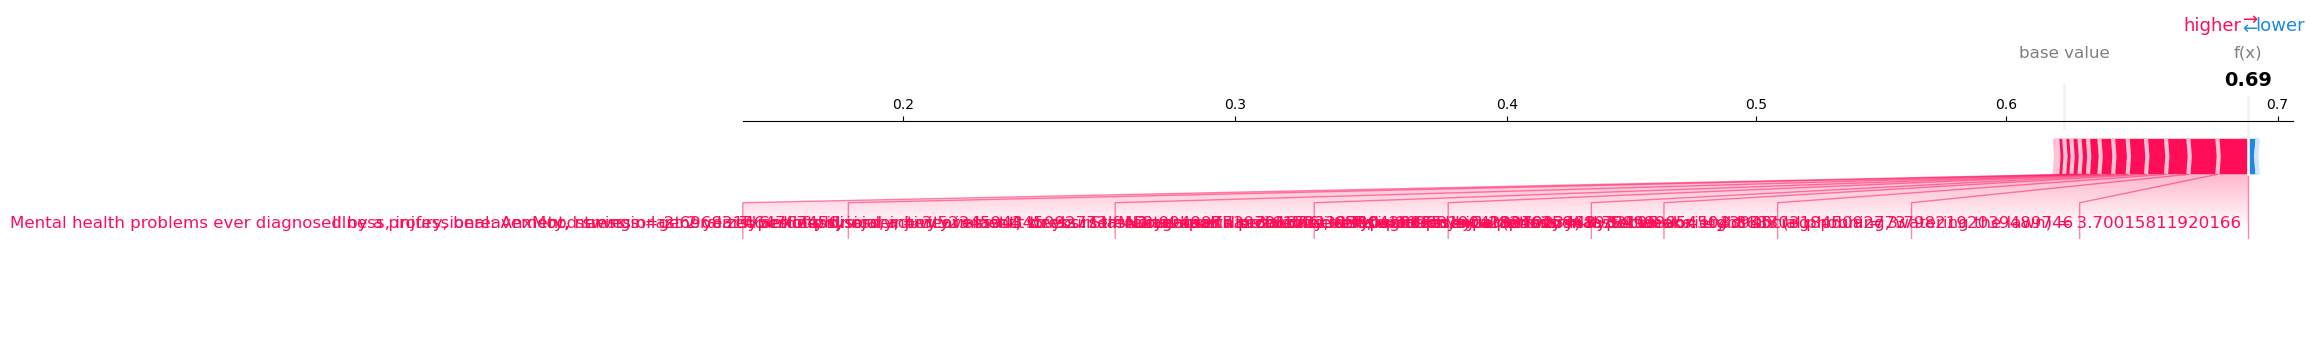

In [64]:
# print( shap_values_list )

# print the JS visualization code to the notebook
shap.initjs()

# print(shap_values[0, :])
# print(usable_features[0, :])
# shap.summary_plot(shap_values[:, :], usable_features[:, :])

# shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link = "logit", matplotlib = True)  

# using pandas dataframe
shap.force_plot(.5, shap_values[0,:], shuffled_X.iloc[0, :], link = "logit", matplotlib = True  )  

In [65]:
# shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

# using pandas dataframe
print(shap_values.shape)
print(shuffled_X.shape)
shap.force_plot(.5, shap_values[:,:], shuffled_X.iloc[:, :], link="logit")

(437, 15)
(437, 15)


# Summary Plot
This plot is made of all the dots in the train data. It delivers the following information:

Feature importance: Variables are ranked in descending order.

Impact: The horizontal location shows whether the effect of that value is associated with a higher or lower prediction.

Original value: Color shows whether that variable is high (in red) or low (in blue) for that observation.

Correlation: A high level of the “alcohol” content has a high and positive impact on the quality rating. The “high” comes from the red color, and the “positive” impact is shown on the X-axis. Similarly, we will say the “volatile acidity” is negatively correlated with the target variable.

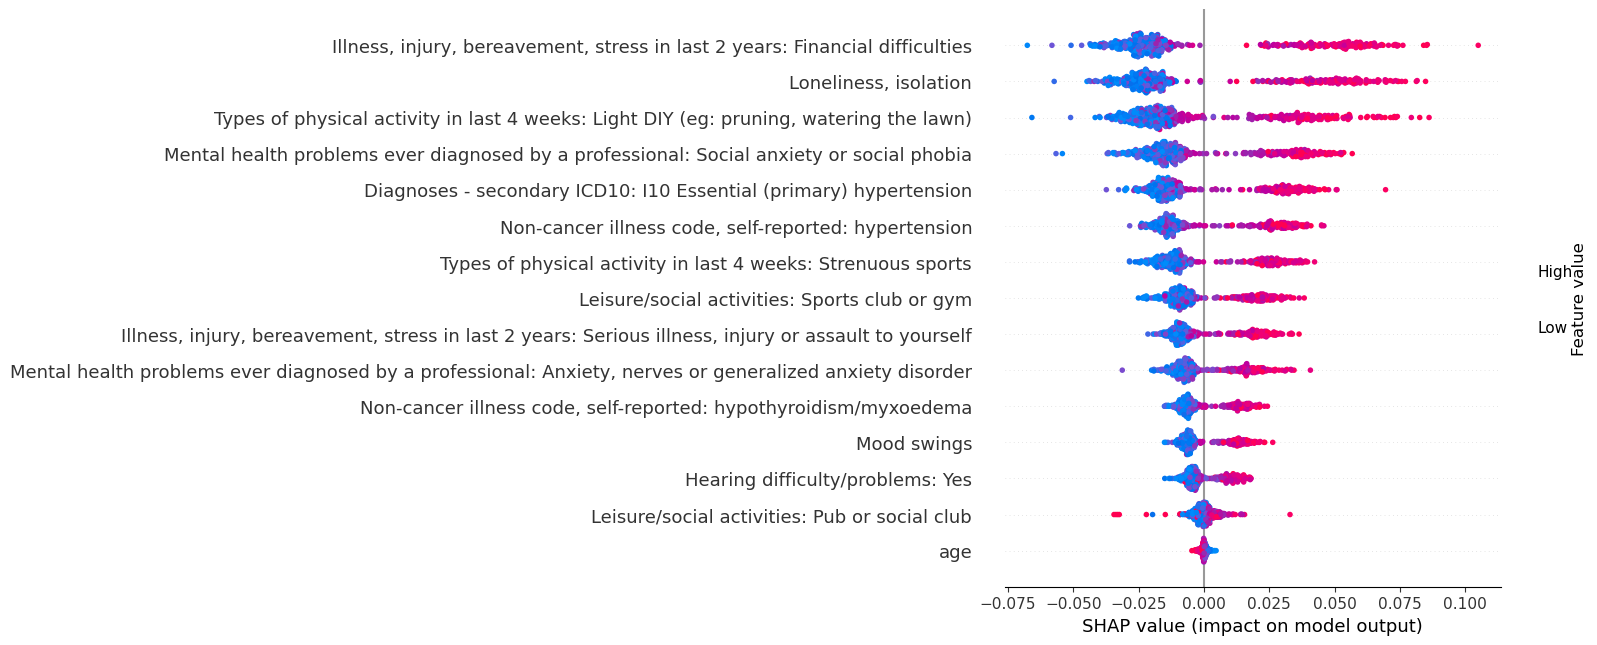

In [66]:
path = "./shap/" + str(num_features)
if not os.path.exists(path):
    os.makedirs(path)
    
# for trait in traits:
#     print(trait)
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# usable_features_std = (usable_features - usable_features.mean(0))/usable_features.std(0)
# shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot', max_display=len(traits), show = False)
# plt.savefig('shap/' + str(num_features) + '/summary_plot_hidden_'+ str(hidden) + '_dim_' + str(hidden_dimension) + '.pdf',  bbox_inches='tight')
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='dot', max_display=len(traits))

shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='dot', max_display=len(traits), show = False)


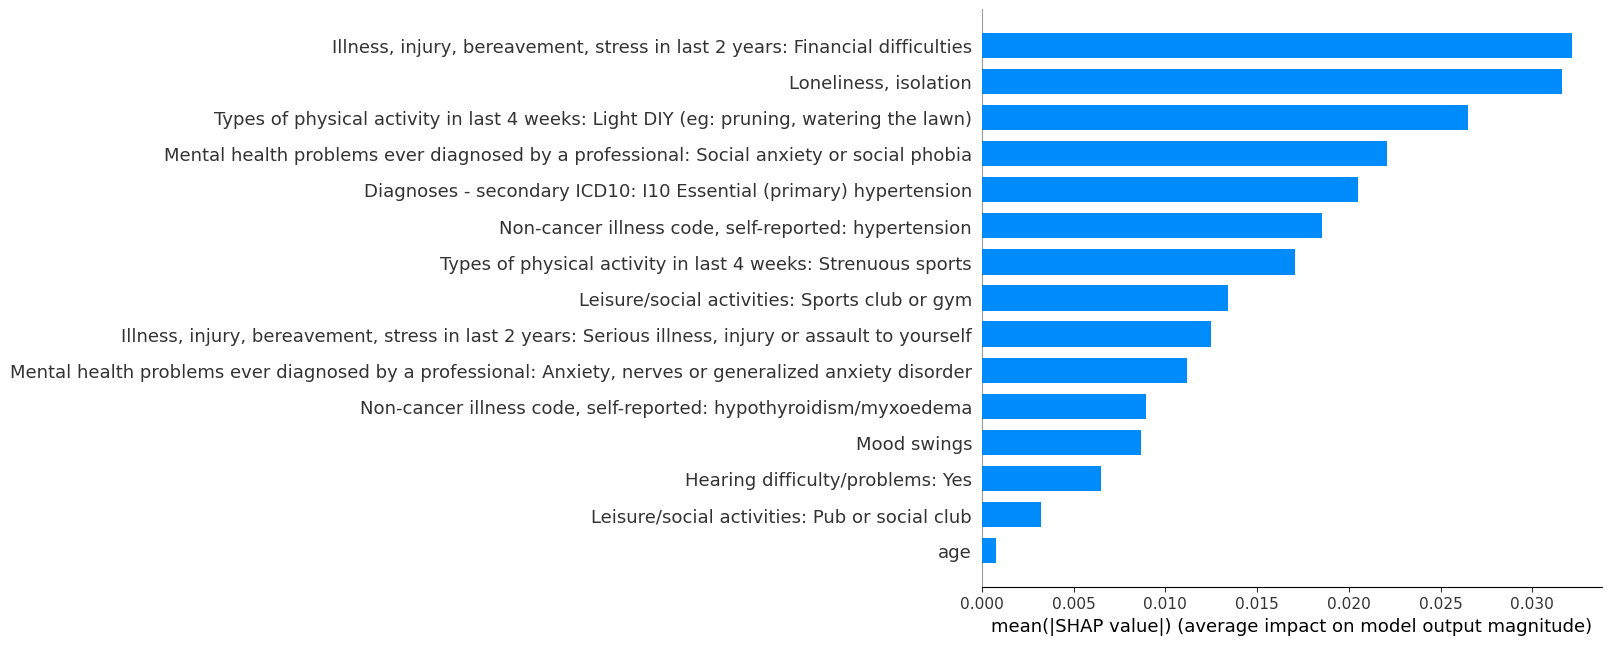

In [67]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(23)), plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')
# naeem modified
# shap.summary_plot(shap_values, features=usable_features, feature_names=list(range(num_features)), plot_type='bar', max_display=len(traits), show=False)
# shap.summary_plot(shap_values, features=usable_features, feature_names = traits, plot_type='bar', max_display=len(traits), show=False)
# plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

shap.summary_plot(shap_values, features = shuffled_X, feature_names = shuffled_X.columns, plot_type='bar', max_display=len(traits), show=False)
plt.savefig('shap/' + str(num_features) + 'summary_plot_hidden_'+ str(hidden) + '_bar.png', bbox_inches='tight')

In [68]:
sorted(list(zip(list(range(23)), abs(shap_values).mean(0))), key=lambda x:x[1], reverse=True)

[(0, 0.0321741383780149),
 (2, 0.03161313154540516),
 (1, 0.026477105465777525),
 (14, 0.02207183279883421),
 (12, 0.020499214766324447),
 (4, 0.018528643363333788),
 (7, 0.017061325565213656),
 (13, 0.013427928902374667),
 (5, 0.012495813394783986),
 (9, 0.011158754721945845),
 (3, 0.008960849534650518),
 (11, 0.00865894991702986),
 (6, 0.006468889694961592),
 (8, 0.003211750604501388),
 (10, 0.0007849529750341254)]

In [69]:
help(shap.force_plot)


Help on function force in module shap.plots._force:

force(base_value, shap_values=None, features=None, feature_names=None, out_names=None, link='identity', plot_cmap='RdBu', matplotlib=False, show=True, figsize=(20, 3), ordering_keys=None, ordering_keys_time_format=None, text_rotation=0, contribution_threshold=0.05)
    Visualize the given SHAP values with an additive force layout.
    
    Parameters
    ----------
    base_value : float
        This is the reference value that the feature contributions start from. For SHAP values it should
        be the value of explainer.expected_value.
    
    shap_values : numpy.array
        Matrix of SHAP values (# features) or (# samples x # features). If this is a 1D array then a single
        force plot will be drawn, if it is a 2D array then a stacked force plot will be drawn.
    
    features : numpy.array
        Matrix of feature values (# features) or (# samples x # features). This provides the values of all the
        features, an

# SVM 